In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 1000000
gamma=0.9999
#gamma=0.85
egreedy = 0.99
egreedy_final = 0.01
egreedy_decay = 500000

report_interval=10

score_to_solve = 195

hidden_layer_size=128

replay_memory_size=100000

batch_size=32

In [9]:
env = gym.make('Breakout-ramDeterministic-v4')

In [10]:
env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [11]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
env = gym.wrappers.Monitor(env, '../mp4/breakout_dqn_replay_more',video_callable=lambda episode_id: episode_id%100==0,force=True)

In [12]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [13]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [14]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_in  = nn.Linear(number_of_inputs,hidden_layer_size)
        
        self.linear_h  = nn.Linear(hidden_layer_size,hidden_layer_size)
        
        #self.linear_r_0_0 = nn.Linear(hidden_layer_size,hidden_layer_size)
        #self.linear_r_0_1 = nn.Linear(hidden_layer_size,hidden_layer_size)
        #self.linear_r_1_0 = nn.Linear(hidden_layer_size,hidden_layer_size)
        #self.linear_r_1_1 = nn.Linear(hidden_layer_size,hidden_layer_size)
        #self.linear_r_2_0 = nn.Linear(hidden_layer_size,hidden_layer_size)
        #self.linear_r_2_1 = nn.Linear(hidden_layer_size,hidden_layer_size)
        
        self.linear_out = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.ReLU()
        
    def forward(self, x):
        x = self.linear_in(x)
        x = self.activation(x)
        x = self.linear_h(x)
        x = self.activation(x)
        
        #skip_0 = x
        #x=self.linear_r_0_0(x)
        #x=self.activation(x)
        #x=self.linear_r_0_1(x)
        #x=self.activation(x)
        #x=x+skip_0
        
        #skip_1 = x
        #x=self.linear_r_1_0(x)
        #x=self.activation(x)
        #x=self.linear_r_1_1(x)
        #x=self.activation(x)
        #x=x+skip_1
        
        #skip_2 = x
        #x=self.linear_r_2_0(x)
        #x=self.activation(x)
        #x=self.linear_r_2_1(x)
        #x=self.activation(x)
        #x=x+skip_2
        
        x= self.linear_out(x)
        
        return x

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_in = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linearh1 = nn.Linear(hidden_layer_size,hidden_layer_size)
        self.bn1=nn.BatchNorm1d(hidden_layer_size)
        #self.linearh2 = nn.Linear(hidden_layer_size,hidden_layer_size)
        #self.linearh3 = nn.Linear(hidden_layer_size,hidden_layer_size)
        #self.linearh4 = nn.Linear(hidden_layer_size,hidden_layer_size)
        self.linear_out = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        x = self.linear_in(x)
        x = self.activation(x)
        
        skip=x
        #print(x.shape)
        x=self.bn1(x)
        x = self.linearh1(x)
        x = self.activation(x)
        x=x+skip
        
        #x = self.linearh2(x)
        #x = self.activation(x)
        
        #x = self.linearh3(x)
        #x = self.activation(x)
        
        #x = self.linearh4(x)
        #x = self.activation(x)
        
        output = self.linear_out(x)
        
        return output

In [16]:
class QNet_Agent():
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=torch.squeeze(self.nn(torch.unsqueeze(state,0)))
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
            
        new_state_values=self.nn(new_state).detach()
        #print('shape of: new_state_values')
        #print(new_state_values.shape)
        
        max_new_state_values=torch.max(new_state_values,dim=1)[0]
        #print('shape of: max_new_state_values')
        #print(max_new_state_values.shape)
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

In [17]:
memory=ExperienceReplay(replay_memory_size)

In [18]:
qnet_agent=QNet_Agent()

In [19]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [ ]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)
reward_total=np.full([num_episodes],-999,dtype=np.int32)


frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    state=state/256.0
    #for step in range(100):
    step=0
    reward_total[i_episode]=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        
        action=qnet_agent.select_action(state,epsilon)
        #print('performed ',action)
        
        new_state, reward, done, info = env.step(action)
        
        #print('reward: ', reward)
        #if reward >0.0:
        #    print(' ^^^+++++++++++++++^^^ ')
                  
        new_state=new_state/256.0
        memory.push(state, action, new_state,
                     reward, done)
        
        
        reward_total[i_episode]+=reward
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
                mean_ep_len_100 = np.sum(steps_total[i_episode-100:i_episode])/100
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
                recent_avg_ep_len=np.average(steps_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                print("Recent average episode length: {}".format(recent_avg_ep_len))
                if i_episode>100:
                    print("Mean reward over last 100: {}".format(mean_reward_100))
                    print("Mean episode length over last 100: {}".format(mean_ep_len_100))
                full_avg_so_far=np.average(reward_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        
        

**** Episode  10 **** 
Recent average reward: 1.4
Recent average episode length: 198.2
Average over all episodes so far: 1.4
epsilon: 0.9857930955396621
**** Episode  20 **** 
Recent average reward: 1.3
Recent average episode length: 185.4
Average over all episodes so far: 1.35
epsilon: 0.9821543339737241
**** Episode  30 **** 
Recent average reward: 0.9
Recent average episode length: 173.5
Average over all episodes so far: 1.2
epsilon: 0.9788798124750601
**** Episode  40 **** 
Recent average reward: 0.6
Recent average episode length: 158.7
Average over all episodes so far: 1.05
epsilon: 0.9757186813495105
**** Episode  50 **** 
Recent average reward: 1.1
Recent average episode length: 181.2
Average over all episodes so far: 1.06
epsilon: 0.9722849105828738
**** Episode  60 **** 
Recent average reward: 1.3
Recent average episode length: 181.1
Average over all episodes so far: 1.1
epsilon: 0.9688249953830897
**** Episode  70 **** 
Recent average reward: 2.2
Recent average episode length

**** Episode  390 **** 
Recent average reward: 1.1
Recent average episode length: 174.7
Mean reward over last 100: 1.36
Mean episode length over last 100: 190.77
Average over all episodes so far: 1.2820512820512822
epsilon: 0.8581034079245016
**** Episode  400 **** 
Recent average reward: 1.2
Recent average episode length: 179.6
Mean reward over last 100: 1.44
Mean episode length over last 100: 193.16
Average over all episodes so far: 1.28
epsilon: 0.8549830531097313
**** Episode  410 **** 
Recent average reward: 1.3
Recent average episode length: 181.6
Mean reward over last 100: 1.39
Mean episode length over last 100: 190.67
Average over all episodes so far: 1.2804878048780488
epsilon: 0.8519381636203083
**** Episode  420 **** 
Recent average reward: 1.5
Recent average episode length: 191.7
Mean reward over last 100: 1.43
Mean episode length over last 100: 191.45
Average over all episodes so far: 1.2857142857142858
epsilon: 0.8487247400642803
**** Episode  430 **** 
Recent average rew

**** Episode  730 **** 
Recent average reward: 0.8
Recent average episode length: 165.3
Mean reward over last 100: 1.36
Mean episode length over last 100: 188.42
Average over all episodes so far: 1.2821917808219179
epsilon: 0.7576646672685001
**** Episode  740 **** 
Recent average reward: 1.1
Recent average episode length: 175.9
Mean reward over last 100: 1.3
Mean episode length over last 100: 186.18
Average over all episodes so far: 1.2797297297297296
epsilon: 0.755156729681092
**** Episode  750 **** 
Recent average reward: 0.9
Recent average episode length: 162.7
Mean reward over last 100: 1.26
Mean episode length over last 100: 184.19
Average over all episodes so far: 1.2746666666666666
epsilon: 0.7527255322288608
**** Episode  760 **** 
Recent average reward: 1.5
Recent average episode length: 190.3
Mean reward over last 100: 1.26
Mean episode length over last 100: 183.73
Average over all episodes so far: 1.2776315789473685
epsilon: 0.7498730161415871
**** Episode  770 **** 
Recent

**** Episode  1070 **** 
Recent average reward: 1.6
Recent average episode length: 195.3
Mean reward over last 100: 1.46
Mean episode length over last 100: 191.98
Average over all episodes so far: 1.3018691588785047
epsilon: 0.6681932437139461
**** Episode  1080 **** 
Recent average reward: 1.5
Recent average episode length: 185.9
Mean reward over last 100: 1.47
Mean episode length over last 100: 191.77
Average over all episodes so far: 1.3037037037037038
epsilon: 0.6657939058455347
**** Episode  1090 **** 
Recent average reward: 1.2
Recent average episode length: 182.3
Mean reward over last 100: 1.44
Mean episode length over last 100: 189.98
Average over all episodes so far: 1.3027522935779816
epsilon: 0.6633771787685097
**** Episode  1100 **** 
Recent average reward: 1.8
Recent average episode length: 195.8
Mean reward over last 100: 1.43
Mean episode length over last 100: 188.48
Average over all episodes so far: 1.3072727272727274
epsilon: 0.6608313669207625
**** Episode  1110 **** 

**** Episode  1420 **** 
Recent average reward: 1.0
Recent average episode length: 172.8
Mean reward over last 100: 2.15
Mean episode length over last 100: 212.61
Average over all episodes so far: 1.388732394366197
epsilon: 0.5820020479265829
**** Episode  1430 **** 
Recent average reward: 1.4
Recent average episode length: 190.7
Mean reward over last 100: 2.21
Mean episode length over last 100: 213.6
Average over all episodes so far: 1.3888111888111887
epsilon: 0.5798781532017591
**** Episode  1440 **** 
Recent average reward: 1.3
Recent average episode length: 194.2
Mean reward over last 100: 2.15
Mean episode length over last 100: 211.76
Average over all episodes so far: 1.3881944444444445
epsilon: 0.5776293038889875
**** Episode  1450 **** 
Recent average reward: 0.8
Recent average episode length: 173.4
Mean reward over last 100: 2.11
Mean episode length over last 100: 209.12
Average over all episodes so far: 1.3841379310344828
epsilon: 0.575687933360478
**** Episode  1460 **** 
Re

**** Episode  1770 **** 
Recent average reward: 1.7
Recent average episode length: 193.3
Mean reward over last 100: 1.75
Mean episode length over last 100: 202.15
Average over all episodes so far: 1.423728813559322
epsilon: 0.5081347245510154
**** Episode  1780 **** 
Recent average reward: 1.7
Recent average episode length: 195.4
Mean reward over last 100: 1.82
Mean episode length over last 100: 204.23
Average over all episodes so far: 1.4252808988764045
epsilon: 0.5060717490790319
**** Episode  1790 **** 
Recent average reward: 2.7
Recent average episode length: 225.7
Mean reward over last 100: 1.91
Mean episode length over last 100: 207.33
Average over all episodes so far: 1.4324022346368714
epsilon: 0.5038740729644364
**** Episode  1800 **** 
Recent average reward: 4.7
Recent average episode length: 271.2
Mean reward over last 100: 2.21
Mean episode length over last 100: 214.63
Average over all episodes so far: 1.4505555555555556
epsilon: 0.501026732667926
**** Episode  1810 **** 
R

**** Episode  2180 **** 
Recent average reward: 1.9
Recent average episode length: 218.2
Mean reward over last 100: 1.76
Mean episode length over last 100: 209.96
Average over all episodes so far: 1.8564220183486237
epsilon: 0.41456425392743235
**** Episode  2190 **** 
Recent average reward: 1.0
Recent average episode length: 181.7
Mean reward over last 100: 1.69
Mean episode length over last 100: 206.53
Average over all episodes so far: 1.8525114155251141
epsilon: 0.41310963482652074
**** Episode  2200 **** 
Recent average reward: 1.3
Recent average episode length: 194.1
Mean reward over last 100: 1.65
Mean episode length over last 100: 205.08
Average over all episodes so far: 1.85
epsilon: 0.4114875690609799
**** Episode  2210 **** 
Recent average reward: 2.7
Recent average episode length: 237.8
Mean reward over last 100: 1.76
Mean episode length over last 100: 208.1
Average over all episodes so far: 1.853846153846154
epsilon: 0.4096281827399122
**** Episode  2220 **** 
Recent averag

**** Episode  2520 **** 
Recent average reward: 2.0
Recent average episode length: 230.9
Mean reward over last 100: 2.16
Mean episode length over last 100: 226.34
Average over all episodes so far: 1.8714285714285714
epsilon: 0.3584938460545526
**** Episode  2530 **** 
Recent average reward: 2.3
Recent average episode length: 247.0
Mean reward over last 100: 2.05
Mean episode length over last 100: 227.19
Average over all episodes so far: 1.8731225296442688
epsilon: 0.3567723704204382
**** Episode  2540 **** 
Recent average reward: 2.0
Recent average episode length: 229.6
Mean reward over last 100: 2.04
Mean episode length over last 100: 228.63
Average over all episodes so far: 1.8736220472440945
epsilon: 0.3551194440203318
**** Episode  2550 **** 
Recent average reward: 2.5
Recent average episode length: 229.9
Mean reward over last 100: 2.05
Mean episode length over last 100: 226.42
Average over all episodes so far: 1.876078431372549
epsilon: 0.35362899472542497
**** Episode  2560 **** 

**** Episode  2860 **** 
Recent average reward: 2.6
Recent average episode length: 275.2
Mean reward over last 100: 2.17
Mean episode length over last 100: 234.62
Average over all episodes so far: 1.8902097902097903
epsilon: 0.309008072592878
**** Episode  2870 **** 
Recent average reward: 1.9
Recent average episode length: 228.9
Mean reward over last 100: 2.18
Mean episode length over last 100: 235.51
Average over all episodes so far: 1.8902439024390243
epsilon: 0.3076090081031417
**** Episode  2880 **** 
Recent average reward: 1.5
Recent average episode length: 218.6
Mean reward over last 100: 2.12
Mean episode length over last 100: 235.38
Average over all episodes so far: 1.8888888888888888
epsilon: 0.30625026046764026
**** Episode  2890 **** 
Recent average reward: 2.0
Recent average episode length: 221.8
Mean reward over last 100: 2.11
Mean episode length over last 100: 233.64
Average over all episodes so far: 1.8892733564013842
epsilon: 0.3049991785219591
**** Episode  2900 **** 

**** Episode  3200 **** 
Recent average reward: 3.0
Recent average episode length: 267.4
Mean reward over last 100: 2.06
Mean episode length over last 100: 236.69
Average over all episodes so far: 1.8965625
epsilon: 0.26596701068513273
**** Episode  3210 **** 
Recent average reward: 1.6
Recent average episode length: 211.4
Mean reward over last 100: 2.09
Mean episode length over last 100: 237.32
Average over all episodes so far: 1.895638629283489
epsilon: 0.2648529141954645
**** Episode  3220 **** 
Recent average reward: 1.7
Recent average episode length: 217.8
Mean reward over last 100: 2.07
Mean episode length over last 100: 234.57
Average over all episodes so far: 1.8950310559006212
epsilon: 0.263708652601113
**** Episode  3230 **** 
Recent average reward: 2.5
Recent average episode length: 254.1
Mean reward over last 100: 2.14
Mean episode length over last 100: 237.58
Average over all episodes so far: 1.896904024767802
epsilon: 0.2624266147109002
**** Episode  3240 **** 
Recent ave

**** Episode  3540 **** 
Recent average reward: 2.9
Recent average episode length: 282.5
Mean reward over last 100: 2.62
Mean episode length over last 100: 257.84
Average over all episodes so far: 1.9494350282485875
epsilon: 0.22611108797604842
**** Episode  3550 **** 
Recent average reward: 1.9
Recent average episode length: 230.4
Mean reward over last 100: 2.52
Mean episode length over last 100: 253.32
Average over all episodes so far: 1.9492957746478874
epsilon: 0.22510377189566047
**** Episode  3560 **** 
Recent average reward: 2.5
Recent average episode length: 252.9
Mean reward over last 100: 2.44
Mean episode length over last 100: 251.53
Average over all episodes so far: 1.9508426966292134
epsilon: 0.2240172398159335
**** Episode  3570 **** 
Recent average reward: 3.0
Recent average episode length: 258.0
Mean reward over last 100: 2.31
Mean episode length over last 100: 247.03
Average over all episodes so far: 1.953781512605042
epsilon: 0.2229766577475653
**** Episode  3580 ****

**** Episode  3880 **** 
Recent average reward: 1.5
Recent average episode length: 224.3
Mean reward over last 100: 2.08
Mean episode length over last 100: 246.97
Average over all episodes so far: 1.9938144329896907
epsilon: 0.19145479723951936
**** Episode  3890 **** 
Recent average reward: 2.2
Recent average episode length: 269.2
Mean reward over last 100: 2.08
Mean episode length over last 100: 249.79
Average over all episodes so far: 1.994344473007712
epsilon: 0.19048768921728867
**** Episode  3900 **** 
Recent average reward: 1.8
Recent average episode length: 246.4
Mean reward over last 100: 2.02
Mean episode length over last 100: 249.05
Average over all episodes so far: 1.9938461538461538
epsilon: 0.18955553938115527
**** Episode  3910 **** 
Recent average reward: 2.0
Recent average episode length: 261.0
Mean reward over last 100: 1.98
Mean episode length over last 100: 249.81
Average over all episodes so far: 1.9938618925831202
epsilon: 0.1886035547508637
**** Episode  3920 ***

**** Episode  4220 **** 
Recent average reward: 1.8
Recent average episode length: 245.8
Mean reward over last 100: 2.32
Mean episode length over last 100: 254.48
Average over all episodes so far: 2.023696682464455
epsilon: 0.1621907352952679
**** Episode  4230 **** 
Recent average reward: 2.0
Recent average episode length: 258.7
Mean reward over last 100: 2.19
Mean episode length over last 100: 254.17
Average over all episodes so far: 2.023640661938534
epsilon: 0.16143046938770084
**** Episode  4240 **** 
Recent average reward: 2.3
Recent average episode length: 267.1
Mean reward over last 100: 2.18
Mean episode length over last 100: 256.42
Average over all episodes so far: 2.024292452830189
epsilon: 0.16068002845453103
**** Episode  4250 **** 
Recent average reward: 2.4
Recent average episode length: 250.4
Mean reward over last 100: 2.16
Mean episode length over last 100: 256.0
Average over all episodes so far: 2.025176470588235
epsilon: 0.15991201744844652
**** Episode  4260 **** 
R

**** Episode  4560 **** 
Recent average reward: 2.3
Recent average episode length: 253.0
Mean reward over last 100: 2.23
Mean episode length over last 100: 261.33
Average over all episodes so far: 2.0528508771929825
epsilon: 0.13660152705265458
**** Episode  4570 **** 
Recent average reward: 2.5
Recent average episode length: 278.6
Mean reward over last 100: 2.27
Mean episode length over last 100: 261.85
Average over all episodes so far: 2.0538293216630197
epsilon: 0.13592626933454083
**** Episode  4580 **** 
Recent average reward: 3.9
Recent average episode length: 276.4
Mean reward over last 100: 2.39
Mean episode length over last 100: 262.48
Average over all episodes so far: 2.0578602620087336
epsilon: 0.13523933312462658
**** Episode  4590 **** 
Recent average reward: 2.2
Recent average episode length: 256.4
Mean reward over last 100: 2.37
Mean episode length over last 100: 261.06
Average over all episodes so far: 2.0581699346405227
epsilon: 0.13458080875588022
**** Episode  4600 *

**** Episode  4900 **** 
Recent average reward: 1.5
Recent average episode length: 250.5
Mean reward over last 100: 2.32
Mean episode length over last 100: 283.41
Average over all episodes so far: 2.0748979591836734
epsilon: 0.11557932558553058
**** Episode  4910 **** 
Recent average reward: 2.4
Recent average episode length: 289.3
Mean reward over last 100: 2.36
Mean episode length over last 100: 283.0
Average over all episodes so far: 2.0755600814663953
epsilon: 0.1149248701496181
**** Episode  4920 **** 
Recent average reward: 2.6
Recent average episode length: 289.0
Mean reward over last 100: 2.39
Mean episode length over last 100: 283.6
Average over all episodes so far: 2.0766260162601626
epsilon: 0.1143378896478445
**** Episode  4930 **** 
Recent average reward: 1.4
Recent average episode length: 241.0
Mean reward over last 100: 2.18
Mean episode length over last 100: 274.5
Average over all episodes so far: 2.0752535496957405
epsilon: 0.11381833279557443
**** Episode  4940 **** 


**** Episode  5240 **** 
Recent average reward: 3.0
Recent average episode length: 300.2
Mean reward over last 100: 2.83
Mean episode length over last 100: 324.38
Average over all episodes so far: 2.099236641221374
epsilon: 0.09558675772144112
**** Episode  5250 **** 
Recent average reward: 2.3
Recent average episode length: 304.3
Mean reward over last 100: 2.75
Mean episode length over last 100: 322.47
Average over all episodes so far: 2.0996190476190475
epsilon: 0.09507630601997043
**** Episode  5260 **** 
Recent average reward: 4.9
Recent average episode length: 391.6
Mean reward over last 100: 3.0
Mean episode length over last 100: 329.46
Average over all episodes so far: 2.104942965779468
epsilon: 0.09439790437930956
**** Episode  5270 **** 
Recent average reward: 2.5
Recent average episode length: 310.1
Mean reward over last 100: 2.96
Mean episode length over last 100: 328.18
Average over all episodes so far: 2.105692599620493
epsilon: 0.09389789901856953
**** Episode  5280 **** 

**** Episode  5580 **** 
Recent average reward: 2.1
Recent average episode length: 337.6
Mean reward over last 100: 2.53
Mean episode length over last 100: 358.08
Average over all episodes so far: 2.1258064516129034
epsilon: 0.07790478963800936
**** Episode  5590 **** 
Recent average reward: 2.7
Recent average episode length: 399.2
Mean reward over last 100: 2.61
Mean episode length over last 100: 364.11
Average over all episodes so far: 2.126833631484794
epsilon: 0.07736506577904487
**** Episode  5600 **** 
Recent average reward: 1.6
Recent average episode length: 318.3
Mean reward over last 100: 2.52
Mean episode length over last 100: 358.46
Average over all episodes so far: 2.125892857142857
epsilon: 0.07693222710282253
**** Episode  5610 **** 
Recent average reward: 2.3
Recent average episode length: 374.3
Mean reward over last 100: 2.49
Mean episode length over last 100: 358.44
Average over all episodes so far: 2.1262032085561495
epsilon: 0.07644845748118506
**** Episode  5620 ***

**** Episode  5920 **** 
Recent average reward: 3.0
Recent average episode length: 431.7
Mean reward over last 100: 2.79
Mean episode length over last 100: 392.13
Average over all episodes so far: 2.159797297297297
epsilon: 0.0627498311637905
**** Episode  5930 **** 
Recent average reward: 3.6
Recent average episode length: 411.5
Mean reward over last 100: 2.86
Mean episode length over last 100: 395.4
Average over all episodes so far: 2.1622259696458683
epsilon: 0.062303880835030974
**** Episode  5940 **** 
Recent average reward: 1.9
Recent average episode length: 349.5
Mean reward over last 100: 2.74
Mean episode length over last 100: 392.33
Average over all episodes so far: 2.1617845117845116
epsilon: 0.06192407584200843
**** Episode  5950 **** 
Recent average reward: 1.9
Recent average episode length: 424.3
Mean reward over last 100: 2.7
Mean episode length over last 100: 392.98
Average over all episodes so far: 2.161344537815126
epsilon: 0.061478207957652506
**** Episode  5960 ****

**** Episode  6260 **** 
Recent average reward: 2.1
Recent average episode length: 359.4
Mean reward over last 100: 2.54
Mean episode length over last 100: 411.48
Average over all episodes so far: 2.1894568690095846
epsilon: 0.05035916763117623
**** Episode  6270 **** 
Recent average reward: 2.7
Recent average episode length: 418.1
Mean reward over last 100: 2.55
Mean episode length over last 100: 407.33
Average over all episodes so far: 2.1902711323763957
epsilon: 0.0499973247914905
**** Episode  6280 **** 
Recent average reward: 4.3
Recent average episode length: 478.3
Mean reward over last 100: 2.71
Mean episode length over last 100: 414.52
Average over all episodes so far: 2.1936305732484076
epsilon: 0.04965022297572307
**** Episode  6290 **** 
Recent average reward: 2.0
Recent average episode length: 312.5
Mean reward over last 100: 2.62
Mean episode length over last 100: 405.51
Average over all episodes so far: 2.1933227344992052
epsilon: 0.049387660094018335
**** Episode  6300 *

**** Episode  6600 **** 
Recent average reward: 4.0
Recent average episode length: 479.0
Mean reward over last 100: 3.34
Mean episode length over last 100: 463.0
Average over all episodes so far: 2.229090909090909
epsilon: 0.04051018528584118
**** Episode  6610 **** 
Recent average reward: 3.0
Recent average episode length: 508.7
Mean reward over last 100: 3.27
Mean episode length over last 100: 462.85
Average over all episodes so far: 2.2302571860816944
epsilon: 0.040195187931388855
**** Episode  6620 **** 
Recent average reward: 3.4
Recent average episode length: 531.6
Mean reward over last 100: 3.2
Mean episode length over last 100: 469.03
Average over all episodes so far: 2.23202416918429
epsilon: 0.039880574042146094
**** Episode  6630 **** 
Recent average reward: 2.5
Recent average episode length: 497.1
Mean reward over last 100: 3.13
Mean episode length over last 100: 473.86
Average over all episodes so far: 2.232428355957768
epsilon: 0.039588405297394894
**** Episode  6640 ****

**** Episode  6940 **** 
Recent average reward: 2.4
Recent average episode length: 485.5
Mean reward over last 100: 3.82
Mean episode length over last 100: 478.12
Average over all episodes so far: 2.2861671469740634
epsilon: 0.03152834785740137
**** Episode  6950 **** 
Recent average reward: 3.3
Recent average episode length: 646.2
Mean reward over last 100: 3.73
Mean episode length over last 100: 493.86
Average over all episodes so far: 2.2876258992805756
epsilon: 0.031269977505975974
**** Episode  6960 **** 
Recent average reward: 2.5
Recent average episode length: 473.8
Mean reward over last 100: 3.53
Mean episode length over last 100: 480.59
Average over all episodes so far: 2.287931034482759
epsilon: 0.031058632512431496
**** Episode  6970 **** 
Recent average reward: 4.0
Recent average episode length: 523.2
Mean reward over last 100: 3.54
Mean episode length over last 100: 495.68
Average over all episodes so far: 2.29038737446198
epsilon: 0.030835506438128754
**** Episode  6980 *

**** Episode  7280 **** 
Recent average reward: 2.1
Recent average episode length: 398.3
Mean reward over last 100: 3.52
Mean episode length over last 100: 641.08
Average over all episodes so far: 2.3184065934065936
epsilon: 0.0247133989476505
**** Episode  7290 **** 
Recent average reward: 2.1
Recent average episode length: 467.0
Mean reward over last 100: 3.39
Mean episode length over last 100: 620.23
Average over all episodes so far: 2.3181069958847735
epsilon: 0.02456428897230902
**** Episode  7300 **** 
Recent average reward: 3.1
Recent average episode length: 644.3
Mean reward over last 100: 3.33
Mean episode length over last 100: 633.07
Average over all episodes so far: 2.319178082191781
epsilon: 0.024392317707142508
**** Episode  7310 **** 
Recent average reward: 2.1
Recent average episode length: 800.7
Mean reward over last 100: 3.17
Mean episode length over last 100: 640.36
Average over all episodes so far: 2.3188782489740083
epsilon: 0.024155660390045686
**** Episode  7320 *

**** Episode  7620 **** 
Recent average reward: 2.8
Recent average episode length: 581.2
Mean reward over last 100: 3.27
Mean episode length over last 100: 585.42
Average over all episodes so far: 2.340813648293963
epsilon: 0.019766699329479408
**** Episode  7630 **** 
Recent average reward: 3.1
Recent average episode length: 622.1
Mean reward over last 100: 3.28
Mean episode length over last 100: 574.56
Average over all episodes so far: 2.3418086500655306
epsilon: 0.019644353086281305
**** Episode  7640 **** 
Recent average reward: 3.0
Recent average episode length: 677.0
Mean reward over last 100: 3.19
Mean episode length over last 100: 592.22
Average over all episodes so far: 2.342670157068063
epsilon: 0.019513430829175053
**** Episode  7650 **** 
Recent average reward: 3.6
Recent average episode length: 685.9
Mean reward over last 100: 3.3
Mean episode length over last 100: 609.3
Average over all episodes so far: 2.344313725490196
epsilon: 0.019383535131096172
**** Episode  7660 **

**** Episode  7960 **** 
Recent average reward: 3.3
Recent average episode length: 582.4
Mean reward over last 100: 3.34
Mean episode length over last 100: 922.28
Average over all episodes so far: 2.372110552763819
epsilon: 0.015798646751744617
**** Episode  7970 **** 
Recent average reward: 2.0
Recent average episode length: 717.9
Mean reward over last 100: 3.08
Mean episode length over last 100: 885.33
Average over all episodes so far: 2.3716436637390212
epsilon: 0.015717768298551957
**** Episode  7980 **** 
Recent average reward: 4.5
Recent average episode length: 949.6
Mean reward over last 100: 3.14
Mean episode length over last 100: 873.36
Average over all episodes so far: 2.3743107769423557
epsilon: 0.015606073545159267
**** Episode  7990 **** 
Recent average reward: 4.1
Recent average episode length: 1031.8
Mean reward over last 100: 3.28
Mean episode length over last 100: 902.44
Average over all episodes so far: 2.376470588235294
epsilon: 0.015496736605385777
**** Episode  800

**** Episode  8300 **** 
Recent average reward: 2.5
Recent average episode length: 1217.6
Mean reward over last 100: 2.83
Mean episode length over last 100: 996.27
Average over all episodes so far: 2.416385542168675
epsilon: 0.012743549641743393
**** Episode  8310 **** 
Recent average reward: 4.1
Recent average episode length: 1173.7
Mean reward over last 100: 2.87
Mean episode length over last 100: 1011.16
Average over all episodes so far: 2.4184115523465706
epsilon: 0.012690218915864193
**** Episode  8320 **** 
Recent average reward: 3.0
Recent average episode length: 1144.0
Mean reward over last 100: 2.73
Mean episode length over last 100: 1000.29
Average over all episodes so far: 2.4191105769230767
epsilon: 0.01262776735619705
**** Episode  8330 **** 
Recent average reward: 2.8
Recent average episode length: 1286.3
Mean reward over last 100: 2.72
Mean episode length over last 100: 1025.45
Average over all episodes so far: 2.4195678271308525
epsilon: 0.012556467880659682
**** Episod

**** Episode  8640 **** 
Recent average reward: 2.9
Recent average episode length: 1605.2
Mean reward over last 100: 3.07
Mean episode length over last 100: 1125.46
Average over all episodes so far: 2.457060185185185
epsilon: 0.011226583388826624
**** Episode  8650 **** 
Recent average reward: 3.7
Recent average episode length: 1860.0
Mean reward over last 100: 3.01
Mean episode length over last 100: 1198.24
Average over all episodes so far: 2.4584971098265895
epsilon: 0.011175555229422027
**** Episode  8660 **** 
Recent average reward: 5.0
Recent average episode length: 1750.4
Mean reward over last 100: 3.24
Mean episode length over last 100: 1292.48
Average over all episodes so far: 2.461431870669746
epsilon: 0.011137549709633269
**** Episode  8670 **** 
Recent average reward: 6.5
Recent average episode length: 1881.7
Mean reward over last 100: 3.61
Mean episode length over last 100: 1387.95
Average over all episodes so far: 2.466089965397924
epsilon: 0.011097416270197022
**** Episod

**** Episode  8980 **** 
Recent average reward: 3.7
Recent average episode length: 1576.9
Mean reward over last 100: 3.04
Mean episode length over last 100: 1483.35
Average over all episodes so far: 2.512694877505568
epsilon: 0.010460227002127676
**** Episode  8990 **** 
Recent average reward: 2.0
Recent average episode length: 1505.3
Mean reward over last 100: 2.96
Mean episode length over last 100: 1447.43
Average over all episodes so far: 2.5121245828698555
epsilon: 0.010447636648396201
**** Episode  9000 **** 
Recent average reward: 3.9
Recent average episode length: 1739.1
Mean reward over last 100: 2.97
Mean episode length over last 100: 1500.09
Average over all episodes so far: 2.5136666666666665
epsilon: 0.01043156228725836
**** Episode  9010 **** 
Recent average reward: 1.8
Recent average episode length: 1604.5
Mean reward over last 100: 2.79
Mean episode length over last 100: 1488.54
Average over all episodes so far: 2.5128745837957824
epsilon: 0.010419188144202311
**** Episo

**** Episode  9320 **** 
Recent average reward: 2.4
Recent average episode length: 973.2
Mean reward over last 100: 2.83
Mean episode length over last 100: 1203.52
Average over all episodes so far: 2.532832618025751
epsilon: 0.0101967570759162
**** Episode  9330 **** 
Recent average reward: 2.0
Recent average episode length: 922.2
Mean reward over last 100: 2.73
Mean episode length over last 100: 1138.26
Average over all episodes so far: 2.5322615219721327
epsilon: 0.010192412951344564
**** Episode  9340 **** 
Recent average reward: 3.3
Recent average episode length: 1688.4
Mean reward over last 100: 2.77
Mean episode length over last 100: 1119.43
Average over all episodes so far: 2.533083511777302
epsilon: 0.010186772229546795
**** Episode  9350 **** 
Recent average reward: 2.5
Recent average episode length: 1075.4
Mean reward over last 100: 2.59
Mean episode length over last 100: 1039.78
Average over all episodes so far: 2.533048128342246
epsilon: 0.010183208683593905
**** Episode  9

**** Episode  9660 **** 
Recent average reward: 2.3
Recent average episode length: 809.2
Mean reward over last 100: 3.26
Mean episode length over last 100: 1054.95
Average over all episodes so far: 2.5543478260869565
epsilon: 0.01008931199940097
**** Episode  9670 **** 
Recent average reward: 5.2
Recent average episode length: 1159.3
Mean reward over last 100: 3.47
Mean episode length over last 100: 998.15
Average over all episodes so far: 2.5570837642192346
epsilon: 0.010087286677971622
**** Episode  9680 **** 
Recent average reward: 3.5
Recent average episode length: 877.3
Mean reward over last 100: 3.38
Mean episode length over last 100: 955.45
Average over all episodes so far: 2.5580578512396692
epsilon: 0.010085740890798379
**** Episode  9690 **** 
Recent average reward: 4.4
Recent average episode length: 1494.5
Mean reward over last 100: 3.32
Mean episode length over last 100: 990.92
Average over all episodes so far: 2.559958720330237
epsilon: 0.010083343935795467
**** Episode  9

**** Episode  10000 **** 
Recent average reward: 2.8
Recent average episode length: 1080.1
Mean reward over last 100: 3.09
Mean episode length over last 100: 965.52
Average over all episodes so far: 2.5774
epsilon: 0.010039188598529336
**** Episode  10010 **** 
Recent average reward: 2.5
Recent average episode length: 901.7
Mean reward over last 100: 3.07
Mean episode length over last 100: 934.28
Average over all episodes so far: 2.577322677322677
epsilon: 0.01003848812879067
**** Episode  10020 **** 
Recent average reward: 4.6
Recent average episode length: 1644.3
Mean reward over last 100: 3.22
Mean episode length over last 100: 1017.52
Average over all episodes so far: 2.5793413173652695
epsilon: 0.010037201082140216
**** Episode  10030 **** 
Recent average reward: 3.2
Recent average episode length: 1014.8
Mean reward over last 100: 3.22
Mean episode length over last 100: 1016.73
Average over all episodes so far: 2.579960119641077
epsilon: 0.010036396690517006
**** Episode  10040 **

**** Episode  10340 **** 
Recent average reward: 3.9
Recent average episode length: 1079.9
Mean reward over last 100: 3.82
Mean episode length over last 100: 1198.58
Average over all episodes so far: 2.606963249516441
epsilon: 0.01001811564357035
**** Episode  10350 **** 
Recent average reward: 2.3
Recent average episode length: 652.0
Mean reward over last 100: 3.63
Mean episode length over last 100: 1104.27
Average over all episodes so far: 2.6066666666666665
epsilon: 0.010017861505218469
**** Episode  10360 **** 
Recent average reward: 2.4
Recent average episode length: 1092.7
Mean reward over last 100: 3.46
Mean episode length over last 100: 1048.69
Average over all episodes so far: 2.6064671814671816
epsilon: 0.010017489275257684
**** Episode  10370 **** 
Recent average reward: 2.9
Recent average episode length: 845.0
Mean reward over last 100: 3.35
Mean episode length over last 100: 1014.48
Average over all episodes so far: 2.6067502410800385
epsilon: 0.010017196190051461
**** Epi

**** Episode  10680 **** 
Recent average reward: 2.3
Recent average episode length: 1557.1
Mean reward over last 100: 3.16
Mean episode length over last 100: 1409.01
Average over all episodes so far: 2.6343632958801497
epsilon: 0.010007633602250897
**** Episode  10690 **** 
Recent average reward: 1.5
Recent average episode length: 539.9
Mean reward over last 100: 2.99
Mean episode length over last 100: 1315.88
Average over all episodes so far: 2.6333021515434987
epsilon: 0.010007546318667552
**** Episode  10700 **** 
Recent average reward: 1.5
Recent average episode length: 1139.5
Mean reward over last 100: 2.78
Mean episode length over last 100: 1302.57
Average over all episodes so far: 2.6322429906542055
epsilon: 0.01000734785071436
**** Episode  10710 **** 
Recent average reward: 2.8
Recent average episode length: 2117.6
Mean reward over last 100: 2.63
Mean episode length over last 100: 1329.7
Average over all episodes so far: 2.6323996265172735
epsilon: 0.010007060062122214
**** Ep

**** Episode  11020 **** 
Recent average reward: 4.1
Recent average episode length: 1840.2
Mean reward over last 100: 3.77
Mean episode length over last 100: 1187.86
Average over all episodes so far: 2.649092558983666
epsilon: 0.010003531369834064
**** Episode  11030 **** 
Recent average reward: 3.2
Recent average episode length: 1756.7
Mean reward over last 100: 3.64
Mean episode length over last 100: 1269.98
Average over all episodes so far: 2.6495920217588393
epsilon: 0.010003415499847864
**** Episode  11040 **** 
Recent average reward: 2.7
Recent average episode length: 1176.6
Mean reward over last 100: 3.7
Mean episode length over last 100: 1292.91
Average over all episodes so far: 2.64963768115942
epsilon: 0.010003329592255325
**** Episode  11050 **** 
Recent average reward: 3.3
Recent average episode length: 1701.7
Mean reward over last 100: 3.62
Mean episode length over last 100: 1356.62
Average over all episodes so far: 2.6502262443438913
epsilon: 0.010003222043709601
**** Epi

**** Episode  11360 **** 
Recent average reward: 3.0
Recent average episode length: 521.9
Mean reward over last 100: 2.95
Mean episode length over last 100: 1354.61
Average over all episodes so far: 2.6595950704225353
epsilon: 0.010001426722492828
**** Episode  11370 **** 
Recent average reward: 1.5
Recent average episode length: 1114.7
Mean reward over last 100: 2.65
Mean episode length over last 100: 1299.49
Average over all episodes so far: 2.658575197889182
epsilon: 0.01000139159399714
**** Episode  11380 **** 
Recent average reward: 2.6
Recent average episode length: 1395.3
Mean reward over last 100: 2.64
Mean episode length over last 100: 1303.1
Average over all episodes so far: 2.658523725834798
epsilon: 0.010001352607012556
**** Episode  11390 **** 
Recent average reward: 3.3
Recent average episode length: 1422.0
Mean reward over last 100: 2.7
Mean episode length over last 100: 1231.24
Average over all episodes so far: 2.6590869183494292
epsilon: 0.010001321220394349
**** Episo

**** Episode  11700 **** 
Recent average reward: 2.2
Recent average episode length: 563.2
Mean reward over last 100: 2.64
Mean episode length over last 100: 1348.41
Average over all episodes so far: 2.6753846153846155
epsilon: 0.01000061672371111
**** Episode  11710 **** 
Recent average reward: 3.9
Recent average episode length: 1406.5
Mean reward over last 100: 2.77
Mean episode length over last 100: 1356.67
Average over all episodes so far: 2.6764304013663534
epsilon: 0.01000059571068993
**** Episode  11720 **** 
Recent average reward: 3.4
Recent average episode length: 1916.4
Mean reward over last 100: 2.94
Mean episode length over last 100: 1386.66
Average over all episodes so far: 2.677047781569966
epsilon: 0.010000576346550315
**** Episode  11730 **** 
Recent average reward: 2.8
Recent average episode length: 874.4
Mean reward over last 100: 2.87
Mean episode length over last 100: 1274.65
Average over all episodes so far: 2.677152600170503
epsilon: 0.010000564139256455
**** Episo

**** Episode  12040 **** 
Recent average reward: 3.3
Recent average episode length: 1114.1
Mean reward over last 100: 3.5
Mean episode length over last 100: 1278.12
Average over all episodes so far: 2.6954318936877075
epsilon: 0.010000256200189631
**** Episode  12050 **** 
Recent average reward: 1.5
Recent average episode length: 933.0
Mean reward over last 100: 3.46
Mean episode length over last 100: 1257.75
Average over all episodes so far: 2.6944398340248963
epsilon: 0.010000250938811274
**** Episode  12060 **** 
Recent average reward: 4.2
Recent average episode length: 1327.0
Mean reward over last 100: 3.48
Mean episode length over last 100: 1236.58
Average over all episodes so far: 2.695688225538972
epsilon: 0.010000244147641307
**** Episode  12070 **** 
Recent average reward: 5.1
Recent average episode length: 1412.8
Mean reward over last 100: 3.65
Mean episode length over last 100: 1262.12
Average over all episodes so far: 2.6976801988400996
epsilon: 0.01000023753836081
**** Epi

**** Episode  12380 **** 
Recent average reward: 4.0
Recent average episode length: 1713.4
Mean reward over last 100: 2.8
Mean episode length over last 100: 1302.08
Average over all episodes so far: 2.7177705977382876
epsilon: 0.010000107243626518
**** Episode  12390 **** 
Recent average reward: 3.3
Recent average episode length: 1168.1
Mean reward over last 100: 2.78
Mean episode length over last 100: 1254.81
Average over all episodes so far: 2.718240516545601
epsilon: 0.010000105438846375
**** Episode  12400 **** 
Recent average reward: 3.7
Recent average episode length: 1282.2
Mean reward over last 100: 2.94
Mean episode length over last 100: 1295.85
Average over all episodes so far: 2.7190322580645163
epsilon: 0.010000102704622907
**** Episode  12410 **** 
Recent average reward: 8.0
Recent average episode length: 1504.1
Mean reward over last 100: 3.51
Mean episode length over last 100: 1349.35
Average over all episodes so far: 2.723287671232877
epsilon: 0.010000099558471977
**** Ep

**** Episode  12720 **** 
Recent average reward: 3.2
Recent average episode length: 1229.4
Mean reward over last 100: 3.7
Mean episode length over last 100: 1337.85
Average over all episodes so far: 2.7400943396226416
epsilon: 0.010000045518877482
**** Episode  12730 **** 
Recent average reward: 3.3
Recent average episode length: 1305.9
Mean reward over last 100: 3.56
Mean episode length over last 100: 1297.89
Average over all episodes so far: 2.740534171249018
epsilon: 0.01000004428682061
**** Episode  12740 **** 
Recent average reward: 4.0
Recent average episode length: 2073.5
Mean reward over last 100: 3.65
Mean episode length over last 100: 1364.19
Average over all episodes so far: 2.7415227629513343
epsilon: 0.010000042399354142
**** Episode  12750 **** 
Recent average reward: 3.7
Recent average episode length: 1387.9
Mean reward over last 100: 3.52
Mean episode length over last 100: 1338.32
Average over all episodes so far: 2.7422745098039214
epsilon: 0.010000041379729265
**** Ep

**** Episode  13060 **** 
Recent average reward: 3.0
Recent average episode length: 1509.9
Mean reward over last 100: 3.47
Mean episode length over last 100: 1216.69
Average over all episodes so far: 2.7594946401225116
epsilon: 0.010000018794065021
**** Episode  13070 **** 
Recent average reward: 4.9
Recent average episode length: 1339.0
Mean reward over last 100: 3.39
Mean episode length over last 100: 1205.36
Average over all episodes so far: 2.761132364192808
epsilon: 0.010000018300623487
**** Episode  13080 **** 
Recent average reward: 3.4
Recent average episode length: 1685.0
Mean reward over last 100: 3.29
Mean episode length over last 100: 1236.21
Average over all episodes so far: 2.7616207951070337
epsilon: 0.01000001766097017
**** Episode  13090 **** 
Recent average reward: 3.6
Recent average episode length: 1526.1
Mean reward over last 100: 3.31
Mean episode length over last 100: 1289.71
Average over all episodes so far: 2.762261268143621
epsilon: 0.010000017163295648
**** Ep

**** Episode  13400 **** 
Recent average reward: 7.4
Recent average episode length: 2136.3
Mean reward over last 100: 4.28
Mean episode length over last 100: 1420.19
Average over all episodes so far: 2.7940298507462686
epsilon: 0.010000007302999322
**** Episode  13410 **** 
Recent average reward: 4.2
Recent average episode length: 1746.1
Mean reward over last 100: 4.35
Mean episode length over last 100: 1480.61
Average over all episodes so far: 2.795078299776286
epsilon: 0.010000007093445082
**** Episode  13420 **** 
Recent average reward: 2.7
Recent average episode length: 1673.3
Mean reward over last 100: 4.23
Mean episode length over last 100: 1520.04
Average over all episodes so far: 2.7950074515648287
epsilon: 0.0100000068473049
**** Episode  13430 **** 
Recent average reward: 3.9
Recent average episode length: 1166.4
Mean reward over last 100: 4.31
Mean episode length over last 100: 1571.92
Average over all episodes so far: 2.7958302308265077
epsilon: 0.01000000667857826
**** Epi

**** Episode  13740 **** 
Recent average reward: 3.5
Recent average episode length: 1271.3
Mean reward over last 100: 2.97
Mean episode length over last 100: 1460.06
Average over all episodes so far: 2.7990538573508004
epsilon: 0.010000003008492521
**** Episode  13750 **** 
Recent average reward: 4.8
Recent average episode length: 1557.7
Mean reward over last 100: 3.2
Mean episode length over last 100: 1494.03
Average over all episodes so far: 2.800509090909091
epsilon: 0.010000002911298291
**** Episode  13760 **** 
Recent average reward: 4.0
Recent average episode length: 1708.9
Mean reward over last 100: 3.15
Mean episode length over last 100: 1532.73
Average over all episodes so far: 2.8013808139534886
epsilon: 0.010000002813465872
**** Episode  13770 **** 
Recent average reward: 3.2
Recent average episode length: 1232.6
Mean reward over last 100: 3.26
Mean episode length over last 100: 1524.61
Average over all episodes so far: 2.8016702977487293
epsilon: 0.010000002752206985
**** E

**** Episode  14080 **** 
Recent average reward: 1.8
Recent average episode length: 862.0
Mean reward over last 100: 2.63
Mean episode length over last 100: 1071.06
Average over all episodes so far: 2.8142755681818183
epsilon: 0.010000001380104375
**** Episode  14090 **** 
Recent average reward: 3.8
Recent average episode length: 1384.1
Mean reward over last 100: 2.69
Mean episode length over last 100: 1133.26
Average over all episodes so far: 2.8149751596877217
epsilon: 0.010000001339817124
**** Episode  14100 **** 
Recent average reward: 3.9
Recent average episode length: 1320.4
Mean reward over last 100: 2.83
Mean episode length over last 100: 1199.77
Average over all episodes so far: 2.815744680851064
epsilon: 0.010000001304206918
**** Episode  14110 **** 
Recent average reward: 3.5
Recent average episode length: 1658.7
Mean reward over last 100: 3.0
Mean episode length over last 100: 1269.06
Average over all episodes so far: 2.8162296243798726
epsilon: 0.010000001260420166
**** Ep

**** Episode  14420 **** 
Recent average reward: 4.1
Recent average episode length: 1560.6
Mean reward over last 100: 3.58
Mean episode length over last 100: 1184.09
Average over all episodes so far: 2.828224687933426
epsilon: 0.010000000562949772
**** Episode  14430 **** 
Recent average reward: 4.0
Recent average episode length: 1562.4
Mean reward over last 100: 3.56
Mean episode length over last 100: 1173.72
Average over all episodes so far: 2.829036729036729
epsilon: 0.010000000546950556
**** Episode  14440 **** 
Recent average reward: 3.3
Recent average episode length: 1157.0
Mean reward over last 100: 3.58
Mean episode length over last 100: 1174.25
Average over all episodes so far: 2.8293628808864266
epsilon: 0.010000000535461188
**** Episode  14450 **** 
Recent average reward: 4.6
Recent average episode length: 1134.0
Mean reward over last 100: 3.75
Mean episode length over last 100: 1187.79
Average over all episodes so far: 2.8305882352941176
epsilon: 0.01000000052351852
**** Ep

**** Episode  14760 **** 
Recent average reward: 4.4
Recent average episode length: 1207.0
Mean reward over last 100: 4.14
Mean episode length over last 100: 1308.22
Average over all episodes so far: 2.841192411924119
epsilon: 0.01000000025385479
**** Episode  14770 **** 
Recent average reward: 3.6
Recent average episode length: 1250.5
Mean reward over last 100: 3.98
Mean episode length over last 100: 1254.28
Average over all episodes so far: 2.8417061611374406
epsilon: 0.010000000248613233
**** Episode  14780 **** 
Recent average reward: 4.0
Recent average episode length: 1209.1
Mean reward over last 100: 3.57
Mean episode length over last 100: 1203.31
Average over all episodes so far: 2.842489851150203
epsilon: 0.010000000242242771
**** Episode  14790 **** 
Recent average reward: 4.3
Recent average episode length: 1707.2
Mean reward over last 100: 3.74
Mean episode length over last 100: 1209.35
Average over all episodes so far: 2.843475321162948
epsilon: 0.010000000233415098
**** Epi

**** Episode  15100 **** 
Recent average reward: 5.3
Recent average episode length: 1616.2
Mean reward over last 100: 3.48
Mean episode length over last 100: 1575.66
Average over all episodes so far: 2.8566225165562913
epsilon: 0.01000000009966937
**** Episode  15110 **** 
Recent average reward: 3.9
Recent average episode length: 1889.4
Mean reward over last 100: 3.59
Mean episode length over last 100: 1665.8
Average over all episodes so far: 2.857313037723362
epsilon: 0.010000000095729107
**** Episode  15120 **** 
Recent average reward: 6.0
Recent average episode length: 1908.6
Mean reward over last 100: 3.92
Mean episode length over last 100: 1693.98
Average over all episodes so far: 2.8593915343915346
epsilon: 0.010000000092084849
**** Episode  15130 **** 
Recent average reward: 4.0
Recent average episode length: 1367.8
Mean reward over last 100: 4.14
Mean episode length over last 100: 1673.55
Average over all episodes so far: 2.860145406477198
epsilon: 0.010000000089539907
**** Epi

**** Episode  15440 **** 
Recent average reward: 1.9
Recent average episode length: 1869.6
Mean reward over last 100: 3.47
Mean episode length over last 100: 1177.74
Average over all episodes so far: 2.871373056994819
epsilon: 0.010000000039472587
**** Episode  15450 **** 
Recent average reward: 3.4
Recent average episode length: 1674.6
Mean reward over last 100: 3.26
Mean episode length over last 100: 1166.89
Average over all episodes so far: 2.871715210355987
epsilon: 0.010000000038237948
**** Episode  15460 **** 
Recent average reward: 4.5
Recent average episode length: 1714.4
Mean reward over last 100: 3.39
Mean episode length over last 100: 1261.82
Average over all episodes so far: 2.8727684346701166
epsilon: 0.010000000036852903
**** Episode  15470 **** 
Recent average reward: 6.0
Recent average episode length: 2381.4
Mean reward over last 100: 3.6
Mean episode length over last 100: 1400.69
Average over all episodes so far: 2.8747899159663866
epsilon: 0.010000000035198181
**** Ep

**** Episode  15780 **** 
Recent average reward: 2.5
Recent average episode length: 877.2
Mean reward over last 100: 3.14
Mean episode length over last 100: 1259.66
Average over all episodes so far: 2.8866286438529785
epsilon: 0.010000000015006574
**** Episode  15790 **** 
Recent average reward: 2.5
Recent average episode length: 1096.6
Mean reward over last 100: 3.01
Mean episode length over last 100: 1224.9
Average over all episodes so far: 2.886383787207093
epsilon: 0.010000000014711543
**** Episode  15800 **** 
Recent average reward: 2.7
Recent average episode length: 1124.3
Mean reward over last 100: 3.01
Mean episode length over last 100: 1225.42
Average over all episodes so far: 2.88626582278481
epsilon: 0.010000000014344326
**** Episode  15810 **** 
Recent average reward: 4.0
Recent average episode length: 1110.9
Mean reward over last 100: 2.94
Mean episode length over last 100: 1216.96
Average over all episodes so far: 2.88697027197976
epsilon: 0.010000000014061807
**** Episod

**** Episode  16120 **** 
Recent average reward: 2.1
Recent average episode length: 521.7
Mean reward over last 100: 3.96
Mean episode length over last 100: 984.29
Average over all episodes so far: 2.8985111662531016
epsilon: 0.01000000000720086
**** Episode  16130 **** 
Recent average reward: 4.0
Recent average episode length: 1222.4
Mean reward over last 100: 3.95
Mean episode length over last 100: 1015.11
Average over all episodes so far: 2.8991940483570984
epsilon: 0.01000000000701772
**** Episode  16140 **** 
Recent average reward: 4.9
Recent average episode length: 1138.8
Mean reward over last 100: 4.12
Mean episode length over last 100: 1001.62
Average over all episodes so far: 2.900433705080545
epsilon: 0.010000000006861859
**** Episode  16150 **** 
Recent average reward: 2.7
Recent average episode length: 911.2
Mean reward over last 100: 3.99
Mean episode length over last 100: 962.8
Average over all episodes so far: 2.90030959752322
epsilon: 0.010000000006736554
**** Episode  

**** Episode  16460 **** 
Recent average reward: 2.1
Recent average episode length: 1141.5
Mean reward over last 100: 2.49
Mean episode length over last 100: 1095.09
Average over all episodes so far: 2.905285540704739
epsilon: 0.01000000000340084
**** Episode  16470 **** 
Recent average reward: 3.9
Recent average episode length: 1272.5
Mean reward over last 100: 2.58
Mean episode length over last 100: 1122.77
Average over all episodes so far: 2.9058894960534305
epsilon: 0.010000000003317132
**** Episode  16480 **** 
Recent average reward: 3.2
Recent average episode length: 1528.1
Mean reward over last 100: 2.68
Mean episode length over last 100: 1151.15
Average over all episodes so far: 2.9060679611650486
epsilon: 0.010000000003212625
**** Episode  16490 **** 
Recent average reward: 5.4
Recent average episode length: 1673.4
Mean reward over last 100: 2.96
Mean episode length over last 100: 1211.41
Average over all episodes so far: 2.90758035172832
epsilon: 0.010000000003094636
**** Epi

**** Episode  16800 **** 
Recent average reward: 1.5
Recent average episode length: 783.3
Mean reward over last 100: 2.8
Mean episode length over last 100: 1184.19
Average over all episodes so far: 2.9113690476190475
epsilon: 0.010000000001470498
**** Episode  16810 **** 
Recent average reward: 2.0
Recent average episode length: 649.7
Mean reward over last 100: 2.74
Mean episode length over last 100: 1089.11
Average over all episodes so far: 2.9108268887566924
epsilon: 0.010000000001449027
**** Episode  16820 **** 
Recent average reward: 2.3
Recent average episode length: 1424.5
Mean reward over last 100: 2.63
Mean episode length over last 100: 1140.95
Average over all episodes so far: 2.910463733650416
epsilon: 0.010000000001408313
**** Episode  16830 **** 
Recent average reward: 3.4
Recent average episode length: 1079.4
Mean reward over last 100: 2.6
Mean episode length over last 100: 1067.77
Average over all episodes so far: 2.910754604872252
epsilon: 0.01000000000137954
**** Episod

**** Episode  17140 **** 
Recent average reward: 3.8
Recent average episode length: 1533.8
Mean reward over last 100: 2.87
Mean episode length over last 100: 1241.61
Average over all episodes so far: 2.906826137689615
epsilon: 0.010000000000658047
**** Episode  17150 **** 
Recent average reward: 4.2
Recent average episode length: 2222.5
Mean reward over last 100: 3.05
Mean episode length over last 100: 1358.38
Average over all episodes so far: 2.9075801749271135
epsilon: 0.010000000000628298
**** Episode  17160 **** 
Recent average reward: 5.4
Recent average episode length: 1670.1
Mean reward over last 100: 3.51
Mean episode length over last 100: 1471.37
Average over all episodes so far: 2.9090326340326342
epsilon: 0.010000000000608106
**** Episode  17170 **** 
Recent average reward: 4.1
Recent average episode length: 1275.6
Mean reward over last 100: 3.7
Mean episode length over last 100: 1467.75
Average over all episodes so far: 2.9097262667443213
epsilon: 0.01000000000059363
**** Ep

**** Episode  17480 **** 
Recent average reward: 4.2
Recent average episode length: 1039.4
Mean reward over last 100: 3.03
Mean episode length over last 100: 1021.81
Average over all episodes so far: 2.920366132723112
epsilon: 0.010000000000285676
**** Episode  17490 **** 
Recent average reward: 2.3
Recent average episode length: 1134.2
Mean reward over last 100: 3.1
Mean episode length over last 100: 1090.86
Average over all episodes so far: 2.9200114351057747
epsilon: 0.01000000000028064
**** Episode  17500 **** 
Recent average reward: 3.6
Recent average episode length: 736.3
Mean reward over last 100: 3.24
Mean episode length over last 100: 1046.98
Average over all episodes so far: 2.9204
epsilon: 0.010000000000276312
**** Episode  17510 **** 
Recent average reward: 3.7
Recent average episode length: 869.6
Mean reward over last 100: 3.34
Mean episode length over last 100: 1019.34
Average over all episodes so far: 2.920845231296402
epsilon: 0.010000000000271519
**** Episode  17520 **

**** Episode  17820 **** 
Recent average reward: 3.2
Recent average episode length: 1122.9
Mean reward over last 100: 2.87
Mean episode length over last 100: 1194.07
Average over all episodes so far: 2.92631874298541
epsilon: 0.010000000000128592
**** Episode  17830 **** 
Recent average reward: 1.6
Recent average episode length: 1103.9
Mean reward over last 100: 2.78
Mean episode length over last 100: 1197.32
Average over all episodes so far: 2.9255748738081886
epsilon: 0.010000000000125632
**** Episode  17840 **** 
Recent average reward: 4.8
Recent average episode length: 1083.7
Mean reward over last 100: 3.04
Mean episode length over last 100: 1175.73
Average over all episodes so far: 2.9266255605381164
epsilon: 0.010000000000122989
**** Episode  17850 **** 
Recent average reward: 2.6
Recent average episode length: 645.6
Mean reward over last 100: 2.89
Mean episode length over last 100: 1107.95
Average over all episodes so far: 2.9264425770308122
epsilon: 0.010000000000121577
**** Ep

**** Episode  18170 **** 
Recent average reward: 3.0
Recent average episode length: 1051.4
Mean reward over last 100: 3.43
Mean episode length over last 100: 1319.47
Average over all episodes so far: 2.9319757842597687
epsilon: 0.010000000000056181
**** Episode  18180 **** 
Recent average reward: 2.9
Recent average episode length: 1880.2
Mean reward over last 100: 3.45
Mean episode length over last 100: 1362.24
Average over all episodes so far: 2.931958195819582
epsilon: 0.010000000000053992
**** Episode  18190 **** 
Recent average reward: 3.3
Recent average episode length: 1673.3
Mean reward over last 100: 3.27
Mean episode length over last 100: 1334.07
Average over all episodes so far: 2.9321605277625067
epsilon: 0.01000000000005225
**** Episode  18200 **** 
Recent average reward: 3.2
Recent average episode length: 1423.3
Mean reward over last 100: 3.23
Mean episode length over last 100: 1332.98
Average over all episodes so far: 2.9323076923076923
epsilon: 0.010000000000050633
**** E

**** Episode  18510 **** 
Recent average reward: 4.1
Recent average episode length: 1383.8
Mean reward over last 100: 3.62
Mean episode length over last 100: 1337.79
Average over all episodes so far: 2.938789843327931
epsilon: 0.010000000000024128
**** Episode  18520 **** 
Recent average reward: 3.1
Recent average episode length: 1282.1
Mean reward over last 100: 3.75
Mean episode length over last 100: 1356.15
Average over all episodes so far: 2.938876889848812
epsilon: 0.010000000000023537
**** Episode  18530 **** 
Recent average reward: 3.3
Recent average episode length: 1653.0
Mean reward over last 100: 3.79
Mean episode length over last 100: 1352.96
Average over all episodes so far: 2.9390717754991904
epsilon: 0.010000000000022826
**** Episode  18540 **** 
Recent average reward: 2.2
Recent average episode length: 665.0
Mean reward over last 100: 3.62
Mean episode length over last 100: 1304.59
Average over all episodes so far: 2.938673139158576
epsilon: 0.010000000000022565
**** Epi

**** Episode  18850 **** 
Recent average reward: 3.6
Recent average episode length: 1571.1
Mean reward over last 100: 3.88
Mean episode length over last 100: 1332.58
Average over all episodes so far: 2.947214854111406
epsilon: 0.01000000000000932
**** Episode  18860 **** 
Recent average reward: 4.1
Recent average episode length: 1630.3
Mean reward over last 100: 3.94
Mean episode length over last 100: 1373.62
Average over all episodes so far: 2.9478260869565216
epsilon: 0.01000000000000907
**** Episode  18870 **** 
Recent average reward: 4.8
Recent average episode length: 2025.7
Mean reward over last 100: 4.07
Mean episode length over last 100: 1438.81
Average over all episodes so far: 2.948807631160572
epsilon: 0.010000000000008696
**** Episode  18880 **** 
Recent average reward: 3.3
Recent average episode length: 1618.4
Mean reward over last 100: 3.92
Mean episode length over last 100: 1488.2
Average over all episodes so far: 2.9489936440677966
epsilon: 0.010000000000008436
**** Epis

**** Episode  19190 **** 
Recent average reward: 4.2
Recent average episode length: 1436.1
Mean reward over last 100: 3.11
Mean episode length over last 100: 1077.06
Average over all episodes so far: 2.9540385617509117
epsilon: 0.01000000000000414
**** Episode  19200 **** 
Recent average reward: 2.3
Recent average episode length: 1194.7
Mean reward over last 100: 3.02
Mean episode length over last 100: 1052.88
Average over all episodes so far: 2.9536979166666666
epsilon: 0.010000000000004044
**** Episode  19210 **** 
Recent average reward: 3.8
Recent average episode length: 1152.1
Mean reward over last 100: 3.09
Mean episode length over last 100: 1060.73
Average over all episodes so far: 2.954138469547111
epsilon: 0.010000000000003947
**** Episode  19220 **** 
Recent average reward: 1.9
Recent average episode length: 938.5
Mean reward over last 100: 3.01
Mean episode length over last 100: 1021.27
Average over all episodes so far: 2.9535900104058275
epsilon: 0.010000000000003869
**** Ep

**** Episode  19530 **** 
Recent average reward: 2.5
Recent average episode length: 1428.9
Mean reward over last 100: 2.94
Mean episode length over last 100: 1386.58
Average over all episodes so far: 2.9612903225806453
epsilon: 0.010000000000001652
**** Episode  19540 **** 
Recent average reward: 2.7
Recent average episode length: 958.0
Mean reward over last 100: 2.92
Mean episode length over last 100: 1309.85
Average over all episodes so far: 2.9611566018423745
epsilon: 0.010000000000001619
**** Episode  19550 **** 
Recent average reward: 1.7
Recent average episode length: 1090.1
Mean reward over last 100: 2.77
Mean episode length over last 100: 1274.46
Average over all episodes so far: 2.9605115089514067
epsilon: 0.01000000000000158
**** Episode  19560 **** 
Recent average reward: 2.9
Recent average episode length: 1495.1
Mean reward over last 100: 2.56
Mean episode length over last 100: 1200.66
Average over all episodes so far: 2.960480572597137
epsilon: 0.010000000000001539
**** Ep

**** Episode  19870 **** 
Recent average reward: 5.3
Recent average episode length: 1362.0
Mean reward over last 100: 3.77
Mean episode length over last 100: 991.78
Average over all episodes so far: 2.969149471565174
epsilon: 0.010000000000000753
**** Episode  19880 **** 
Recent average reward: 3.9
Recent average episode length: 874.4
Mean reward over last 100: 3.8
Mean episode length over last 100: 971.11
Average over all episodes so far: 2.9696177062374245
epsilon: 0.01000000000000074
**** Episode  19890 **** 
Recent average reward: 4.7
Recent average episode length: 1039.9
Mean reward over last 100: 4.07
Mean episode length over last 100: 1031.2
Average over all episodes so far: 2.9704876822523882
epsilon: 0.010000000000000724
**** Episode  19900 **** 
Recent average reward: 2.9
Recent average episode length: 864.4
Mean reward over last 100: 4.06
Mean episode length over last 100: 1026.91
Average over all episodes so far: 2.9704522613065327
epsilon: 0.010000000000000713
**** Episode

**** Episode  20210 **** 
Recent average reward: 4.9
Recent average episode length: 1005.6
Mean reward over last 100: 3.15
Mean episode length over last 100: 1203.39
Average over all episodes so far: 2.973923800098961
epsilon: 0.010000000000000321
**** Episode  20220 **** 
Recent average reward: 3.5
Recent average episode length: 913.1
Mean reward over last 100: 3.3
Mean episode length over last 100: 1147.7
Average over all episodes so far: 2.9741839762611275
epsilon: 0.010000000000000316
**** Episode  20230 **** 
Recent average reward: 2.5
Recent average episode length: 841.5
Mean reward over last 100: 3.17
Mean episode length over last 100: 1151.7
Average over all episodes so far: 2.973949579831933
epsilon: 0.01000000000000031
**** Episode  20240 **** 
Recent average reward: 4.5
Recent average episode length: 1072.0
Mean reward over last 100: 3.24
Mean episode length over last 100: 1126.13
Average over all episodes so far: 2.974703557312253
epsilon: 0.010000000000000304
**** Episode 

**** Episode  20550 **** 
Recent average reward: 2.2
Recent average episode length: 592.9
Mean reward over last 100: 2.87
Mean episode length over last 100: 1152.57
Average over all episodes so far: 2.979124087591241
epsilon: 0.010000000000000142
**** Episode  20560 **** 
Recent average reward: 2.1
Recent average episode length: 1007.5
Mean reward over last 100: 2.76
Mean episode length over last 100: 1088.92
Average over all episodes so far: 2.978696498054475
epsilon: 0.010000000000000139
**** Episode  20570 **** 
Recent average reward: 2.0
Recent average episode length: 831.2
Mean reward over last 100: 2.67
Mean episode length over last 100: 1090.88
Average over all episodes so far: 2.978220709771512
epsilon: 0.010000000000000137
**** Episode  20580 **** 
Recent average reward: 3.1
Recent average episode length: 838.5
Mean reward over last 100: 2.77
Mean episode length over last 100: 1107.08
Average over all episodes so far: 2.978279883381924
epsilon: 0.010000000000000136
**** Episod

**** Episode  20890 **** 
Recent average reward: 2.9
Recent average episode length: 1266.1
Mean reward over last 100: 3.09
Mean episode length over last 100: 1070.26
Average over all episodes so far: 2.9839636189564387
epsilon: 0.010000000000000071
**** Episode  20900 **** 
Recent average reward: 3.3
Recent average episode length: 1014.8
Mean reward over last 100: 3.14
Mean episode length over last 100: 1039.83
Average over all episodes so far: 2.984114832535885
epsilon: 0.01000000000000007
**** Episode  20910 **** 
Recent average reward: 1.9
Recent average episode length: 808.8
Mean reward over last 100: 3.03
Mean episode length over last 100: 1026.01
Average over all episodes so far: 2.9835963653754183
epsilon: 0.010000000000000068
**** Episode  20920 **** 
Recent average reward: 3.3
Recent average episode length: 1427.5
Mean reward over last 100: 3.12
Mean episode length over last 100: 1043.23
Average over all episodes so far: 2.9837476099426388
epsilon: 0.010000000000000066
**** Ep

**** Episode  21230 **** 
Recent average reward: 3.1
Recent average episode length: 1419.7
Mean reward over last 100: 3.53
Mean episode length over last 100: 1028.55
Average over all episodes so far: 2.9974564295807817
epsilon: 0.010000000000000035
**** Episode  21240 **** 
Recent average reward: 2.8
Recent average episode length: 1174.8
Mean reward over last 100: 3.56
Mean episode length over last 100: 1073.23
Average over all episodes so far: 2.9973634651600753
epsilon: 0.010000000000000033
**** Episode  21250 **** 
Recent average reward: 3.9
Recent average episode length: 1395.0
Mean reward over last 100: 3.67
Mean episode length over last 100: 1150.23
Average over all episodes so far: 2.997788235294118
epsilon: 0.010000000000000033
**** Episode  21260 **** 
Recent average reward: 3.3
Recent average episode length: 938.5
Mean reward over last 100: 3.48
Mean episode length over last 100: 1110.27
Average over all episodes so far: 2.9979303857008466
epsilon: 0.010000000000000031
**** E

**** Episode  21570 **** 
Recent average reward: 3.0
Recent average episode length: 1097.0
Mean reward over last 100: 2.44
Mean episode length over last 100: 1109.49
Average over all episodes so far: 2.998470097357441
epsilon: 0.010000000000000016
**** Episode  21580 **** 
Recent average reward: 4.0
Recent average episode length: 1579.6
Mean reward over last 100: 2.58
Mean episode length over last 100: 1166.97
Average over all episodes so far: 2.9989341983317885
epsilon: 0.010000000000000014
**** Episode  21590 **** 
Recent average reward: 4.0
Recent average episode length: 1800.1
Mean reward over last 100: 2.82
Mean episode length over last 100: 1263.18
Average over all episodes so far: 2.9993978693839742
epsilon: 0.010000000000000014
**** Episode  21600 **** 
Recent average reward: 4.2
Recent average episode length: 1333.0
Mean reward over last 100: 3.12
Mean episode length over last 100: 1329.23
Average over all episodes so far: 2.999953703703704
epsilon: 0.010000000000000014
**** E

**** Episode  21910 **** 
Recent average reward: 4.1
Recent average episode length: 993.8
Mean reward over last 100: 3.54
Mean episode length over last 100: 1050.54
Average over all episodes so far: 3.0094477407576448
epsilon: 0.010000000000000007
**** Episode  21920 **** 
Recent average reward: 3.0
Recent average episode length: 1010.0
Mean reward over last 100: 3.59
Mean episode length over last 100: 1039.08
Average over all episodes so far: 3.009443430656934
epsilon: 0.010000000000000007
**** Episode  21930 **** 
Recent average reward: 3.2
Recent average episode length: 1211.3
Mean reward over last 100: 3.51
Mean episode length over last 100: 1024.72
Average over all episodes so far: 3.00953032375741
epsilon: 0.010000000000000007
**** Episode  21940 **** 
Recent average reward: 3.3
Recent average episode length: 1177.5
Mean reward over last 100: 3.58
Mean episode length over last 100: 1078.31
Average over all episodes so far: 3.009662716499544
epsilon: 0.010000000000000005
**** Epis

**** Episode  22250 **** 
Recent average reward: 3.0
Recent average episode length: 1120.3
Mean reward over last 100: 3.58
Mean episode length over last 100: 1374.09
Average over all episodes so far: 3.0166292134831463
epsilon: 0.010000000000000004
**** Episode  22260 **** 
Recent average reward: 3.7
Recent average episode length: 1674.2
Mean reward over last 100: 3.6
Mean episode length over last 100: 1407.46
Average over all episodes so far: 3.0169362084456424
epsilon: 0.010000000000000004
**** Episode  22270 **** 
Recent average reward: 3.7
Recent average episode length: 1299.9
Mean reward over last 100: 3.59
Mean episode length over last 100: 1367.89
Average over all episodes so far: 3.0172429277054333
epsilon: 0.010000000000000004
**** Episode  22280 **** 
Recent average reward: 3.5
Recent average episode length: 1704.5
Mean reward over last 100: 3.57
Mean episode length over last 100: 1438.61
Average over all episodes so far: 3.01745960502693
epsilon: 0.010000000000000002
**** Ep

**** Episode  22590 **** 
Recent average reward: 2.7
Recent average episode length: 1815.1
Mean reward over last 100: 3.53
Mean episode length over last 100: 1295.46
Average over all episodes so far: 3.021469676848163
epsilon: 0.010000000000000002
**** Episode  22600 **** 
Recent average reward: 3.7
Recent average episode length: 1719.1
Mean reward over last 100: 3.62
Mean episode length over last 100: 1373.04
Average over all episodes so far: 3.0217699115044248
epsilon: 0.010000000000000002
**** Episode  22610 **** 
Recent average reward: 3.4
Recent average episode length: 1453.8
Mean reward over last 100: 3.65
Mean episode length over last 100: 1401.27
Average over all episodes so far: 3.021937195931004
epsilon: 0.010000000000000002
**** Episode  22620 **** 
Recent average reward: 3.9
Recent average episode length: 1539.1
Mean reward over last 100: 3.6
Mean episode length over last 100: 1438.17
Average over all episodes so far: 3.0223253757736517
epsilon: 0.010000000000000002
**** Ep

**** Episode  22940 **** 
Recent average reward: 3.4
Recent average episode length: 1033.1
Mean reward over last 100: 3.39
Mean episode length over last 100: 1200.37
Average over all episodes so far: 3.0271142109851787
epsilon: 0.01
**** Episode  22950 **** 
Recent average reward: 2.5
Recent average episode length: 1262.5
Mean reward over last 100: 3.35
Mean episode length over last 100: 1213.43
Average over all episodes so far: 3.026884531590414
epsilon: 0.01
**** Episode  22960 **** 
Recent average reward: 2.4
Recent average episode length: 1435.8
Mean reward over last 100: 3.3
Mean episode length over last 100: 1264.65
Average over all episodes so far: 3.02661149825784
epsilon: 0.01
**** Episode  22970 **** 
Recent average reward: 2.9
Recent average episode length: 1654.4
Mean reward over last 100: 3.19
Mean episode length over last 100: 1316.37
Average over all episodes so far: 3.0265563778841966
epsilon: 0.01
**** Episode  22980 **** 
Recent average reward: 5.2
Recent average epis

**** Episode  23300 **** 
Recent average reward: 2.1
Recent average episode length: 882.3
Mean reward over last 100: 3.16
Mean episode length over last 100: 1028.97
Average over all episodes so far: 3.0313304721030043
epsilon: 0.01
**** Episode  23310 **** 
Recent average reward: 2.8
Recent average episode length: 1260.7
Mean reward over last 100: 2.9
Mean episode length over last 100: 985.49
Average over all episodes so far: 3.031231231231231
epsilon: 0.01
**** Episode  23320 **** 
Recent average reward: 1.7
Recent average episode length: 675.2
Mean reward over last 100: 2.7
Mean episode length over last 100: 959.25
Average over all episodes so far: 3.0306603773584904
epsilon: 0.01
**** Episode  23330 **** 
Recent average reward: 2.6
Recent average episode length: 1145.9
Mean reward over last 100: 2.67
Mean episode length over last 100: 964.53
Average over all episodes so far: 3.030475782254608
epsilon: 0.01
**** Episode  23340 **** 
Recent average reward: 4.2
Recent average episode l

**** Episode  23660 **** 
Recent average reward: 2.5
Recent average episode length: 1052.9
Mean reward over last 100: 2.94
Mean episode length over last 100: 951.21
Average over all episodes so far: 3.034234995773457
epsilon: 0.01
**** Episode  23670 **** 
Recent average reward: 2.0
Recent average episode length: 1010.0
Mean reward over last 100: 2.73
Mean episode length over last 100: 937.11
Average over all episodes so far: 3.0337980566117446
epsilon: 0.01
**** Episode  23680 **** 
Recent average reward: 3.2
Recent average episode length: 1514.1
Mean reward over last 100: 2.62
Mean episode length over last 100: 1001.37
Average over all episodes so far: 3.0338682432432433
epsilon: 0.01
**** Episode  23690 **** 
Recent average reward: 1.6
Recent average episode length: 999.1
Mean reward over last 100: 2.59
Mean episode length over last 100: 1033.89
Average over all episodes so far: 3.0332629801604054
epsilon: 0.01
**** Episode  23700 **** 
Recent average reward: 2.4
Recent average epis

**** Episode  24020 **** 
Recent average reward: 3.2
Recent average episode length: 1645.5
Mean reward over last 100: 3.34
Mean episode length over last 100: 1440.08
Average over all episodes so far: 3.038134887593672
epsilon: 0.01
**** Episode  24030 **** 
Recent average reward: 5.1
Recent average episode length: 1362.8
Mean reward over last 100: 3.62
Mean episode length over last 100: 1391.47
Average over all episodes so far: 3.0389929255097794
epsilon: 0.01
**** Episode  24040 **** 
Recent average reward: 2.2
Recent average episode length: 1157.7
Mean reward over last 100: 3.65
Mean episode length over last 100: 1422.28
Average over all episodes so far: 3.0386439267886853
epsilon: 0.01
**** Episode  24050 **** 
Recent average reward: 3.7
Recent average episode length: 1452.4
Mean reward over last 100: 3.72
Mean episode length over last 100: 1435.57
Average over all episodes so far: 3.038918918918919
epsilon: 0.01
**** Episode  24060 **** 
Recent average reward: 4.2
Recent average ep

**** Episode  24380 **** 
Recent average reward: 4.4
Recent average episode length: 1897.8
Mean reward over last 100: 4.26
Mean episode length over last 100: 1495.81
Average over all episodes so far: 3.0503281378178837
epsilon: 0.01
**** Episode  24390 **** 
Recent average reward: 2.3
Recent average episode length: 681.1
Mean reward over last 100: 4.08
Mean episode length over last 100: 1462.55
Average over all episodes so far: 3.0500205002050023
epsilon: 0.01
**** Episode  24400 **** 
Recent average reward: 4.0
Recent average episode length: 1380.3
Mean reward over last 100: 3.88
Mean episode length over last 100: 1499.74
Average over all episodes so far: 3.050409836065574
epsilon: 0.01
**** Episode  24410 **** 
Recent average reward: 2.8
Recent average episode length: 875.0
Mean reward over last 100: 3.69
Mean episode length over last 100: 1430.52
Average over all episodes so far: 3.0503072511265876
epsilon: 0.01
**** Episode  24420 **** 
Recent average reward: 3.3
Recent average epi

**** Episode  24740 **** 
Recent average reward: 5.4
Recent average episode length: 1624.3
Mean reward over last 100: 3.27
Mean episode length over last 100: 1257.82
Average over all episodes so far: 3.053637833468068
epsilon: 0.01
**** Episode  24750 **** 
Recent average reward: 4.5
Recent average episode length: 1608.9
Mean reward over last 100: 3.48
Mean episode length over last 100: 1312.95
Average over all episodes so far: 3.054222222222222
epsilon: 0.01
**** Episode  24760 **** 
Recent average reward: 2.5
Recent average episode length: 1243.0
Mean reward over last 100: 3.42
Mean episode length over last 100: 1332.89
Average over all episodes so far: 3.0539983844911145
epsilon: 0.01
**** Episode  24770 **** 
Recent average reward: 4.0
Recent average episode length: 992.5
Mean reward over last 100: 3.51
Mean episode length over last 100: 1312.65
Average over all episodes so far: 3.054380298748486
epsilon: 0.01
**** Episode  24780 **** 
Recent average reward: 3.7
Recent average epis

**** Episode  25100 **** 
Recent average reward: 5.3
Recent average episode length: 1383.5
Mean reward over last 100: 3.47
Mean episode length over last 100: 1238.61
Average over all episodes so far: 3.057768924302789
epsilon: 0.01
**** Episode  25110 **** 
Recent average reward: 4.1
Recent average episode length: 1279.4
Mean reward over last 100: 3.49
Mean episode length over last 100: 1257.69
Average over all episodes so far: 3.058183990442055
epsilon: 0.01
**** Episode  25120 **** 
Recent average reward: 2.9
Recent average episode length: 956.5
Mean reward over last 100: 3.51
Mean episode length over last 100: 1227.55
Average over all episodes so far: 3.05812101910828
epsilon: 0.01
**** Episode  25130 **** 
Recent average reward: 3.9
Recent average episode length: 1460.2
Mean reward over last 100: 3.63
Mean episode length over last 100: 1264.37
Average over all episodes so far: 3.0584560286510145
epsilon: 0.01
**** Episode  25140 **** 
Recent average reward: 2.5
Recent average episo

**** Episode  25460 **** 
Recent average reward: 2.6
Recent average episode length: 1549.4
Mean reward over last 100: 3.47
Mean episode length over last 100: 1179.52
Average over all episodes so far: 3.063629222309505
epsilon: 0.01
**** Episode  25470 **** 
Recent average reward: 3.6
Recent average episode length: 1156.3
Mean reward over last 100: 3.49
Mean episode length over last 100: 1195.89
Average over all episodes so far: 3.0638398115429917
epsilon: 0.01
**** Episode  25480 **** 
Recent average reward: 2.6
Recent average episode length: 1130.2
Mean reward over last 100: 3.5
Mean episode length over last 100: 1243.17
Average over all episodes so far: 3.063657770800628
epsilon: 0.01
**** Episode  25490 **** 
Recent average reward: 2.3
Recent average episode length: 715.6
Mean reward over last 100: 3.2
Mean episode length over last 100: 1151.69
Average over all episodes so far: 3.063358179678305
epsilon: 0.01
**** Episode  25500 **** 
Recent average reward: 2.0
Recent average episod

**** Episode  25820 **** 
Recent average reward: 4.5
Recent average episode length: 1558.9
Mean reward over last 100: 3.69
Mean episode length over last 100: 1169.18
Average over all episodes so far: 3.069752130131681
epsilon: 0.01
**** Episode  25830 **** 
Recent average reward: 3.4
Recent average episode length: 1119.4
Mean reward over last 100: 3.59
Mean episode length over last 100: 1150.07
Average over all episodes so far: 3.069879984514131
epsilon: 0.01
**** Episode  25840 **** 
Recent average reward: 2.7
Recent average episode length: 977.1
Mean reward over last 100: 3.39
Mean episode length over last 100: 1118.79
Average over all episodes so far: 3.069736842105263
epsilon: 0.01
**** Episode  25850 **** 
Recent average reward: 2.9
Recent average episode length: 1459.2
Mean reward over last 100: 3.29
Mean episode length over last 100: 1162.06
Average over all episodes so far: 3.069671179883946
epsilon: 0.01
**** Episode  25860 **** 
Recent average reward: 4.3
Recent average episo

**** Episode  26180 **** 
Recent average reward: 3.8
Recent average episode length: 1525.3
Mean reward over last 100: 3.01
Mean episode length over last 100: 1019.22
Average over all episodes so far: 3.0716195569136744
epsilon: 0.01
**** Episode  26190 **** 
Recent average reward: 4.3
Recent average episode length: 1197.6
Mean reward over last 100: 3.06
Mean episode length over last 100: 1031.67
Average over all episodes so far: 3.0720885834287897
epsilon: 0.01
**** Episode  26200 **** 
Recent average reward: 2.2
Recent average episode length: 1685.5
Mean reward over last 100: 2.94
Mean episode length over last 100: 1088.71
Average over all episodes so far: 3.07175572519084
epsilon: 0.01
**** Episode  26210 **** 
Recent average reward: 4.2
Recent average episode length: 1394.5
Mean reward over last 100: 3.05
Mean episode length over last 100: 1150.87
Average over all episodes so far: 3.0721861884776804
epsilon: 0.01
**** Episode  26220 **** 
Recent average reward: 2.7
Recent average ep

**** Episode  26540 **** 
Recent average reward: 3.3
Recent average episode length: 1612.4
Mean reward over last 100: 3.52
Mean episode length over last 100: 1112.88
Average over all episodes so far: 3.074642049736247
epsilon: 0.01
**** Episode  26550 **** 
Recent average reward: 2.2
Recent average episode length: 765.4
Mean reward over last 100: 3.52
Mean episode length over last 100: 1105.03
Average over all episodes so far: 3.0743126177024482
epsilon: 0.01
**** Episode  26560 **** 
Recent average reward: 2.4
Recent average episode length: 1086.0
Mean reward over last 100: 3.5
Mean episode length over last 100: 1140.3
Average over all episodes so far: 3.0740587349397592
epsilon: 0.01
**** Episode  26570 **** 
Recent average reward: 2.1
Recent average episode length: 586.6
Mean reward over last 100: 3.44
Mean episode length over last 100: 1114.11
Average over all episodes so far: 3.073692133985698
epsilon: 0.01
**** Episode  26580 **** 
Recent average reward: 2.7
Recent average episod

**** Episode  26900 **** 
Recent average reward: 3.6
Recent average episode length: 1474.5
Mean reward over last 100: 3.26
Mean episode length over last 100: 1261.74
Average over all episodes so far: 3.0731598513011154
epsilon: 0.01
**** Episode  26910 **** 
Recent average reward: 2.9
Recent average episode length: 1113.5
Mean reward over last 100: 3.29
Mean episode length over last 100: 1301.51
Average over all episodes so far: 3.0730955035302863
epsilon: 0.01
**** Episode  26920 **** 
Recent average reward: 4.3
Recent average episode length: 1198.1
Mean reward over last 100: 3.43
Mean episode length over last 100: 1305.3
Average over all episodes so far: 3.073551263001486
epsilon: 0.01
**** Episode  26930 **** 
Recent average reward: 1.8
Recent average episode length: 849.3
Mean reward over last 100: 3.13
Mean episode length over last 100: 1238.33
Average over all episodes so far: 3.073078351281099
epsilon: 0.01
**** Episode  26940 **** 
Recent average reward: 2.2
Recent average epis

**** Episode  27260 **** 
Recent average reward: 3.2
Recent average episode length: 923.1
Mean reward over last 100: 3.18
Mean episode length over last 100: 1314.69
Average over all episodes so far: 3.0744314013206164
epsilon: 0.01
**** Episode  27270 **** 
Recent average reward: 4.7
Recent average episode length: 1682.6
Mean reward over last 100: 3.43
Mean episode length over last 100: 1362.59
Average over all episodes so far: 3.075027502750275
epsilon: 0.01
**** Episode  27280 **** 
Recent average reward: 3.1
Recent average episode length: 1814.6
Mean reward over last 100: 3.3
Mean episode length over last 100: 1401.95
Average over all episodes so far: 3.0750366568914957
epsilon: 0.01
**** Episode  27290 **** 
Recent average reward: 1.9
Recent average episode length: 1740.6
Mean reward over last 100: 3.29
Mean episode length over last 100: 1456.52
Average over all episodes so far: 3.074606082814218
epsilon: 0.01
**** Episode  27300 **** 
Recent average reward: 2.6
Recent average epis

**** Episode  27620 **** 
Recent average reward: 3.1
Recent average episode length: 1566.9
Mean reward over last 100: 2.63
Mean episode length over last 100: 1159.63
Average over all episodes so far: 3.075162925416365
epsilon: 0.01
**** Episode  27630 **** 
Recent average reward: 2.4
Recent average episode length: 1025.4
Mean reward over last 100: 2.48
Mean episode length over last 100: 1156.34
Average over all episodes so far: 3.0749185667752443
epsilon: 0.01
**** Episode  27640 **** 
Recent average reward: 1.7
Recent average episode length: 1428.6
Mean reward over last 100: 2.34
Mean episode length over last 100: 1180.39
Average over all episodes so far: 3.0744211287988423
epsilon: 0.01
**** Episode  27650 **** 
Recent average reward: 2.1
Recent average episode length: 1453.2
Mean reward over last 100: 2.31
Mean episode length over last 100: 1258.43
Average over all episodes so far: 3.0740687160940325
epsilon: 0.01
**** Episode  27660 **** 
Recent average reward: 2.6
Recent average e

**** Episode  27980 **** 
Recent average reward: 2.3
Recent average episode length: 1411.6
Mean reward over last 100: 3.89
Mean episode length over last 100: 1528.01
Average over all episodes so far: 3.082058613295211
epsilon: 0.01
**** Episode  27990 **** 
Recent average reward: 3.8
Recent average episode length: 988.2
Mean reward over last 100: 4.07
Mean episode length over last 100: 1516.94
Average over all episodes so far: 3.082315112540193
epsilon: 0.01
**** Episode  28000 **** 
Recent average reward: 5.2
Recent average episode length: 1022.9
Mean reward over last 100: 4.23
Mean episode length over last 100: 1405.24
Average over all episodes so far: 3.0830714285714285
epsilon: 0.01
**** Episode  28010 **** 
Recent average reward: 3.7
Recent average episode length: 1562.8
Mean reward over last 100: 4.29
Mean episode length over last 100: 1470.27
Average over all episodes so far: 3.083291681542306
epsilon: 0.01
**** Episode  28020 **** 
Recent average reward: 3.5
Recent average epis

**** Episode  28340 **** 
Recent average reward: 3.4
Recent average episode length: 934.0
Mean reward over last 100: 3.69
Mean episode length over last 100: 1198.86
Average over all episodes so far: 3.0857798165137615
epsilon: 0.01
**** Episode  28350 **** 
Recent average reward: 3.2
Recent average episode length: 927.8
Mean reward over last 100: 3.63
Mean episode length over last 100: 1167.0
Average over all episodes so far: 3.085820105820106
epsilon: 0.01
**** Episode  28360 **** 
Recent average reward: 2.9
Recent average episode length: 1042.6
Mean reward over last 100: 3.38
Mean episode length over last 100: 1116.48
Average over all episodes so far: 3.0857545839210156
epsilon: 0.01
**** Episode  28370 **** 
Recent average reward: 1.6
Recent average episode length: 620.9
Mean reward over last 100: 3.17
Mean episode length over last 100: 1091.49
Average over all episodes so far: 3.085230877687698
epsilon: 0.01
**** Episode  28380 **** 
Recent average reward: 2.1
Recent average episod

**** Episode  28700 **** 
Recent average reward: 3.3
Recent average episode length: 798.7
Mean reward over last 100: 4.27
Mean episode length over last 100: 1355.38
Average over all episodes so far: 3.0882578397212543
epsilon: 0.01
**** Episode  28710 **** 
Recent average reward: 3.7
Recent average episode length: 1011.1
Mean reward over last 100: 4.13
Mean episode length over last 100: 1283.56
Average over all episodes so far: 3.088470916057123
epsilon: 0.01
**** Episode  28720 **** 
Recent average reward: 2.1
Recent average episode length: 784.1
Mean reward over last 100: 3.98
Mean episode length over last 100: 1169.28
Average over all episodes so far: 3.088126740947075
epsilon: 0.01
**** Episode  28730 **** 
Recent average reward: 1.6
Recent average episode length: 1311.6
Mean reward over last 100: 3.62
Mean episode length over last 100: 1158.96
Average over all episodes so far: 3.0876087713191787
epsilon: 0.01
**** Episode  28740 **** 
Recent average reward: 2.6
Recent average epis

**** Episode  29060 **** 
Recent average reward: 2.2
Recent average episode length: 1107.5
Mean reward over last 100: 2.86
Mean episode length over last 100: 1131.59
Average over all episodes so far: 3.091018582243634
epsilon: 0.01
**** Episode  29070 **** 
Recent average reward: 3.3
Recent average episode length: 1664.4
Mean reward over last 100: 2.86
Mean episode length over last 100: 1177.93
Average over all episodes so far: 3.09109047127623
epsilon: 0.01
**** Episode  29080 **** 
Recent average reward: 4.0
Recent average episode length: 1120.7
Mean reward over last 100: 3.0
Mean episode length over last 100: 1186.9
Average over all episodes so far: 3.0914030261348007
epsilon: 0.01
**** Episode  29090 **** 
Recent average reward: 2.2
Recent average episode length: 1246.9
Mean reward over last 100: 2.85
Mean episode length over last 100: 1175.79
Average over all episodes so far: 3.091096596768649
epsilon: 0.01
**** Episode  29100 **** 
Recent average reward: 5.3
Recent average episod

**** Episode  29420 **** 
Recent average reward: 3.5
Recent average episode length: 1315.3
Mean reward over last 100: 3.68
Mean episode length over last 100: 1049.94
Average over all episodes so far: 3.093711760707002
epsilon: 0.01
**** Episode  29430 **** 
Recent average reward: 3.7
Recent average episode length: 870.2
Mean reward over last 100: 3.82
Mean episode length over last 100: 1012.86
Average over all episodes so far: 3.093917770981991
epsilon: 0.01
**** Episode  29440 **** 
Recent average reward: 3.9
Recent average episode length: 1187.3
Mean reward over last 100: 3.76
Mean episode length over last 100: 1059.25
Average over all episodes so far: 3.0941915760869567
epsilon: 0.01
**** Episode  29450 **** 
Recent average reward: 2.9
Recent average episode length: 1138.6
Mean reward over last 100: 3.63
Mean episode length over last 100: 1103.51
Average over all episodes so far: 3.094125636672326
epsilon: 0.01
**** Episode  29460 **** 
Recent average reward: 4.3
Recent average epis

**** Episode  29780 **** 
Recent average reward: 4.4
Recent average episode length: 1490.6
Mean reward over last 100: 4.1
Mean episode length over last 100: 1562.69
Average over all episodes so far: 3.0984889187374076
epsilon: 0.01
**** Episode  29790 **** 
Recent average reward: 5.0
Recent average episode length: 1437.2
Mean reward over last 100: 4.21
Mean episode length over last 100: 1593.71
Average over all episodes so far: 3.0991272239006378
epsilon: 0.01
**** Episode  29800 **** 
Recent average reward: 3.9
Recent average episode length: 1336.2
Mean reward over last 100: 4.35
Mean episode length over last 100: 1571.69
Average over all episodes so far: 3.0993959731543623
epsilon: 0.01
**** Episode  29810 **** 
Recent average reward: 2.0
Recent average episode length: 741.3
Mean reward over last 100: 4.22
Mean episode length over last 100: 1513.88
Average over all episodes so far: 3.0990271720899027
epsilon: 0.01
**** Episode  29820 **** 
Recent average reward: 4.5
Recent average ep

**** Episode  30140 **** 
Recent average reward: 5.2
Recent average episode length: 845.1
Mean reward over last 100: 3.84
Mean episode length over last 100: 892.15
Average over all episodes so far: 3.1017916390179163
epsilon: 0.01
**** Episode  30150 **** 
Recent average reward: 5.3
Recent average episode length: 1589.9
Mean reward over last 100: 4.15
Mean episode length over last 100: 958.45
Average over all episodes so far: 3.1025207296849087
epsilon: 0.01
**** Episode  30160 **** 
Recent average reward: 3.3
Recent average episode length: 941.6
Mean reward over last 100: 4.13
Mean episode length over last 100: 982.7
Average over all episodes so far: 3.1025862068965515
epsilon: 0.01
**** Episode  30170 **** 
Recent average reward: 3.5
Recent average episode length: 878.9
Mean reward over last 100: 4.02
Mean episode length over last 100: 986.95
Average over all episodes so far: 3.102717931720252
epsilon: 0.01
**** Episode  30180 **** 
Recent average reward: 2.7
Recent average episode l

**** Episode  30500 **** 
Recent average reward: 3.1
Recent average episode length: 1112.1
Mean reward over last 100: 3.17
Mean episode length over last 100: 1062.49
Average over all episodes so far: 3.102655737704918
epsilon: 0.01
**** Episode  30510 **** 
Recent average reward: 2.6
Recent average episode length: 1204.3
Mean reward over last 100: 3.06
Mean episode length over last 100: 1056.66
Average over all episodes so far: 3.102490986561783
epsilon: 0.01
**** Episode  30520 **** 
Recent average reward: 2.6
Recent average episode length: 707.7
Mean reward over last 100: 2.95
Mean episode length over last 100: 972.67
Average over all episodes so far: 3.1023263433813892
epsilon: 0.01
**** Episode  30530 **** 
Recent average reward: 1.9
Recent average episode length: 1070.4
Mean reward over last 100: 2.69
Mean episode length over last 100: 949.25
Average over all episodes so far: 3.1019325253848673
epsilon: 0.01
**** Episode  30540 **** 
Recent average reward: 3.7
Recent average episo

**** Episode  30860 **** 
Recent average reward: 2.9
Recent average episode length: 788.6
Mean reward over last 100: 3.68
Mean episode length over last 100: 1397.2
Average over all episodes so far: 3.1066753078418663
epsilon: 0.01
**** Episode  30870 **** 
Recent average reward: 3.6
Recent average episode length: 974.4
Mean reward over last 100: 3.47
Mean episode length over last 100: 1359.58
Average over all episodes so far: 3.1068351149983804
epsilon: 0.01
**** Episode  30880 **** 
Recent average reward: 5.6
Recent average episode length: 1138.5
Mean reward over last 100: 3.65
Mean episode length over last 100: 1285.14
Average over all episodes so far: 3.107642487046632
epsilon: 0.01
**** Episode  30890 **** 
Recent average reward: 5.2
Recent average episode length: 1235.5
Mean reward over last 100: 3.77
Mean episode length over last 100: 1197.59
Average over all episodes so far: 3.1083198446099063
epsilon: 0.01
**** Episode  30900 **** 
Recent average reward: 6.1
Recent average epis

**** Episode  31220 **** 
Recent average reward: 3.1
Recent average episode length: 1584.8
Mean reward over last 100: 3.39
Mean episode length over last 100: 1459.34
Average over all episodes so far: 3.1126201153106985
epsilon: 0.01
**** Episode  31230 **** 
Recent average reward: 3.3
Recent average episode length: 1070.5
Mean reward over last 100: 3.37
Mean episode length over last 100: 1412.1
Average over all episodes so far: 3.112680115273775
epsilon: 0.01
**** Episode  31240 **** 
Recent average reward: 2.2
Recent average episode length: 940.8
Mean reward over last 100: 3.39
Mean episode length over last 100: 1370.84
Average over all episodes so far: 3.1123879641485277
epsilon: 0.01
**** Episode  31250 **** 
Recent average reward: 2.8
Recent average episode length: 1342.7
Mean reward over last 100: 3.29
Mean episode length over last 100: 1336.25
Average over all episodes so far: 3.112288
epsilon: 0.01
**** Episode  31260 **** 
Recent average reward: 4.2
Recent average episode lengt

**** Episode  31580 **** 
Recent average reward: 2.8
Recent average episode length: 532.2
Mean reward over last 100: 2.85
Mean episode length over last 100: 1323.85
Average over all episodes so far: 3.111399620012666
epsilon: 0.01
**** Episode  31590 **** 
Recent average reward: 3.0
Recent average episode length: 1223.5
Mean reward over last 100: 2.91
Mean episode length over last 100: 1365.16
Average over all episodes so far: 3.1113643558088
epsilon: 0.01
**** Episode  31600 **** 
Recent average reward: 2.6
Recent average episode length: 897.0
Mean reward over last 100: 2.92
Mean episode length over last 100: 1301.32
Average over all episodes so far: 3.11120253164557
epsilon: 0.01
**** Episode  31610 **** 
Recent average reward: 3.6
Recent average episode length: 1415.0
Mean reward over last 100: 3.05
Mean episode length over last 100: 1280.59
Average over all episodes so far: 3.1113571654539705
epsilon: 0.01
**** Episode  31620 **** 
Recent average reward: 3.8
Recent average episode 

**** Episode  31940 **** 
Recent average reward: 1.9
Recent average episode length: 1701.1
Mean reward over last 100: 3.67
Mean episode length over last 100: 1311.76
Average over all episodes so far: 3.1155291170945523
epsilon: 0.01
**** Episode  31950 **** 
Recent average reward: 2.8
Recent average episode length: 1378.2
Mean reward over last 100: 3.75
Mean episode length over last 100: 1337.09
Average over all episodes so far: 3.115430359937402
epsilon: 0.01
**** Episode  31960 **** 
Recent average reward: 3.4
Recent average episode length: 1561.4
Mean reward over last 100: 3.67
Mean episode length over last 100: 1344.11
Average over all episodes so far: 3.1155193992490613
epsilon: 0.01
**** Episode  31970 **** 
Recent average reward: 3.2
Recent average episode length: 1713.2
Mean reward over last 100: 3.34
Mean episode length over last 100: 1340.9
Average over all episodes so far: 3.115545824210197
epsilon: 0.01
**** Episode  31980 **** 
Recent average reward: 4.3
Recent average epi

**** Episode  32300 **** 
Recent average reward: 3.3
Recent average episode length: 822.2
Mean reward over last 100: 3.01
Mean episode length over last 100: 1146.92
Average over all episodes so far: 3.1190712074303404
epsilon: 0.01
**** Episode  32310 **** 
Recent average reward: 1.6
Recent average episode length: 664.8
Mean reward over last 100: 2.95
Mean episode length over last 100: 1111.98
Average over all episodes so far: 3.1186010523057877
epsilon: 0.01
**** Episode  32320 **** 
Recent average reward: 2.8
Recent average episode length: 1138.7
Mean reward over last 100: 3.03
Mean episode length over last 100: 1119.46
Average over all episodes so far: 3.1185024752475248
epsilon: 0.01
**** Episode  32330 **** 
Recent average reward: 1.6
Recent average episode length: 917.0
Mean reward over last 100: 2.65
Mean episode length over last 100: 1008.3
Average over all episodes so far: 3.1180327868852458
epsilon: 0.01
**** Episode  32340 **** 
Recent average reward: 5.4
Recent average epis

**** Episode  32660 **** 
Recent average reward: 6.6
Recent average episode length: 1821.2
Mean reward over last 100: 3.84
Mean episode length over last 100: 1386.31
Average over all episodes so far: 3.1222290263319046
epsilon: 0.01
**** Episode  32670 **** 
Recent average reward: 2.9
Recent average episode length: 1052.2
Mean reward over last 100: 3.91
Mean episode length over last 100: 1348.69
Average over all episodes so far: 3.1221610039791856
epsilon: 0.01
**** Episode  32680 **** 
Recent average reward: 4.6
Recent average episode length: 1469.3
Mean reward over last 100: 4.12
Mean episode length over last 100: 1343.59
Average over all episodes so far: 3.122613219094247
epsilon: 0.01
**** Episode  32690 **** 
Recent average reward: 4.2
Recent average episode length: 1369.4
Mean reward over last 100: 4.28
Mean episode length over last 100: 1363.48
Average over all episodes so far: 3.122942795962068
epsilon: 0.01
**** Episode  32700 **** 
Recent average reward: 2.6
Recent average ep

**** Episode  33020 **** 
Recent average reward: 5.1
Recent average episode length: 1460.2
Mean reward over last 100: 4.27
Mean episode length over last 100: 1489.38
Average over all episodes so far: 3.126953361599031
epsilon: 0.01
**** Episode  33030 **** 
Recent average reward: 2.7
Recent average episode length: 972.8
Mean reward over last 100: 4.1
Mean episode length over last 100: 1451.02
Average over all episodes so far: 3.126824099303663
epsilon: 0.01
**** Episode  33040 **** 
Recent average reward: 3.5
Recent average episode length: 1609.7
Mean reward over last 100: 4.03
Mean episode length over last 100: 1438.41
Average over all episodes so far: 3.1269370460048425
epsilon: 0.01
**** Episode  33050 **** 
Recent average reward: 4.8
Recent average episode length: 2133.0
Mean reward over last 100: 4.01
Mean episode length over last 100: 1465.6
Average over all episodes so far: 3.127443267776097
epsilon: 0.01
**** Episode  33060 **** 
Recent average reward: 3.8
Recent average episod

**** Episode  33380 **** 
Recent average reward: 2.8
Recent average episode length: 875.2
Mean reward over last 100: 2.94
Mean episode length over last 100: 1477.51
Average over all episodes so far: 3.12663271420012
epsilon: 0.01
**** Episode  33390 **** 
Recent average reward: 3.6
Recent average episode length: 2069.0
Mean reward over last 100: 2.97
Mean episode length over last 100: 1496.61
Average over all episodes so far: 3.126774483378257
epsilon: 0.01
**** Episode  33400 **** 
Recent average reward: 2.2
Recent average episode length: 480.3
Mean reward over last 100: 2.66
Mean episode length over last 100: 1349.87
Average over all episodes so far: 3.126497005988024
epsilon: 0.01
**** Episode  33410 **** 
Recent average reward: 2.2
Recent average episode length: 1012.7
Mean reward over last 100: 2.5
Mean episode length over last 100: 1304.94
Average over all episodes so far: 3.126219694702185
epsilon: 0.01
**** Episode  33420 **** 
Recent average reward: 3.4
Recent average episode 

**** Episode  33740 **** 
Recent average reward: 2.3
Recent average episode length: 1148.8
Mean reward over last 100: 2.68
Mean episode length over last 100: 1121.75
Average over all episodes so far: 3.125074096028453
epsilon: 0.01
**** Episode  33750 **** 
Recent average reward: 3.3
Recent average episode length: 1331.8
Mean reward over last 100: 2.64
Mean episode length over last 100: 1040.57
Average over all episodes so far: 3.125125925925926
epsilon: 0.01
**** Episode  33760 **** 
Recent average reward: 2.8
Recent average episode length: 957.8
Mean reward over last 100: 2.71
Mean episode length over last 100: 1042.94
Average over all episodes so far: 3.1250296208530806
epsilon: 0.01
**** Episode  33770 **** 
Recent average reward: 1.8
Recent average episode length: 1200.0
Mean reward over last 100: 2.54
Mean episode length over last 100: 993.25
Average over all episodes so far: 3.1246372519988155
epsilon: 0.01
**** Episode  33780 **** 
Recent average reward: 2.5
Recent average epis

**** Episode  34100 **** 
Recent average reward: 3.3
Recent average episode length: 1460.5
Mean reward over last 100: 4.08
Mean episode length over last 100: 1388.6
Average over all episodes so far: 3.1285043988269794
epsilon: 0.01
**** Episode  34110 **** 
Recent average reward: 4.4
Recent average episode length: 1221.8
Mean reward over last 100: 4.08
Mean episode length over last 100: 1369.76
Average over all episodes so far: 3.128877162122545
epsilon: 0.01
**** Episode  34120 **** 
Recent average reward: 3.7
Recent average episode length: 1587.8
Mean reward over last 100: 4.05
Mean episode length over last 100: 1387.47
Average over all episodes so far: 3.1290445486518172
epsilon: 0.01
**** Episode  34130 **** 
Recent average reward: 6.3
Recent average episode length: 1419.1
Mean reward over last 100: 4.26
Mean episode length over last 100: 1384.53
Average over all episodes so far: 3.1299736302373278
epsilon: 0.01
**** Episode  34140 **** 
Recent average reward: 4.9
Recent average ep

**** Episode  34460 **** 
Recent average reward: 2.1
Recent average episode length: 616.4
Mean reward over last 100: 3.19
Mean episode length over last 100: 1341.56
Average over all episodes so far: 3.131950087057458
epsilon: 0.01
**** Episode  34470 **** 
Recent average reward: 3.1
Recent average episode length: 1483.5
Mean reward over last 100: 3.24
Mean episode length over last 100: 1352.48
Average over all episodes so far: 3.131940818102698
epsilon: 0.01
**** Episode  34480 **** 
Recent average reward: 1.9
Recent average episode length: 1080.1
Mean reward over last 100: 3.13
Mean episode length over last 100: 1319.0
Average over all episodes so far: 3.1315835266821344
epsilon: 0.01
**** Episode  34490 **** 
Recent average reward: 2.6
Recent average episode length: 1523.6
Mean reward over last 100: 3.03
Mean episode length over last 100: 1290.89
Average over all episodes so far: 3.1314293998260365
epsilon: 0.01
**** Episode  34500 **** 
Recent average reward: 4.1
Recent average epis

**** Episode  34820 **** 
Recent average reward: 1.4
Recent average episode length: 439.5
Mean reward over last 100: 3.43
Mean episode length over last 100: 1374.61
Average over all episodes so far: 3.1333429063756464
epsilon: 0.01
**** Episode  34830 **** 
Recent average reward: 3.5
Recent average episode length: 1215.4
Mean reward over last 100: 3.44
Mean episode length over last 100: 1326.99
Average over all episodes so far: 3.1334481768590297
epsilon: 0.01
**** Episode  34840 **** 
Recent average reward: 2.0
Recent average episode length: 1046.8
Mean reward over last 100: 3.3
Mean episode length over last 100: 1272.22
Average over all episodes so far: 3.133122847301952
epsilon: 0.01
**** Episode  34850 **** 
Recent average reward: 4.4
Recent average episode length: 1387.9
Mean reward over last 100: 3.28
Mean episode length over last 100: 1252.93
Average over all episodes so far: 3.133486370157819
epsilon: 0.01
**** Episode  34860 **** 
Recent average reward: 3.1
Recent average epis

**** Episode  35180 **** 
Recent average reward: 2.7
Recent average episode length: 1109.3
Mean reward over last 100: 2.92
Mean episode length over last 100: 1248.09
Average over all episodes so far: 3.134820920977828
epsilon: 0.01
**** Episode  35190 **** 
Recent average reward: 3.6
Recent average episode length: 1098.3
Mean reward over last 100: 3.01
Mean episode length over last 100: 1257.36
Average over all episodes so far: 3.1349531116794545
epsilon: 0.01
**** Episode  35200 **** 
Recent average reward: 2.4
Recent average episode length: 1193.1
Mean reward over last 100: 2.97
Mean episode length over last 100: 1160.22
Average over all episodes so far: 3.134744318181818
epsilon: 0.01
**** Episode  35210 **** 
Recent average reward: 2.7
Recent average episode length: 1238.5
Mean reward over last 100: 2.88
Mean episode length over last 100: 1151.76
Average over all episodes so far: 3.134620846350469
epsilon: 0.01
**** Episode  35220 **** 
Recent average reward: 2.0
Recent average epi

**** Episode  35540 **** 
Recent average reward: 2.4
Recent average episode length: 640.5
Mean reward over last 100: 3.09
Mean episode length over last 100: 888.69
Average over all episodes so far: 3.134214969048959
epsilon: 0.01
**** Episode  35550 **** 
Recent average reward: 3.7
Recent average episode length: 1412.4
Mean reward over last 100: 3.05
Mean episode length over last 100: 927.38
Average over all episodes so far: 3.1343741209563993
epsilon: 0.01
**** Episode  35560 **** 
Recent average reward: 2.3
Recent average episode length: 1706.7
Mean reward over last 100: 2.86
Mean episode length over last 100: 1019.09
Average over all episodes so far: 3.1341394825646796
epsilon: 0.01
**** Episode  35570 **** 
Recent average reward: 3.7
Recent average episode length: 1709.6
Mean reward over last 100: 2.9
Mean episode length over last 100: 1091.46
Average over all episodes so far: 3.134298566207478
epsilon: 0.01
**** Episode  35580 **** 
Recent average reward: 4.0
Recent average episod

**** Episode  35900 **** 
Recent average reward: 4.4
Recent average episode length: 1197.5
Mean reward over last 100: 3.17
Mean episode length over last 100: 1238.67
Average over all episodes so far: 3.137660167130919
epsilon: 0.01
**** Episode  35910 **** 
Recent average reward: 4.5
Recent average episode length: 1393.4
Mean reward over last 100: 3.37
Mean episode length over last 100: 1275.1
Average over all episodes so far: 3.138039543302701
epsilon: 0.01
**** Episode  35920 **** 
Recent average reward: 3.8
Recent average episode length: 1330.5
Mean reward over last 100: 3.34
Mean episode length over last 100: 1250.3
Average over all episodes so far: 3.1382238307349666
epsilon: 0.01
**** Episode  35930 **** 
Recent average reward: 3.9
Recent average episode length: 1282.3
Mean reward over last 100: 3.43
Mean episode length over last 100: 1171.65
Average over all episodes so far: 3.1384358474812135
epsilon: 0.01
**** Episode  35940 **** 
Recent average reward: 3.3
Recent average epis

**** Episode  36260 **** 
Recent average reward: 3.9
Recent average episode length: 1351.4
Mean reward over last 100: 3.26
Mean episode length over last 100: 1402.87
Average over all episodes so far: 3.1452564809707666
epsilon: 0.01
**** Episode  36270 **** 
Recent average reward: 3.3
Recent average episode length: 1202.8
Mean reward over last 100: 3.2
Mean episode length over last 100: 1355.61
Average over all episodes so far: 3.1452991452991452
epsilon: 0.01
**** Episode  36280 **** 
Recent average reward: 1.7
Recent average episode length: 722.4
Mean reward over last 100: 3.03
Mean episode length over last 100: 1321.4
Average over all episodes so far: 3.1449007717750828
epsilon: 0.01
**** Episode  36290 **** 
Recent average reward: 2.0
Recent average episode length: 1028.3
Mean reward over last 100: 2.87
Mean episode length over last 100: 1279.2
Average over all episodes so far: 3.144585285202535
epsilon: 0.01
**** Episode  36300 **** 
Recent average reward: 2.8
Recent average episo

**** Episode  36620 **** 
Recent average reward: 6.6
Recent average episode length: 1599.4
Mean reward over last 100: 3.5
Mean episode length over last 100: 1101.93
Average over all episodes so far: 3.143773894046969
epsilon: 0.01
**** Episode  36630 **** 
Recent average reward: 3.0
Recent average episode length: 1738.4
Mean reward over last 100: 3.59
Mean episode length over last 100: 1181.09
Average over all episodes so far: 3.1437346437346436
epsilon: 0.01
**** Episode  36640 **** 
Recent average reward: 4.7
Recent average episode length: 1311.5
Mean reward over last 100: 3.78
Mean episode length over last 100: 1199.66
Average over all episodes so far: 3.144159388646288
epsilon: 0.01
**** Episode  36650 **** 
Recent average reward: 3.0
Recent average episode length: 1345.4
Mean reward over last 100: 3.77
Mean episode length over last 100: 1237.29
Average over all episodes so far: 3.144120054570259
epsilon: 0.01
**** Episode  36660 **** 
Recent average reward: 2.2
Recent average epis

**** Episode  36980 **** 
Recent average reward: 4.7
Recent average episode length: 1276.7
Mean reward over last 100: 3.78
Mean episode length over last 100: 1218.84
Average over all episodes so far: 3.1468631692806923
epsilon: 0.01
**** Episode  36990 **** 
Recent average reward: 2.6
Recent average episode length: 803.9
Mean reward over last 100: 3.61
Mean episode length over last 100: 1166.25
Average over all episodes so far: 3.1467153284671534
epsilon: 0.01
**** Episode  37000 **** 
Recent average reward: 4.0
Recent average episode length: 1209.5
Mean reward over last 100: 3.56
Mean episode length over last 100: 1098.85
Average over all episodes so far: 3.146945945945946
epsilon: 0.01
**** Episode  37010 **** 
Recent average reward: 3.4
Recent average episode length: 1396.8
Mean reward over last 100: 3.56
Mean episode length over last 100: 1134.25
Average over all episodes so far: 3.1470143204539314
epsilon: 0.01
**** Episode  37020 **** 
Recent average reward: 2.0
Recent average ep

**** Episode  37340 **** 
Recent average reward: 4.4
Recent average episode length: 1304.2
Mean reward over last 100: 3.2
Mean episode length over last 100: 1484.31
Average over all episodes so far: 3.148821638993037
epsilon: 0.01
**** Episode  37350 **** 
Recent average reward: 4.7
Recent average episode length: 1513.6
Mean reward over last 100: 3.29
Mean episode length over last 100: 1505.2
Average over all episodes so far: 3.149236947791165
epsilon: 0.01
**** Episode  37360 **** 
Recent average reward: 3.9
Recent average episode length: 1405.8
Mean reward over last 100: 3.49
Mean episode length over last 100: 1558.57
Average over all episodes so far: 3.1494379014989295
epsilon: 0.01
**** Episode  37370 **** 
Recent average reward: 4.3
Recent average episode length: 1133.6
Mean reward over last 100: 3.63
Mean episode length over last 100: 1483.45
Average over all episodes so far: 3.14974578538935
epsilon: 0.01
**** Episode  37380 **** 
Recent average reward: 4.2
Recent average episod

**** Episode  37700 **** 
Recent average reward: 2.7
Recent average episode length: 1325.3
Mean reward over last 100: 2.37
Mean episode length over last 100: 1088.12
Average over all episodes so far: 3.1523076923076925
epsilon: 0.01
**** Episode  37710 **** 
Recent average reward: 2.8
Recent average episode length: 1135.5
Mean reward over last 100: 2.48
Mean episode length over last 100: 1104.79
Average over all episodes so far: 3.1522142667727393
epsilon: 0.01
**** Episode  37720 **** 
Recent average reward: 3.4
Recent average episode length: 1753.8
Mean reward over last 100: 2.59
Mean episode length over last 100: 1155.06
Average over all episodes so far: 3.1522799575821847
epsilon: 0.01
**** Episode  37730 **** 
Recent average reward: 3.1
Recent average episode length: 1881.8
Mean reward over last 100: 2.59
Mean episode length over last 100: 1239.72
Average over all episodes so far: 3.152266101245693
epsilon: 0.01
**** Episode  37740 **** 
Recent average reward: 2.7
Recent average e

**** Episode  38060 **** 
Recent average reward: 3.7
Recent average episode length: 1327.3
Mean reward over last 100: 3.25
Mean episode length over last 100: 1326.38
Average over all episodes so far: 3.1546768260641094
epsilon: 0.01
**** Episode  38070 **** 
Recent average reward: 2.8
Recent average episode length: 1124.0
Mean reward over last 100: 3.27
Mean episode length over last 100: 1374.55
Average over all episodes so far: 3.1545836616758605
epsilon: 0.01
**** Episode  38080 **** 
Recent average reward: 1.9
Recent average episode length: 488.1
Mean reward over last 100: 3.21
Mean episode length over last 100: 1293.93
Average over all episodes so far: 3.154254201680672
epsilon: 0.01
**** Episode  38090 **** 
Recent average reward: 2.3
Recent average episode length: 951.8
Mean reward over last 100: 3.12
Mean episode length over last 100: 1268.73
Average over all episodes so far: 3.154029929115253
epsilon: 0.01
**** Episode  38100 **** 
Recent average reward: 2.6
Recent average epis

**** Episode  38420 **** 
Recent average reward: 3.1
Recent average episode length: 1334.0
Mean reward over last 100: 3.61
Mean episode length over last 100: 1234.46
Average over all episodes so far: 3.153930244664237
epsilon: 0.01
**** Episode  38430 **** 
Recent average reward: 4.1
Recent average episode length: 1100.1
Mean reward over last 100: 3.57
Mean episode length over last 100: 1224.02
Average over all episodes so far: 3.154176424668228
epsilon: 0.01
**** Episode  38440 **** 
Recent average reward: 3.3
Recent average episode length: 1115.8
Mean reward over last 100: 3.67
Mean episode length over last 100: 1256.05
Average over all episodes so far: 3.1542143600416233
epsilon: 0.01
**** Episode  38450 **** 
Recent average reward: 2.7
Recent average episode length: 705.7
Mean reward over last 100: 3.64
Mean episode length over last 100: 1170.5
Average over all episodes so far: 3.1540962288686605
epsilon: 0.01
**** Episode  38460 **** 
Recent average reward: 3.6
Recent average epis

**** Episode  38780 **** 
Recent average reward: 2.9
Recent average episode length: 1044.4
Mean reward over last 100: 3.38
Mean episode length over last 100: 1301.97
Average over all episodes so far: 3.1569365652398145
epsilon: 0.01
**** Episode  38790 **** 
Recent average reward: 4.9
Recent average episode length: 1287.5
Mean reward over last 100: 3.58
Mean episode length over last 100: 1316.83
Average over all episodes so far: 3.15738592420727
epsilon: 0.01
**** Episode  38800 **** 
Recent average reward: 4.2
Recent average episode length: 1245.0
Mean reward over last 100: 3.72
Mean episode length over last 100: 1281.76
Average over all episodes so far: 3.1576546391752576
epsilon: 0.01
**** Episode  38810 **** 
Recent average reward: 2.5
Recent average episode length: 1112.0
Mean reward over last 100: 3.61
Mean episode length over last 100: 1268.16
Average over all episodes so far: 3.157485184230868
epsilon: 0.01
**** Episode  38820 **** 
Recent average reward: 4.8
Recent average epi

**** Episode  39140 **** 
Recent average reward: 5.3
Recent average episode length: 1883.9
Mean reward over last 100: 3.49
Mean episode length over last 100: 1352.89
Average over all episodes so far: 3.161854879918242
epsilon: 0.01
**** Episode  39150 **** 
Recent average reward: 6.0
Recent average episode length: 1645.4
Mean reward over last 100: 3.65
Mean episode length over last 100: 1356.74
Average over all episodes so far: 3.1625798212005107
epsilon: 0.01
**** Episode  39160 **** 
Recent average reward: 5.3
Recent average episode length: 1309.7
Mean reward over last 100: 3.63
Mean episode length over last 100: 1313.94
Average over all episodes so far: 3.1631256384065374
epsilon: 0.01
**** Episode  39170 **** 
Recent average reward: 3.7
Recent average episode length: 1383.0
Mean reward over last 100: 3.76
Mean episode length over last 100: 1336.62
Average over all episodes so far: 3.1632627010467194
epsilon: 0.01
**** Episode  39180 **** 
Recent average reward: 3.0
Recent average e

**** Episode  39500 **** 
Recent average reward: 3.7
Recent average episode length: 1375.6
Mean reward over last 100: 3.05
Mean episode length over last 100: 1167.86
Average over all episodes so far: 3.161518987341772
epsilon: 0.01
**** Episode  39510 **** 
Recent average reward: 3.5
Recent average episode length: 1273.0
Mean reward over last 100: 3.07
Mean episode length over last 100: 1159.04
Average over all episodes so far: 3.1616046570488483
epsilon: 0.01
**** Episode  39520 **** 
Recent average reward: 2.7
Recent average episode length: 958.0
Mean reward over last 100: 2.92
Mean episode length over last 100: 1108.85
Average over all episodes so far: 3.1614878542510123
epsilon: 0.01
**** Episode  39530 **** 
Recent average reward: 2.0
Recent average episode length: 728.3
Mean reward over last 100: 2.63
Mean episode length over last 100: 990.38
Average over all episodes so far: 3.1611940298507464
epsilon: 0.01
**** Episode  39540 **** 
Recent average reward: 4.5
Recent average epis

**** Episode  39860 **** 
Recent average reward: 3.3
Recent average episode length: 806.0
Mean reward over last 100: 3.25
Mean episode length over last 100: 1388.85
Average over all episodes so far: 3.161841445057702
epsilon: 0.01
**** Episode  39870 **** 
Recent average reward: 6.3
Recent average episode length: 1275.1
Mean reward over last 100: 3.55
Mean episode length over last 100: 1323.1
Average over all episodes so far: 3.162628542763983
epsilon: 0.01
**** Episode  39880 **** 
Recent average reward: 2.7
Recent average episode length: 1144.5
Mean reward over last 100: 3.63
Mean episode length over last 100: 1343.02
Average over all episodes so far: 3.1625125376128387
epsilon: 0.01
**** Episode  39890 **** 
Recent average reward: 2.9
Recent average episode length: 1276.6
Mean reward over last 100: 3.44
Mean episode length over last 100: 1341.12
Average over all episodes so far: 3.1624467285033844
epsilon: 0.01
**** Episode  39900 **** 
Recent average reward: 4.1
Recent average epis

**** Episode  40220 **** 
Recent average reward: 2.0
Recent average episode length: 714.4
Mean reward over last 100: 2.67
Mean episode length over last 100: 933.01
Average over all episodes so far: 3.164669318746892
epsilon: 0.01
**** Episode  40230 **** 
Recent average reward: 3.9
Recent average episode length: 1168.9
Mean reward over last 100: 2.74
Mean episode length over last 100: 983.32
Average over all episodes so far: 3.16485210042257
epsilon: 0.01
**** Episode  40240 **** 
Recent average reward: 2.8
Recent average episode length: 1092.9
Mean reward over last 100: 2.73
Mean episode length over last 100: 997.73
Average over all episodes so far: 3.164761431411531
epsilon: 0.01
**** Episode  40250 **** 
Recent average reward: 4.2
Recent average episode length: 1391.2
Mean reward over last 100: 2.79
Mean episode length over last 100: 1020.61
Average over all episodes so far: 3.1650186335403725
epsilon: 0.01
**** Episode  40260 **** 
Recent average reward: 2.6
Recent average episode 

**** Episode  40580 **** 
Recent average reward: 3.2
Recent average episode length: 860.3
Mean reward over last 100: 3.3
Mean episode length over last 100: 1013.01
Average over all episodes so far: 3.168309512074914
epsilon: 0.01
**** Episode  40590 **** 
Recent average reward: 2.0
Recent average episode length: 589.8
Mean reward over last 100: 3.15
Mean episode length over last 100: 954.06
Average over all episodes so far: 3.168021680216802
epsilon: 0.01
**** Episode  40600 **** 
Recent average reward: 2.7
Recent average episode length: 1109.8
Mean reward over last 100: 3.17
Mean episode length over last 100: 950.36
Average over all episodes so far: 3.167906403940887
epsilon: 0.01
**** Episode  40610 **** 
Recent average reward: 2.2
Recent average episode length: 751.1
Mean reward over last 100: 2.92
Mean episode length over last 100: 889.15
Average over all episodes so far: 3.1676680620536812
epsilon: 0.01
**** Episode  40620 **** 
Recent average reward: 4.4
Recent average episode le

**** Episode  40940 **** 
Recent average reward: 4.5
Recent average episode length: 1275.3
Mean reward over last 100: 3.85
Mean episode length over last 100: 1205.77
Average over all episodes so far: 3.1715192965315095
epsilon: 0.01
**** Episode  40950 **** 
Recent average reward: 4.7
Recent average episode length: 1572.9
Mean reward over last 100: 3.97
Mean episode length over last 100: 1224.81
Average over all episodes so far: 3.171892551892552
epsilon: 0.01
**** Episode  40960 **** 
Recent average reward: 5.4
Recent average episode length: 1400.6
Mean reward over last 100: 4.1
Mean episode length over last 100: 1243.7
Average over all episodes so far: 3.1724365234375
epsilon: 0.01
**** Episode  40970 **** 
Recent average reward: 2.3
Recent average episode length: 767.3
Mean reward over last 100: 4.01
Mean episode length over last 100: 1211.13
Average over all episodes so far: 3.1722235782279715
epsilon: 0.01
**** Episode  40980 **** 
Recent average reward: 4.0
Recent average episode

**** Episode  41300 **** 
Recent average reward: 2.4
Recent average episode length: 1031.3
Mean reward over last 100: 3.86
Mean episode length over last 100: 1269.51
Average over all episodes so far: 3.1760532687651333
epsilon: 0.01
**** Episode  41310 **** 
Recent average reward: 3.0
Recent average episode length: 1515.4
Mean reward over last 100: 3.81
Mean episode length over last 100: 1323.7
Average over all episodes so far: 3.17601065117405
epsilon: 0.01
**** Episode  41320 **** 
Recent average reward: 2.5
Recent average episode length: 1089.8
Mean reward over last 100: 3.62
Mean episode length over last 100: 1253.2
Average over all episodes so far: 3.1758470474346563
epsilon: 0.01
**** Episode  41330 **** 
Recent average reward: 3.2
Recent average episode length: 1337.4
Mean reward over last 100: 3.37
Mean episode length over last 100: 1193.84
Average over all episodes so far: 3.1758528913622066
epsilon: 0.01
**** Episode  41340 **** 
Recent average reward: 4.5
Recent average epis

**** Episode  41660 **** 
Recent average reward: 2.8
Recent average episode length: 1335.1
Mean reward over last 100: 2.87
Mean episode length over last 100: 1055.6
Average over all episodes so far: 3.172491598655785
epsilon: 0.01
**** Episode  41670 **** 
Recent average reward: 3.8
Recent average episode length: 1016.0
Mean reward over last 100: 2.98
Mean episode length over last 100: 987.67
Average over all episodes so far: 3.17264218862491
epsilon: 0.01
**** Episode  41680 **** 
Recent average reward: 2.8
Recent average episode length: 1114.7
Mean reward over last 100: 2.92
Mean episode length over last 100: 945.32
Average over all episodes so far: 3.172552783109405
epsilon: 0.01
**** Episode  41690 **** 
Recent average reward: 4.4
Recent average episode length: 1076.9
Mean reward over last 100: 3.03
Mean episode length over last 100: 969.41
Average over all episodes so far: 3.1728472055648838
epsilon: 0.01
**** Episode  41700 **** 
Recent average reward: 3.8
Recent average episode 

**** Episode  42020 **** 
Recent average reward: 3.6
Recent average episode length: 1302.3
Mean reward over last 100: 2.78
Mean episode length over last 100: 945.98
Average over all episodes so far: 3.175035697287006
epsilon: 0.01
**** Episode  42030 **** 
Recent average reward: 5.2
Recent average episode length: 1312.6
Mean reward over last 100: 2.86
Mean episode length over last 100: 961.73
Average over all episodes so far: 3.1755174875089223
epsilon: 0.01
**** Episode  42040 **** 
Recent average reward: 3.1
Recent average episode length: 1139.0
Mean reward over last 100: 2.96
Mean episode length over last 100: 971.96
Average over all episodes so far: 3.175499524262607
epsilon: 0.01
**** Episode  42050 **** 
Recent average reward: 3.5
Recent average episode length: 1058.1
Mean reward over last 100: 3.0
Mean episode length over last 100: 964.21
Average over all episodes so far: 3.175576694411415
epsilon: 0.01
**** Episode  42060 **** 
Recent average reward: 2.9
Recent average episode 

**** Episode  42380 **** 
Recent average reward: 2.4
Recent average episode length: 803.2
Mean reward over last 100: 3.44
Mean episode length over last 100: 1193.65
Average over all episodes so far: 3.1790467201510144
epsilon: 0.01
**** Episode  42390 **** 
Recent average reward: 2.2
Recent average episode length: 885.0
Mean reward over last 100: 3.31
Mean episode length over last 100: 1209.95
Average over all episodes so far: 3.178815758433593
epsilon: 0.01
**** Episode  42400 **** 
Recent average reward: 2.7
Recent average episode length: 1698.8
Mean reward over last 100: 3.08
Mean episode length over last 100: 1241.74
Average over all episodes so far: 3.178702830188679
epsilon: 0.01
**** Episode  42410 **** 
Recent average reward: 1.7
Recent average episode length: 1600.1
Mean reward over last 100: 2.98
Mean episode length over last 100: 1288.79
Average over all episodes so far: 3.1783541617543034
epsilon: 0.01
**** Episode  42420 **** 
Recent average reward: 3.4
Recent average epis

**** Episode  42740 **** 
Recent average reward: 2.5
Recent average episode length: 1052.9
Mean reward over last 100: 2.64
Mean episode length over last 100: 1176.62
Average over all episodes so far: 3.1767430978006552
epsilon: 0.01
**** Episode  42750 **** 
Recent average reward: 5.0
Recent average episode length: 1271.7
Mean reward over last 100: 2.83
Mean episode length over last 100: 1134.36
Average over all episodes so far: 3.177169590643275
epsilon: 0.01
**** Episode  42760 **** 
Recent average reward: 5.0
Recent average episode length: 1919.5
Mean reward over last 100: 3.1
Mean episode length over last 100: 1225.13
Average over all episodes so far: 3.177595884003742
epsilon: 0.01
**** Episode  42770 **** 
Recent average reward: 5.1
Recent average episode length: 1309.0
Mean reward over last 100: 3.26
Mean episode length over last 100: 1221.17
Average over all episodes so far: 3.178045358896423
epsilon: 0.01
**** Episode  42780 **** 
Recent average reward: 3.3
Recent average epis

**** Episode  43100 **** 
Recent average reward: 2.7
Recent average episode length: 1403.5
Mean reward over last 100: 3.13
Mean episode length over last 100: 1312.34
Average over all episodes so far: 3.1777958236658934
epsilon: 0.01
**** Episode  43110 **** 
Recent average reward: 3.1
Recent average episode length: 1424.7
Mean reward over last 100: 3.22
Mean episode length over last 100: 1305.75
Average over all episodes so far: 3.1777777777777776
epsilon: 0.01
**** Episode  43120 **** 
Recent average reward: 4.5
Recent average episode length: 1644.9
Mean reward over last 100: 3.38
Mean episode length over last 100: 1355.68
Average over all episodes so far: 3.1780844155844155
epsilon: 0.01
**** Episode  43130 **** 
Recent average reward: 3.6
Recent average episode length: 1264.7
Mean reward over last 100: 3.45
Mean episode length over last 100: 1304.49
Average over all episodes so far: 3.17818223974032
epsilon: 0.01
**** Episode  43140 **** 
Recent average reward: 4.1
Recent average ep

**** Episode  43460 **** 
Recent average reward: 4.7
Recent average episode length: 1705.7
Mean reward over last 100: 3.46
Mean episode length over last 100: 1221.91
Average over all episodes so far: 3.1812931431201106
epsilon: 0.01
**** Episode  43470 **** 
Recent average reward: 3.8
Recent average episode length: 1350.1
Mean reward over last 100: 3.46
Mean episode length over last 100: 1206.87
Average over all episodes so far: 3.1814354727398206
epsilon: 0.01
**** Episode  43480 **** 
Recent average reward: 5.2
Recent average episode length: 1778.6
Mean reward over last 100: 3.62
Mean episode length over last 100: 1226.71
Average over all episodes so far: 3.1818997240110396
epsilon: 0.01
**** Episode  43490 **** 
Recent average reward: 3.1
Recent average episode length: 1787.8
Mean reward over last 100: 3.52
Mean episode length over last 100: 1302.29
Average over all episodes so far: 3.181880892159117
epsilon: 0.01
**** Episode  43500 **** 
Recent average reward: 4.1
Recent average e

**** Episode  43820 **** 
Recent average reward: 4.6
Recent average episode length: 966.3
Mean reward over last 100: 4.32
Mean episode length over last 100: 1335.71
Average over all episodes so far: 3.1840483797352808
epsilon: 0.01
**** Episode  43830 **** 
Recent average reward: 5.7
Recent average episode length: 2000.4
Mean reward over last 100: 4.49
Mean episode length over last 100: 1438.43
Average over all episodes so far: 3.184622404745608
epsilon: 0.01
**** Episode  43840 **** 
Recent average reward: 3.6
Recent average episode length: 1056.8
Mean reward over last 100: 4.45
Mean episode length over last 100: 1456.27
Average over all episodes so far: 3.1847171532846716
epsilon: 0.01
**** Episode  43850 **** 
Recent average reward: 2.7
Recent average episode length: 863.3
Mean reward over last 100: 4.28
Mean episode length over last 100: 1366.56
Average over all episodes so far: 3.18460661345496
epsilon: 0.01
**** Episode  43860 **** 
Recent average reward: 5.1
Recent average episo

**** Episode  44180 **** 
Recent average reward: 2.5
Recent average episode length: 1266.0
Mean reward over last 100: 3.29
Mean episode length over last 100: 1289.39
Average over all episodes so far: 3.189814395654142
epsilon: 0.01
**** Episode  44190 **** 
Recent average reward: 3.4
Recent average episode length: 1041.0
Mean reward over last 100: 3.26
Mean episode length over last 100: 1241.4
Average over all episodes so far: 3.1898619597193933
epsilon: 0.01
**** Episode  44200 **** 
Recent average reward: 3.7
Recent average episode length: 996.1
Mean reward over last 100: 3.11
Mean episode length over last 100: 1169.97
Average over all episodes so far: 3.189977375565611
epsilon: 0.01
**** Episode  44210 **** 
Recent average reward: 3.6
Recent average episode length: 1253.2
Mean reward over last 100: 3.03
Mean episode length over last 100: 1131.84
Average over all episodes so far: 3.1900701198823795
epsilon: 0.01
**** Episode  44220 **** 
Recent average reward: 3.6
Recent average epis

**** Episode  44540 **** 
Recent average reward: 4.5
Recent average episode length: 1995.8
Mean reward over last 100: 3.6
Mean episode length over last 100: 1363.21
Average over all episodes so far: 3.1894925909295018
epsilon: 0.01
**** Episode  44550 **** 
Recent average reward: 4.1
Recent average episode length: 1088.2
Mean reward over last 100: 3.74
Mean episode length over last 100: 1295.0
Average over all episodes so far: 3.1896969696969695
epsilon: 0.01
**** Episode  44560 **** 
Recent average reward: 3.1
Recent average episode length: 1268.9
Mean reward over last 100: 3.78
Mean episode length over last 100: 1338.46
Average over all episodes so far: 3.18967684021544
epsilon: 0.01
**** Episode  44570 **** 
Recent average reward: 3.7
Recent average episode length: 913.1
Mean reward over last 100: 3.72
Mean episode length over last 100: 1309.21
Average over all episodes so far: 3.1897913394660087
epsilon: 0.01
**** Episode  44580 **** 
Recent average reward: 4.2
Recent average episo

**** Episode  44900 **** 
Recent average reward: 2.9
Recent average episode length: 1231.1
Mean reward over last 100: 2.69
Mean episode length over last 100: 1341.07
Average over all episodes so far: 3.1885077951002225
epsilon: 0.01
**** Episode  44910 **** 
Recent average reward: 3.2
Recent average episode length: 1288.5
Mean reward over last 100: 2.74
Mean episode length over last 100: 1391.03
Average over all episodes so far: 3.188510354041416
epsilon: 0.01
**** Episode  44920 **** 
Recent average reward: 3.5
Recent average episode length: 1310.5
Mean reward over last 100: 2.97
Mean episode length over last 100: 1444.5
Average over all episodes so far: 3.188579697239537
epsilon: 0.01
**** Episode  44930 **** 
Recent average reward: 4.7
Recent average episode length: 1408.4
Mean reward over last 100: 3.18
Mean episode length over last 100: 1455.75
Average over all episodes so far: 3.1889160916981973
epsilon: 0.01
**** Episode  44940 **** 
Recent average reward: 4.6
Recent average epi

**** Episode  45260 **** 
Recent average reward: 5.3
Recent average episode length: 1283.4
Mean reward over last 100: 4.2
Mean episode length over last 100: 1195.36
Average over all episodes so far: 3.1948298718515247
epsilon: 0.01
**** Episode  45270 **** 
Recent average reward: 4.5
Recent average episode length: 1682.5
Mean reward over last 100: 4.3
Mean episode length over last 100: 1259.82
Average over all episodes so far: 3.1951181798100285
epsilon: 0.01
**** Episode  45280 **** 
Recent average reward: 3.6
Recent average episode length: 1094.9
Mean reward over last 100: 4.22
Mean episode length over last 100: 1264.35
Average over all episodes so far: 3.195207597173145
epsilon: 0.01
**** Episode  45290 **** 
Recent average reward: 3.1
Recent average episode length: 1152.4
Mean reward over last 100: 4.01
Mean episode length over last 100: 1245.23
Average over all episodes so far: 3.1951865754029587
epsilon: 0.01
**** Episode  45300 **** 
Recent average reward: 5.0
Recent average epi

**** Episode  45620 **** 
Recent average reward: 4.3
Recent average episode length: 1207.7
Mean reward over last 100: 4.59
Mean episode length over last 100: 1186.28
Average over all episodes so far: 3.1985532661113547
epsilon: 0.01
**** Episode  45630 **** 
Recent average reward: 3.4
Recent average episode length: 1297.3
Mean reward over last 100: 4.54
Mean episode length over last 100: 1227.4
Average over all episodes so far: 3.1985974139820295
epsilon: 0.01
**** Episode  45640 **** 
Recent average reward: 2.8
Recent average episode length: 1322.8
Mean reward over last 100: 4.53
Mean episode length over last 100: 1272.43
Average over all episodes so far: 3.198510078878177
epsilon: 0.01
**** Episode  45650 **** 
Recent average reward: 3.0
Recent average episode length: 1158.2
Mean reward over last 100: 4.41
Mean episode length over last 100: 1277.42
Average over all episodes so far: 3.1984665936473164
epsilon: 0.01
**** Episode  45660 **** 
Recent average reward: 4.4
Recent average ep

**** Episode  45980 **** 
Recent average reward: 4.0
Recent average episode length: 1140.2
Mean reward over last 100: 3.94
Mean episode length over last 100: 1387.88
Average over all episodes so far: 3.202087864288821
epsilon: 0.01
**** Episode  45990 **** 
Recent average reward: 9.1
Recent average episode length: 1817.0
Mean reward over last 100: 4.41
Mean episode length over last 100: 1449.71
Average over all episodes so far: 3.203370297890846
epsilon: 0.01
**** Episode  46000 **** 
Recent average reward: 6.0
Recent average episode length: 1630.4
Mean reward over last 100: 4.72
Mean episode length over last 100: 1448.28
Average over all episodes so far: 3.2039782608695653
epsilon: 0.01
**** Episode  46010 **** 
Recent average reward: 5.2
Recent average episode length: 1788.2
Mean reward over last 100: 4.89
Mean episode length over last 100: 1443.94
Average over all episodes so far: 3.2044120843294936
epsilon: 0.01
**** Episode  46020 **** 
Recent average reward: 4.6
Recent average ep

**** Episode  46340 **** 
Recent average reward: 2.8
Recent average episode length: 1340.2
Mean reward over last 100: 3.41
Mean episode length over last 100: 1213.96
Average over all episodes so far: 3.205330168321105
epsilon: 0.01
**** Episode  46350 **** 
Recent average reward: 2.7
Recent average episode length: 1149.3
Mean reward over last 100: 3.47
Mean episode length over last 100: 1189.62
Average over all episodes so far: 3.2052211434735707
epsilon: 0.01
**** Episode  46360 **** 
Recent average reward: 2.6
Recent average episode length: 1210.9
Mean reward over last 100: 3.36
Mean episode length over last 100: 1133.34
Average over all episodes so far: 3.205090595340811
epsilon: 0.01
**** Episode  46370 **** 
Recent average reward: 2.6
Recent average episode length: 1495.9
Mean reward over last 100: 3.22
Mean episode length over last 100: 1151.65
Average over all episodes so far: 3.2049601035152038
epsilon: 0.01
**** Episode  46380 **** 
Recent average reward: 3.0
Recent average ep

**** Episode  46700 **** 
Recent average reward: 4.4
Recent average episode length: 1441.8
Mean reward over last 100: 3.02
Mean episode length over last 100: 1224.47
Average over all episodes so far: 3.203319057815846
epsilon: 0.01
**** Episode  46710 **** 
Recent average reward: 3.0
Recent average episode length: 1299.1
Mean reward over last 100: 3.04
Mean episode length over last 100: 1239.9
Average over all episodes so far: 3.203275529865125
epsilon: 0.01
**** Episode  46720 **** 
Recent average reward: 1.4
Recent average episode length: 948.9
Mean reward over last 100: 2.88
Mean episode length over last 100: 1233.62
Average over all episodes so far: 3.2028895547945204
epsilon: 0.01
**** Episode  46730 **** 
Recent average reward: 4.7
Recent average episode length: 1564.5
Mean reward over last 100: 3.03
Mean episode length over last 100: 1283.51
Average over all episodes so far: 3.2032099293815537
epsilon: 0.01
**** Episode  46740 **** 
Recent average reward: 3.9
Recent average epis

**** Episode  47060 **** 
Recent average reward: 4.2
Recent average episode length: 1846.9
Mean reward over last 100: 3.65
Mean episode length over last 100: 1639.33
Average over all episodes so far: 3.2047598810029747
epsilon: 0.01
**** Episode  47070 **** 
Recent average reward: 3.7
Recent average episode length: 1501.1
Mean reward over last 100: 3.56
Mean episode length over last 100: 1568.72
Average over all episodes so far: 3.2048650945400468
epsilon: 0.01
**** Episode  47080 **** 
Recent average reward: 4.0
Recent average episode length: 1451.4
Mean reward over last 100: 3.61
Mean episode length over last 100: 1555.12
Average over all episodes so far: 3.205033984706882
epsilon: 0.01
**** Episode  47090 **** 
Recent average reward: 2.9
Recent average episode length: 1221.6
Mean reward over last 100: 3.5
Mean episode length over last 100: 1502.53
Average over all episodes so far: 3.2049692078997665
epsilon: 0.01
**** Episode  47100 **** 
Recent average reward: 3.2
Recent average ep

**** Episode  47420 **** 
Recent average reward: 3.3
Recent average episode length: 1067.5
Mean reward over last 100: 3.5
Mean episode length over last 100: 1183.12
Average over all episodes so far: 3.206389708983551
epsilon: 0.01
**** Episode  47430 **** 
Recent average reward: 5.0
Recent average episode length: 1512.5
Mean reward over last 100: 3.51
Mean episode length over last 100: 1224.78
Average over all episodes so far: 3.2067678684376975
epsilon: 0.01
**** Episode  47440 **** 
Recent average reward: 4.6
Recent average episode length: 1271.5
Mean reward over last 100: 3.67
Mean episode length over last 100: 1216.96
Average over all episodes so far: 3.2070615514333896
epsilon: 0.01
**** Episode  47450 **** 
Recent average reward: 2.3
Recent average episode length: 875.5
Mean reward over last 100: 3.58
Mean episode length over last 100: 1160.25
Average over all episodes so far: 3.2068703898840885
epsilon: 0.01
**** Episode  47460 **** 
Recent average reward: 2.4
Recent average epi

**** Episode  47780 **** 
Recent average reward: 3.9
Recent average episode length: 1720.3
Mean reward over last 100: 3.4
Mean episode length over last 100: 1247.09
Average over all episodes so far: 3.207639179573043
epsilon: 0.01
**** Episode  47790 **** 
Recent average reward: 2.8
Recent average episode length: 1485.4
Mean reward over last 100: 3.46
Mean episode length over last 100: 1283.22
Average over all episodes so far: 3.207553881565181
epsilon: 0.01
**** Episode  47800 **** 
Recent average reward: 5.4
Recent average episode length: 1733.9
Mean reward over last 100: 3.75
Mean episode length over last 100: 1371.98
Average over all episodes so far: 3.208012552301255
epsilon: 0.01
**** Episode  47810 **** 
Recent average reward: 3.6
Recent average episode length: 1357.5
Mean reward over last 100: 3.65
Mean episode length over last 100: 1355.39
Average over all episodes so far: 3.208094540891027
epsilon: 0.01
**** Episode  47820 **** 
Recent average reward: 4.5
Recent average episo

**** Episode  48140 **** 
Recent average reward: 2.8
Recent average episode length: 965.6
Mean reward over last 100: 3.85
Mean episode length over last 100: 1412.16
Average over all episodes so far: 3.208828417116743
epsilon: 0.01
**** Episode  48150 **** 
Recent average reward: 2.6
Recent average episode length: 1414.3
Mean reward over last 100: 3.79
Mean episode length over last 100: 1452.42
Average over all episodes so far: 3.2087019730010384
epsilon: 0.01
**** Episode  48160 **** 
Recent average reward: 3.3
Recent average episode length: 1366.5
Mean reward over last 100: 3.72
Mean episode length over last 100: 1470.13
Average over all episodes so far: 3.208720930232558
epsilon: 0.01
**** Episode  48170 **** 
Recent average reward: 4.3
Recent average episode length: 1255.0
Mean reward over last 100: 3.57
Mean episode length over last 100: 1441.29
Average over all episodes so far: 3.208947477683205
epsilon: 0.01
**** Episode  48180 **** 
Recent average reward: 2.2
Recent average epis

**** Episode  48500 **** 
Recent average reward: 2.0
Recent average episode length: 645.5
Mean reward over last 100: 3.21
Mean episode length over last 100: 1103.89
Average over all episodes so far: 3.2083298969072165
epsilon: 0.01
**** Episode  48510 **** 
Recent average reward: 2.8
Recent average episode length: 698.2
Mean reward over last 100: 3.17
Mean episode length over last 100: 1012.55
Average over all episodes so far: 3.2082457225314367
epsilon: 0.01
**** Episode  48520 **** 
Recent average reward: 1.7
Recent average episode length: 636.8
Mean reward over last 100: 3.08
Mean episode length over last 100: 952.79
Average over all episodes so far: 3.2079348722176424
epsilon: 0.01
**** Episode  48530 **** 
Recent average reward: 2.6
Recent average episode length: 1017.5
Mean reward over last 100: 2.91
Mean episode length over last 100: 906.08
Average over all episodes so far: 3.207809602307851
epsilon: 0.01
**** Episode  48540 **** 
Recent average reward: 4.7
Recent average episod

**** Episode  48860 **** 
Recent average reward: 2.5
Recent average episode length: 801.7
Mean reward over last 100: 3.01
Mean episode length over last 100: 1082.21
Average over all episodes so far: 3.207245190339746
epsilon: 0.01
**** Episode  48870 **** 
Recent average reward: 3.2
Recent average episode length: 1482.1
Mean reward over last 100: 2.98
Mean episode length over last 100: 1138.67
Average over all episodes so far: 3.207243707796194
epsilon: 0.01
**** Episode  48880 **** 
Recent average reward: 3.1
Recent average episode length: 848.1
Mean reward over last 100: 3.02
Mean episode length over last 100: 1123.86
Average over all episodes so far: 3.207221767594108
epsilon: 0.01
**** Episode  48890 **** 
Recent average reward: 3.4
Recent average episode length: 1581.9
Mean reward over last 100: 2.83
Mean episode length over last 100: 1139.21
Average over all episodes so far: 3.2072611986091224
epsilon: 0.01
**** Episode  48900 **** 
Recent average reward: 2.2
Recent average episo

**** Episode  49220 **** 
Recent average reward: 3.6
Recent average episode length: 1967.5
Mean reward over last 100: 3.38
Mean episode length over last 100: 1297.8
Average over all episodes so far: 3.207700121901666
epsilon: 0.01
**** Episode  49230 **** 
Recent average reward: 3.4
Recent average episode length: 1996.9
Mean reward over last 100: 3.43
Mean episode length over last 100: 1429.21
Average over all episodes so far: 3.207739183424741
epsilon: 0.01
**** Episode  49240 **** 
Recent average reward: 3.5
Recent average episode length: 1298.4
Mean reward over last 100: 3.46
Mean episode length over last 100: 1435.46
Average over all episodes so far: 3.2077985377741673
epsilon: 0.01
**** Episode  49250 **** 
Recent average reward: 4.1
Recent average episode length: 1458.7
Mean reward over last 100: 3.49
Mean episode length over last 100: 1473.51
Average over all episodes so far: 3.207979695431472
epsilon: 0.01
**** Episode  49260 **** 
Recent average reward: 5.4
Recent average epis

**** Episode  49580 **** 
Recent average reward: 3.7
Recent average episode length: 1356.5
Mean reward over last 100: 2.75
Mean episode length over last 100: 1134.76
Average over all episodes so far: 3.210084711577249
epsilon: 0.01
**** Episode  49590 **** 
Recent average reward: 2.2
Recent average episode length: 639.5
Mean reward over last 100: 2.77
Mean episode length over last 100: 1093.51
Average over all episodes so far: 3.209881024400081
epsilon: 0.01
**** Episode  49600 **** 
Recent average reward: 3.0
Recent average episode length: 1556.0
Mean reward over last 100: 2.87
Mean episode length over last 100: 1145.18
Average over all episodes so far: 3.2098387096774195
epsilon: 0.01
**** Episode  49610 **** 
Recent average reward: 2.6
Recent average episode length: 1700.3
Mean reward over last 100: 2.87
Mean episode length over last 100: 1181.45
Average over all episodes so far: 3.209715783108244
epsilon: 0.01
**** Episode  49620 **** 
Recent average reward: 3.6
Recent average epis

**** Episode  49940 **** 
Recent average reward: 3.7
Recent average episode length: 1062.9
Mean reward over last 100: 2.84
Mean episode length over last 100: 1097.41
Average over all episodes so far: 3.2072086503804567
epsilon: 0.01
**** Episode  49950 **** 
Recent average reward: 3.2
Recent average episode length: 1612.4
Mean reward over last 100: 2.89
Mean episode length over last 100: 1134.92
Average over all episodes so far: 3.2072072072072073
epsilon: 0.01
**** Episode  49960 **** 
Recent average reward: 4.5
Recent average episode length: 1317.7
Mean reward over last 100: 2.93
Mean episode length over last 100: 1133.26
Average over all episodes so far: 3.2074659727782224
epsilon: 0.01
**** Episode  49970 **** 
Recent average reward: 2.9
Recent average episode length: 1045.0
Mean reward over last 100: 2.9
Mean episode length over last 100: 1149.04
Average over all episodes so far: 3.207404442665599
epsilon: 0.01
**** Episode  49980 **** 
Recent average reward: 4.0
Recent average ep

**** Episode  50300 **** 
Recent average reward: 2.8
Recent average episode length: 1162.2
Mean reward over last 100: 3.04
Mean episode length over last 100: 1100.43
Average over all episodes so far: 3.2084095427435386
epsilon: 0.01
**** Episode  50310 **** 
Recent average reward: 1.3
Recent average episode length: 775.1
Mean reward over last 100: 2.88
Mean episode length over last 100: 1083.35
Average over all episodes so far: 3.2080302126813756
epsilon: 0.01
**** Episode  50320 **** 
Recent average reward: 3.5
Recent average episode length: 1006.2
Mean reward over last 100: 2.83
Mean episode length over last 100: 1057.92
Average over all episodes so far: 3.2080882352941176
epsilon: 0.01
**** Episode  50330 **** 
Recent average reward: 4.1
Recent average episode length: 1599.6
Mean reward over last 100: 2.87
Mean episode length over last 100: 1158.9
Average over all episodes so far: 3.208265448042917
epsilon: 0.01
**** Episode  50340 **** 
Recent average reward: 4.5
Recent average epi

**** Episode  50660 **** 
Recent average reward: 3.9
Recent average episode length: 743.0
Mean reward over last 100: 3.58
Mean episode length over last 100: 1135.63
Average over all episodes so far: 3.2110935649427557
epsilon: 0.01
**** Episode  50670 **** 
Recent average reward: 1.9
Recent average episode length: 660.1
Mean reward over last 100: 3.42
Mean episode length over last 100: 1057.65
Average over all episodes so far: 3.210834813499112
epsilon: 0.01
**** Episode  50680 **** 
Recent average reward: 4.7
Recent average episode length: 1263.6
Mean reward over last 100: 3.48
Mean episode length over last 100: 1047.04
Average over all episodes so far: 3.2111286503551697
epsilon: 0.01
**** Episode  50690 **** 
Recent average reward: 3.1
Recent average episode length: 779.8
Mean reward over last 100: 3.52
Mean episode length over last 100: 1013.25
Average over all episodes so far: 3.2111067271651215
epsilon: 0.01
**** Episode  50700 **** 
Recent average reward: 4.2
Recent average epis

**** Episode  51020 **** 
Recent average reward: 3.1
Recent average episode length: 1522.4
Mean reward over last 100: 2.88
Mean episode length over last 100: 1195.02
Average over all episodes so far: 3.21156409251274
epsilon: 0.01
**** Episode  51030 **** 
Recent average reward: 2.6
Recent average episode length: 1218.3
Mean reward over last 100: 2.67
Mean episode length over last 100: 1214.25
Average over all episodes so far: 3.2114442484812855
epsilon: 0.01
**** Episode  51040 **** 
Recent average reward: 3.1
Recent average episode length: 1427.7
Mean reward over last 100: 2.74
Mean episode length over last 100: 1209.99
Average over all episodes so far: 3.2114224137931036
epsilon: 0.01
**** Episode  51050 **** 
Recent average reward: 3.9
Recent average episode length: 1198.2
Mean reward over last 100: 2.92
Mean episode length over last 100: 1270.77
Average over all episodes so far: 3.2115572967678747
epsilon: 0.01
**** Episode  51060 **** 
Recent average reward: 3.7
Recent average ep

**** Episode  51380 **** 
Recent average reward: 3.6
Recent average episode length: 2069.9
Mean reward over last 100: 3.1
Mean episode length over last 100: 1327.61
Average over all episodes so far: 3.2113273647333593
epsilon: 0.01
**** Episode  51390 **** 
Recent average reward: 3.0
Recent average episode length: 1426.0
Mean reward over last 100: 3.2
Mean episode length over last 100: 1364.11
Average over all episodes so far: 3.2112862424596225
epsilon: 0.01
**** Episode  51400 **** 
Recent average reward: 4.1
Recent average episode length: 1485.4
Mean reward over last 100: 3.29
Mean episode length over last 100: 1356.03
Average over all episodes so far: 3.2114591439688716
epsilon: 0.01
**** Episode  51410 **** 
Recent average reward: 3.5
Recent average episode length: 1259.7
Mean reward over last 100: 3.42
Mean episode length over last 100: 1374.08
Average over all episodes so far: 3.21151526940284
epsilon: 0.01
**** Episode  51420 **** 
Recent average reward: 3.1
Recent average epis

**** Episode  51740 **** 
Recent average reward: 3.6
Recent average episode length: 1076.1
Mean reward over last 100: 3.39
Mean episode length over last 100: 1285.97
Average over all episodes so far: 3.212118283726324
epsilon: 0.01
**** Episode  51750 **** 
Recent average reward: 5.1
Recent average episode length: 872.4
Mean reward over last 100: 3.61
Mean episode length over last 100: 1272.86
Average over all episodes so far: 3.2124830917874396
epsilon: 0.01
**** Episode  51760 **** 
Recent average reward: 3.9
Recent average episode length: 1124.6
Mean reward over last 100: 3.59
Mean episode length over last 100: 1271.11
Average over all episodes so far: 3.2126159196290573
epsilon: 0.01
**** Episode  51770 **** 
Recent average reward: 1.5
Recent average episode length: 624.6
Mean reward over last 100: 3.47
Mean episode length over last 100: 1170.05
Average over all episodes so far: 3.212285107204945
epsilon: 0.01
**** Episode  51780 **** 
Recent average reward: 3.9
Recent average epis

**** Episode  52100 **** 
Recent average reward: 1.9
Recent average episode length: 689.2
Mean reward over last 100: 3.13
Mean episode length over last 100: 998.3
Average over all episodes so far: 3.2145489443378117
epsilon: 0.01
**** Episode  52110 **** 
Recent average reward: 4.3
Recent average episode length: 984.7
Mean reward over last 100: 3.04
Mean episode length over last 100: 948.05
Average over all episodes so far: 3.214757244290923
epsilon: 0.01
**** Episode  52120 **** 
Recent average reward: 3.0
Recent average episode length: 1628.7
Mean reward over last 100: 2.96
Mean episode length over last 100: 973.1
Average over all episodes so far: 3.2147160399079047
epsilon: 0.01
**** Episode  52130 **** 
Recent average reward: 5.1
Recent average episode length: 1147.7
Mean reward over last 100: 2.99
Mean episode length over last 100: 987.07
Average over all episodes so far: 3.215077690389411
epsilon: 0.01
**** Episode  52140 **** 
Recent average reward: 2.9
Recent average episode le

**** Episode  52460 **** 
Recent average reward: 4.9
Recent average episode length: 1940.0
Mean reward over last 100: 3.9
Mean episode length over last 100: 1409.85
Average over all episodes so far: 3.2176515440335494
epsilon: 0.01
**** Episode  52470 **** 
Recent average reward: 2.7
Recent average episode length: 1610.0
Mean reward over last 100: 3.78
Mean episode length over last 100: 1464.01
Average over all episodes so far: 3.2175528873642083
epsilon: 0.01
**** Episode  52480 **** 
Recent average reward: 3.3
Recent average episode length: 1251.4
Mean reward over last 100: 3.88
Mean episode length over last 100: 1495.67
Average over all episodes so far: 3.217568597560976
epsilon: 0.01
**** Episode  52490 **** 
Recent average reward: 4.3
Recent average episode length: 1619.0
Mean reward over last 100: 3.96
Mean episode length over last 100: 1542.58
Average over all episodes so far: 3.2177748142503333
epsilon: 0.01
**** Episode  52500 **** 
Recent average reward: 3.2
Recent average ep

**** Episode  52820 **** 
Recent average reward: 6.6
Recent average episode length: 1756.3
Mean reward over last 100: 3.29
Mean episode length over last 100: 1400.63
Average over all episodes so far: 3.2204657326770163
epsilon: 0.01
**** Episode  52830 **** 
Recent average reward: 2.5
Recent average episode length: 1109.1
Mean reward over last 100: 3.23
Mean episode length over last 100: 1406.87
Average over all episodes so far: 3.220329358319137
epsilon: 0.01
**** Episode  52840 **** 
Recent average reward: 4.8
Recent average episode length: 1709.9
Mean reward over last 100: 3.43
Mean episode length over last 100: 1434.69
Average over all episodes so far: 3.2206283118849357
epsilon: 0.01
**** Episode  52850 **** 
Recent average reward: 3.3
Recent average episode length: 2134.9
Mean reward over last 100: 3.52
Mean episode length over last 100: 1536.48
Average over all episodes so far: 3.220643330179754
epsilon: 0.01
**** Episode  52860 **** 
Recent average reward: 4.3
Recent average ep

**** Episode  53180 **** 
Recent average reward: 5.2
Recent average episode length: 1755.0
Mean reward over last 100: 3.46
Mean episode length over last 100: 1263.66
Average over all episodes so far: 3.222583678074464
epsilon: 0.01
**** Episode  53190 **** 
Recent average reward: 3.8
Recent average episode length: 1218.2
Mean reward over last 100: 3.54
Mean episode length over last 100: 1250.25
Average over all episodes so far: 3.2226922353825906
epsilon: 0.01
**** Episode  53200 **** 
Recent average reward: 3.4
Recent average episode length: 994.8
Mean reward over last 100: 3.55
Mean episode length over last 100: 1263.91
Average over all episodes so far: 3.2227255639097745
epsilon: 0.01
**** Episode  53210 **** 
Recent average reward: 4.2
Recent average episode length: 1162.8
Mean reward over last 100: 3.66
Mean episode length over last 100: 1288.54
Average over all episodes so far: 3.222909227588799
epsilon: 0.01
**** Episode  53220 **** 
Recent average reward: 3.2
Recent average epi

**** Episode  53540 **** 
Recent average reward: 4.1
Recent average episode length: 2081.2
Mean reward over last 100: 4.12
Mean episode length over last 100: 1627.09
Average over all episodes so far: 3.225401568920433
epsilon: 0.01
**** Episode  53550 **** 
Recent average reward: 3.3
Recent average episode length: 1533.5
Mean reward over last 100: 3.97
Mean episode length over last 100: 1589.08
Average over all episodes so far: 3.2254154995331468
epsilon: 0.01
**** Episode  53560 **** 
Recent average reward: 2.2
Recent average episode length: 739.2
Mean reward over last 100: 3.59
Mean episode length over last 100: 1511.3
Average over all episodes so far: 3.2252240477968632
epsilon: 0.01
**** Episode  53570 **** 
Recent average reward: 2.9
Recent average episode length: 1493.5
Mean reward over last 100: 3.43
Mean episode length over last 100: 1506.95
Average over all episodes so far: 3.225163337689005
epsilon: 0.01
**** Episode  53580 **** 
Recent average reward: 3.1
Recent average epis

**** Episode  53900 **** 
Recent average reward: 2.7
Recent average episode length: 951.3
Mean reward over last 100: 4.17
Mean episode length over last 100: 1383.57
Average over all episodes so far: 3.2255844155844158
epsilon: 0.01
**** Episode  53910 **** 
Recent average reward: 3.6
Recent average episode length: 1199.6
Mean reward over last 100: 4.11
Mean episode length over last 100: 1384.27
Average over all episodes so far: 3.2256538675570394
epsilon: 0.01
**** Episode  53920 **** 
Recent average reward: 3.1
Recent average episode length: 1635.4
Mean reward over last 100: 4.07
Mean episode length over last 100: 1457.97
Average over all episodes so far: 3.2256305637982194
epsilon: 0.01
**** Episode  53930 **** 
Recent average reward: 1.7
Recent average episode length: 869.8
Mean reward over last 100: 3.88
Mean episode length over last 100: 1458.57
Average over all episodes so far: 3.225347672909327
epsilon: 0.01
**** Episode  53940 **** 
Recent average reward: 5.1
Recent average epi

**** Episode  54260 **** 
Recent average reward: 4.0
Recent average episode length: 1431.2
Mean reward over last 100: 3.11
Mean episode length over last 100: 1130.98
Average over all episodes so far: 3.225027644673793
epsilon: 0.01
**** Episode  54270 **** 
Recent average reward: 5.1
Recent average episode length: 1587.0
Mean reward over last 100: 3.3
Mean episode length over last 100: 1219.37
Average over all episodes so far: 3.225373134328358
epsilon: 0.01
**** Episode  54280 **** 
Recent average reward: 2.4
Recent average episode length: 1676.3
Mean reward over last 100: 3.31
Mean episode length over last 100: 1285.31
Average over all episodes so far: 3.2252210759027267
epsilon: 0.01
**** Episode  54290 **** 
Recent average reward: 3.3
Recent average episode length: 1996.7
Mean reward over last 100: 3.47
Mean episode length over last 100: 1405.22
Average over all episodes so far: 3.2252348498802728
epsilon: 0.01
**** Episode  54300 **** 
Recent average reward: 2.8
Recent average epi

**** Episode  54620 **** 
Recent average reward: 4.1
Recent average episode length: 1117.4
Mean reward over last 100: 3.9
Mean episode length over last 100: 1433.4
Average over all episodes so far: 3.230629805931893
epsilon: 0.01
**** Episode  54630 **** 
Recent average reward: 4.1
Recent average episode length: 1524.3
Mean reward over last 100: 3.56
Mean episode length over last 100: 1433.18
Average over all episodes so far: 3.2307889438037707
epsilon: 0.01
**** Episode  54640 **** 
Recent average reward: 1.9
Recent average episode length: 789.0
Mean reward over last 100: 3.18
Mean episode length over last 100: 1313.79
Average over all episodes so far: 3.2305453879941437
epsilon: 0.01
**** Episode  54650 **** 
Recent average reward: 2.7
Recent average episode length: 1064.3
Mean reward over last 100: 3.03
Mean episode length over last 100: 1225.96
Average over all episodes so far: 3.230448307410796
epsilon: 0.01
**** Episode  54660 **** 
Recent average reward: 2.9
Recent average episo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**** Episode  57540 **** 
Recent average reward: 2.5
Recent average episode length: 1232.6
Mean reward over last 100: 3.28
Mean episode length over last 100: 1161.69
Average over all episodes so far: 3.2387208898157804
epsilon: 0.01
**** Episode  57550 **** 
Recent average reward: 4.3
Recent average episode length: 1081.8
Mean reward over last 100: 3.38
Mean episode length over last 100: 1172.63
Average over all episodes so far: 3.2389052997393573
epsilon: 0.01
**** Episode  57560 **** 
Recent average reward: 5.2
Recent average episode length: 1148.6
Mean reward over last 100: 3.49
Mean episode length over last 100: 1171.02
Average over all episodes so far: 3.239246004169562
epsilon: 0.01
**** Episode  57570 **** 
Recent average reward: 3.9
Recent average episode length: 1412.5
Mean reward over last 100: 3.53
Mean episode length over last 100: 1226.11
Average over all episodes so far: 3.2393607781830815
epsilon: 0.01
**** Episode  57580 **** 
Recent average reward: 2.4
Recent average e

**** Episode  57900 **** 
Recent average reward: 3.2
Recent average episode length: 975.5
Mean reward over last 100: 3.11
Mean episode length over last 100: 1342.96
Average over all episodes so far: 3.2394300518134713
epsilon: 0.01
**** Episode  57910 **** 
Recent average reward: 2.5
Recent average episode length: 640.4
Mean reward over last 100: 3.03
Mean episode length over last 100: 1207.2
Average over all episodes so far: 3.2393023657399413
epsilon: 0.01
**** Episode  57920 **** 
Recent average reward: 2.8
Recent average episode length: 1220.2
Mean reward over last 100: 2.96
Mean episode length over last 100: 1167.0
Average over all episodes so far: 3.2392265193370164
epsilon: 0.01
**** Episode  57930 **** 
Recent average reward: 2.6
Recent average episode length: 1159.6
Mean reward over last 100: 2.96
Mean episode length over last 100: 1154.34
Average over all episodes so far: 3.2391161746935957
epsilon: 0.01
**** Episode  57940 **** 
Recent average reward: 2.6
Recent average epis

**** Episode  58280 **** 
Recent average reward: 4.0
Recent average episode length: 1232.3
Mean reward over last 100: 4.03
Mean episode length over last 100: 1745.24
Average over all episodes so far: 3.2391214824982844
epsilon: 0.01
**** Episode  58290 **** 
Recent average reward: 2.6
Recent average episode length: 954.3
Mean reward over last 100: 4.04
Mean episode length over last 100: 1717.81
Average over all episodes so far: 3.2390118373648997
epsilon: 0.01
**** Episode  58300 **** 
Recent average reward: 4.5
Recent average episode length: 1276.4
Mean reward over last 100: 4.19
Mean episode length over last 100: 1699.26
Average over all episodes so far: 3.239228130360206
epsilon: 0.01
**** Episode  58310 **** 
Recent average reward: 5.0
Recent average episode length: 2289.7
Mean reward over last 100: 4.47
Mean episode length over last 100: 1772.26
Average over all episodes so far: 3.239530097753387
epsilon: 0.01
**** Episode  58320 **** 
Recent average reward: 2.3
Recent average epi

**** Episode  58640 **** 
Recent average reward: 4.0
Recent average episode length: 1228.3
Mean reward over last 100: 2.65
Mean episode length over last 100: 1345.29
Average over all episodes so far: 3.2375341064120056
epsilon: 0.01
**** Episode  58650 **** 
Recent average reward: 2.5
Recent average episode length: 1012.0
Mean reward over last 100: 2.68
Mean episode length over last 100: 1288.25
Average over all episodes so far: 3.2374083546462065
epsilon: 0.01
**** Episode  58660 **** 
Recent average reward: 2.8
Recent average episode length: 587.7
Mean reward over last 100: 2.81
Mean episode length over last 100: 1253.95
Average over all episodes so far: 3.2373337879304467
epsilon: 0.01
**** Episode  58670 **** 
Recent average reward: 4.1
Recent average episode length: 1525.3
Mean reward over last 100: 2.98
Mean episode length over last 100: 1313.93
Average over all episodes so far: 3.2374808249531277
epsilon: 0.01
**** Episode  58680 **** 
Recent average reward: 2.9
Recent average e

**** Episode  59000 **** 
Recent average reward: 2.9
Recent average episode length: 1177.9
Mean reward over last 100: 3.72
Mean episode length over last 100: 1424.82
Average over all episodes so far: 3.238508474576271
epsilon: 0.01
**** Episode  59010 **** 
Recent average reward: 3.3
Recent average episode length: 932.9
Mean reward over last 100: 3.72
Mean episode length over last 100: 1394.7
Average over all episodes so far: 3.238518895102525
epsilon: 0.01
**** Episode  59020 **** 
Recent average reward: 1.8
Recent average episode length: 612.2
Mean reward over last 100: 3.59
Mean episode length over last 100: 1330.47
Average over all episodes so far: 3.2382751609623854
epsilon: 0.01
**** Episode  59030 **** 
Recent average reward: 3.4
Recent average episode length: 908.6
Mean reward over last 100: 3.59
Mean episode length over last 100: 1322.33
Average over all episodes so far: 3.238302558021345
epsilon: 0.01
**** Episode  59040 **** 
Recent average reward: 3.8
Recent average episode

**** Episode  59360 **** 
Recent average reward: 4.8
Recent average episode length: 1604.5
Mean reward over last 100: 4.57
Mean episode length over last 100: 1489.23
Average over all episodes so far: 3.2388814016172507
epsilon: 0.01
**** Episode  59370 **** 
Recent average reward: 3.7
Recent average episode length: 1412.2
Mean reward over last 100: 4.66
Mean episode length over last 100: 1563.43
Average over all episodes so far: 3.2389590702374935
epsilon: 0.01
**** Episode  59380 **** 
Recent average reward: 2.2
Recent average episode length: 668.5
Mean reward over last 100: 4.57
Mean episode length over last 100: 1512.67
Average over all episodes so far: 3.2387841023913775
epsilon: 0.01
**** Episode  59390 **** 
Recent average reward: 3.3
Recent average episode length: 1057.6
Mean reward over last 100: 4.53
Mean episode length over last 100: 1428.9
Average over all episodes so far: 3.2387944098333055
epsilon: 0.01
**** Episode  59400 **** 
Recent average reward: 4.1
Recent average ep

**** Episode  59720 **** 
Recent average reward: 5.7
Recent average episode length: 1447.8
Mean reward over last 100: 3.52
Mean episode length over last 100: 1382.45
Average over all episodes so far: 3.239450770261219
epsilon: 0.01
**** Episode  59730 **** 
Recent average reward: 3.9
Recent average episode length: 1623.0
Mean reward over last 100: 3.61
Mean episode length over last 100: 1423.83
Average over all episodes so far: 3.239561359450862
epsilon: 0.01
**** Episode  59740 **** 
Recent average reward: 4.1
Recent average episode length: 1446.8
Mean reward over last 100: 3.69
Mean episode length over last 100: 1399.77
Average over all episodes so far: 3.2397053900234347
epsilon: 0.01
**** Episode  59750 **** 
Recent average reward: 2.5
Recent average episode length: 1633.8
Mean reward over last 100: 3.64
Mean episode length over last 100: 1427.17
Average over all episodes so far: 3.239581589958159
epsilon: 0.01
**** Episode  59760 **** 
Recent average reward: 4.2
Recent average epi

**** Episode  60080 **** 
Recent average reward: 2.6
Recent average episode length: 916.4
Mean reward over last 100: 3.56
Mean episode length over last 100: 1396.09
Average over all episodes so far: 3.242193741677763
epsilon: 0.01
**** Episode  60090 **** 
Recent average reward: 3.5
Recent average episode length: 831.2
Mean reward over last 100: 3.59
Mean episode length over last 100: 1283.1
Average over all episodes so far: 3.242236645032451
epsilon: 0.01
**** Episode  60100 **** 
Recent average reward: 2.9
Recent average episode length: 992.6
Mean reward over last 100: 3.38
Mean episode length over last 100: 1208.62
Average over all episodes so far: 3.242179700499168
epsilon: 0.01
**** Episode  60110 **** 
Recent average reward: 1.8
Recent average episode length: 737.1
Mean reward over last 100: 3.31
Mean episode length over last 100: 1200.13
Average over all episodes so far: 3.2419397770753617
epsilon: 0.01
**** Episode  60120 **** 
Recent average reward: 2.0
Recent average episode 

**** Episode  60440 **** 
Recent average reward: 3.0
Recent average episode length: 1353.2
Mean reward over last 100: 3.27
Mean episode length over last 100: 1388.64
Average over all episodes so far: 3.240949702183984
epsilon: 0.01
**** Episode  60450 **** 
Recent average reward: 4.4
Recent average episode length: 1436.6
Mean reward over last 100: 3.34
Mean episode length over last 100: 1386.54
Average over all episodes so far: 3.2411414392059554
epsilon: 0.01
**** Episode  60460 **** 
Recent average reward: 3.0
Recent average episode length: 1323.6
Mean reward over last 100: 3.19
Mean episode length over last 100: 1329.6
Average over all episodes so far: 3.24110155474694
epsilon: 0.01
**** Episode  60470 **** 
Recent average reward: 4.3
Recent average episode length: 1170.9
Mean reward over last 100: 3.2
Mean episode length over last 100: 1287.22
Average over all episodes so far: 3.241276666115429
epsilon: 0.01
**** Episode  60480 **** 
Recent average reward: 2.1
Recent average episod

**** Episode  60800 **** 
Recent average reward: 4.4
Recent average episode length: 1562.7
Mean reward over last 100: 3.75
Mean episode length over last 100: 1331.21
Average over all episodes so far: 3.2438322368421053
epsilon: 0.01
**** Episode  60810 **** 
Recent average reward: 3.9
Recent average episode length: 1738.9
Mean reward over last 100: 3.74
Mean episode length over last 100: 1392.78
Average over all episodes so far: 3.243940141424108
epsilon: 0.01
**** Episode  60820 **** 
Recent average reward: 2.4
Recent average episode length: 1447.4
Mean reward over last 100: 3.53
Mean episode length over last 100: 1403.75
Average over all episodes so far: 3.24380138112463
epsilon: 0.01
**** Episode  60830 **** 
Recent average reward: 2.0
Recent average episode length: 2033.4
Mean reward over last 100: 3.43
Mean episode length over last 100: 1463.01
Average over all episodes so far: 3.2435969094196944
epsilon: 0.01
**** Episode  60840 **** 
Recent average reward: 2.6
Recent average epi

**** Episode  61160 **** 
Recent average reward: 3.8
Recent average episode length: 1273.6
Mean reward over last 100: 3.73
Mean episode length over last 100: 1414.83
Average over all episodes so far: 3.244816873773708
epsilon: 0.01
**** Episode  61170 **** 
Recent average reward: 3.3
Recent average episode length: 1402.2
Mean reward over last 100: 3.64
Mean episode length over last 100: 1437.68
Average over all episodes so far: 3.2448258950465916
epsilon: 0.01
**** Episode  61180 **** 
Recent average reward: 3.0
Recent average episode length: 693.1
Mean reward over last 100: 3.66
Mean episode length over last 100: 1436.15
Average over all episodes so far: 3.2447858777378227
epsilon: 0.01
**** Episode  61190 **** 
Recent average reward: 2.9
Recent average episode length: 1032.0
Mean reward over last 100: 3.63
Mean episode length over last 100: 1423.42
Average over all episodes so far: 3.2447295309691127
epsilon: 0.01
**** Episode  61200 **** 
Recent average reward: 3.4
Recent average ep

**** Episode  61520 **** 
Recent average reward: 3.4
Recent average episode length: 1842.3
Mean reward over last 100: 3.75
Mean episode length over last 100: 1501.52
Average over all episodes so far: 3.2469765929778935
epsilon: 0.01
**** Episode  61530 **** 
Recent average reward: 3.0
Recent average episode length: 557.9
Mean reward over last 100: 3.73
Mean episode length over last 100: 1441.59
Average over all episodes so far: 3.2469364537623924
epsilon: 0.01
**** Episode  61540 **** 
Recent average reward: 3.9
Recent average episode length: 811.9
Mean reward over last 100: 3.67
Mean episode length over last 100: 1399.64
Average over all episodes so far: 3.2470425739356514
epsilon: 0.01
**** Episode  61550 **** 
Recent average reward: 2.0
Recent average episode length: 442.0
Mean reward over last 100: 3.46
Mean episode length over last 100: 1302.54
Average over all episodes so far: 3.2468399675060926
epsilon: 0.01
**** Episode  61560 **** 
Recent average reward: 3.7
Recent average epi

**** Episode  61880 **** 
Recent average reward: 3.6
Recent average episode length: 725.5
Mean reward over last 100: 3.14
Mean episode length over last 100: 1189.53
Average over all episodes so far: 3.248109243697479
epsilon: 0.01
**** Episode  61890 **** 
Recent average reward: 2.4
Recent average episode length: 545.2
Mean reward over last 100: 3.11
Mean episode length over last 100: 1147.16
Average over all episodes so far: 3.247972208757473
epsilon: 0.01
**** Episode  61900 **** 
Recent average reward: 1.3
Recent average episode length: 914.6
Mean reward over last 100: 2.87
Mean episode length over last 100: 1125.75
Average over all episodes so far: 3.2476575121163167
epsilon: 0.01
**** Episode  61910 **** 
Recent average reward: 4.0
Recent average episode length: 1107.5
Mean reward over last 100: 2.92
Mean episode length over last 100: 1036.43
Average over all episodes so far: 3.2477790340817316
epsilon: 0.01
**** Episode  61920 **** 
Recent average reward: 3.1
Recent average episo

**** Episode  62240 **** 
Recent average reward: 4.7
Recent average episode length: 1323.2
Mean reward over last 100: 3.57
Mean episode length over last 100: 1077.87
Average over all episodes so far: 3.247365038560411
epsilon: 0.01
**** Episode  62250 **** 
Recent average reward: 6.0
Recent average episode length: 1765.0
Mean reward over last 100: 3.81
Mean episode length over last 100: 1149.88
Average over all episodes so far: 3.2478072289156628
epsilon: 0.01
**** Episode  62260 **** 
Recent average reward: 3.4
Recent average episode length: 1261.8
Mean reward over last 100: 3.82
Mean episode length over last 100: 1165.05
Average over all episodes so far: 3.2478316736267265
epsilon: 0.01
**** Episode  62270 **** 
Recent average reward: 3.6
Recent average episode length: 1728.6
Mean reward over last 100: 3.62
Mean episode length over last 100: 1235.95
Average over all episodes so far: 3.247888228681548
epsilon: 0.01
**** Episode  62280 **** 
Recent average reward: 4.0
Recent average ep

**** Episode  62600 **** 
Recent average reward: 2.2
Recent average episode length: 1423.3
Mean reward over last 100: 3.14
Mean episode length over last 100: 1389.23
Average over all episodes so far: 3.251517571884984
epsilon: 0.01
**** Episode  62610 **** 
Recent average reward: 1.5
Recent average episode length: 1146.7
Mean reward over last 100: 2.86
Mean episode length over last 100: 1330.45
Average over all episodes so far: 3.251237821434276
epsilon: 0.01
**** Episode  62620 **** 
Recent average reward: 2.5
Recent average episode length: 1503.8
Mean reward over last 100: 2.86
Mean episode length over last 100: 1332.68
Average over all episodes so far: 3.251117853720856
epsilon: 0.01
**** Episode  62630 **** 
Recent average reward: 3.7
Recent average episode length: 1859.8
Mean reward over last 100: 2.81
Mean episode length over last 100: 1319.88
Average over all episodes so far: 3.2511895257863643
epsilon: 0.01
**** Episode  62640 **** 
Recent average reward: 4.3
Recent average epi

**** Episode  62960 **** 
Recent average reward: 3.1
Recent average episode length: 1690.8
Mean reward over last 100: 2.47
Mean episode length over last 100: 1144.94
Average over all episodes so far: 3.252096569250318
epsilon: 0.01
**** Episode  62970 **** 
Recent average reward: 2.7
Recent average episode length: 1423.0
Mean reward over last 100: 2.42
Mean episode length over last 100: 1128.41
Average over all episodes so far: 3.2520088931237097
epsilon: 0.01
**** Episode  62980 **** 
Recent average reward: 4.4
Recent average episode length: 1482.0
Mean reward over last 100: 2.51
Mean episode length over last 100: 1140.76
Average over all episodes so far: 3.252191171800572
epsilon: 0.01
**** Episode  62990 **** 
Recent average reward: 3.7
Recent average episode length: 2033.8
Mean reward over last 100: 2.54
Mean episode length over last 100: 1186.49
Average over all episodes so far: 3.252262263851405
epsilon: 0.01
**** Episode  63000 **** 
Recent average reward: 2.6
Recent average epi

**** Episode  63320 **** 
Recent average reward: 3.6
Recent average episode length: 1381.4
Mean reward over last 100: 3.28
Mean episode length over last 100: 1209.42
Average over all episodes so far: 3.2527953253316486
epsilon: 0.01
**** Episode  63330 **** 
Recent average reward: 2.5
Recent average episode length: 971.0
Mean reward over last 100: 3.28
Mean episode length over last 100: 1104.85
Average over all episodes so far: 3.2526764566556134
epsilon: 0.01
**** Episode  63340 **** 
Recent average reward: 3.3
Recent average episode length: 1454.2
Mean reward over last 100: 3.32
Mean episode length over last 100: 1117.71
Average over all episodes so far: 3.252683928007578
epsilon: 0.01
**** Episode  63350 **** 
Recent average reward: 2.3
Recent average episode length: 1218.8
Mean reward over last 100: 3.03
Mean episode length over last 100: 1061.81
Average over all episodes so far: 3.252533543804262
epsilon: 0.01
**** Episode  63360 **** 
Recent average reward: 3.2
Recent average epi

**** Episode  63680 **** 
Recent average reward: 3.4
Recent average episode length: 1613.2
Mean reward over last 100: 3.21
Mean episode length over last 100: 1212.7
Average over all episodes so far: 3.252575376884422
epsilon: 0.01
**** Episode  63690 **** 
Recent average reward: 3.7
Recent average episode length: 1420.1
Mean reward over last 100: 3.16
Mean episode length over last 100: 1218.97
Average over all episodes so far: 3.252645627257026
epsilon: 0.01
**** Episode  63700 **** 
Recent average reward: 2.9
Recent average episode length: 1316.3
Mean reward over last 100: 3.17
Mean episode length over last 100: 1266.59
Average over all episodes so far: 3.252590266875981
epsilon: 0.01
**** Episode  63710 **** 
Recent average reward: 2.6
Recent average episode length: 909.3
Mean reward over last 100: 3.1
Mean episode length over last 100: 1199.63
Average over all episodes so far: 3.2524878355046303
epsilon: 0.01
**** Episode  63720 **** 
Recent average reward: 2.2
Recent average episod

**** Episode  64040 **** 
Recent average reward: 3.1
Recent average episode length: 855.9
Mean reward over last 100: 3.28
Mean episode length over last 100: 1015.0
Average over all episodes so far: 3.2518269831355404
epsilon: 0.01
**** Episode  64050 **** 
Recent average reward: 2.8
Recent average episode length: 652.3
Mean reward over last 100: 3.1
Mean episode length over last 100: 947.91
Average over all episodes so far: 3.2517564402810306
epsilon: 0.01
**** Episode  64060 **** 
Recent average reward: 2.5
Recent average episode length: 813.8
Mean reward over last 100: 2.97
Mean episode length over last 100: 916.29
Average over all episodes so far: 3.2516390883546675
epsilon: 0.01
**** Episode  64070 **** 
Recent average reward: 3.3
Recent average episode length: 964.9
Mean reward over last 100: 3.11
Mean episode length over last 100: 910.11
Average over all episodes so far: 3.2516466364913374
epsilon: 0.01
**** Episode  64080 **** 
Recent average reward: 2.8
Recent average episode l

**** Episode  64400 **** 
Recent average reward: 1.8
Recent average episode length: 1221.1
Mean reward over last 100: 3.14
Mean episode length over last 100: 1481.37
Average over all episodes so far: 3.2521428571428572
epsilon: 0.01
**** Episode  64410 **** 
Recent average reward: 4.7
Recent average episode length: 1677.0
Mean reward over last 100: 3.31
Mean episode length over last 100: 1468.38
Average over all episodes so far: 3.252367644775656
epsilon: 0.01
**** Episode  64420 **** 
Recent average reward: 4.1
Recent average episode length: 1431.2
Mean reward over last 100: 3.39
Mean episode length over last 100: 1516.28
Average over all episodes so far: 3.252499223843527
epsilon: 0.01
**** Episode  64430 **** 
Recent average reward: 1.5
Recent average episode length: 569.0
Mean reward over last 100: 3.15
Mean episode length over last 100: 1389.3
Average over all episodes so far: 3.252227223343163
epsilon: 0.01
**** Episode  64440 **** 
Recent average reward: 3.6
Recent average episo

**** Episode  64760 **** 
Recent average reward: 2.7
Recent average episode length: 1369.5
Mean reward over last 100: 3.56
Mean episode length over last 100: 1332.64
Average over all episodes so far: 3.2542618900555897
epsilon: 0.01
**** Episode  64770 **** 
Recent average reward: 3.5
Recent average episode length: 1255.5
Mean reward over last 100: 3.69
Mean episode length over last 100: 1298.43
Average over all episodes so far: 3.254299830168288
epsilon: 0.01
**** Episode  64780 **** 
Recent average reward: 3.5
Recent average episode length: 1187.0
Mean reward over last 100: 3.81
Mean episode length over last 100: 1242.75
Average over all episodes so far: 3.254337758567459
epsilon: 0.01
**** Episode  64790 **** 
Recent average reward: 2.8
Recent average episode length: 1673.9
Mean reward over last 100: 3.68
Mean episode length over last 100: 1281.82
Average over all episodes so far: 3.2542676338941194
epsilon: 0.01
**** Episode  64800 **** 
Recent average reward: 2.5
Recent average ep

**** Episode  65120 **** 
Recent average reward: 2.7
Recent average episode length: 1159.6
Mean reward over last 100: 3.24
Mean episode length over last 100: 1253.16
Average over all episodes so far: 3.253639434889435
epsilon: 0.01
**** Episode  65130 **** 
Recent average reward: 4.4
Recent average episode length: 1156.3
Mean reward over last 100: 3.18
Mean episode length over last 100: 1174.5
Average over all episodes so far: 3.2538154460310147
epsilon: 0.01
**** Episode  65140 **** 
Recent average reward: 2.4
Recent average episode length: 891.5
Mean reward over last 100: 3.08
Mean episode length over last 100: 1112.45
Average over all episodes so far: 3.2536843721215845
epsilon: 0.01
**** Episode  65150 **** 
Recent average reward: 3.0
Recent average episode length: 978.4
Mean reward over last 100: 3.0
Mean episode length over last 100: 1047.69
Average over all episodes so far: 3.2536454336147353
epsilon: 0.01
**** Episode  65160 **** 
Recent average reward: 4.2
Recent average episo

**** Episode  65480 **** 
Recent average reward: 3.2
Recent average episode length: 1137.8
Mean reward over last 100: 3.4
Mean episode length over last 100: 978.08
Average over all episodes so far: 3.255009163103238
epsilon: 0.01
**** Episode  65490 **** 
Recent average reward: 3.1
Recent average episode length: 854.9
Mean reward over last 100: 3.56
Mean episode length over last 100: 1027.03
Average over all episodes so far: 3.2549854939685448
epsilon: 0.01
**** Episode  65500 **** 
Recent average reward: 2.8
Recent average episode length: 755.4
Mean reward over last 100: 3.37
Mean episode length over last 100: 991.8
Average over all episodes so far: 3.254916030534351
epsilon: 0.01
**** Episode  65510 **** 
Recent average reward: 4.4
Recent average episode length: 1231.8
Mean reward over last 100: 3.55
Mean episode length over last 100: 1004.68
Average over all episodes so far: 3.255090825828118
epsilon: 0.01
**** Episode  65520 **** 
Recent average reward: 4.6
Recent average episode l

**** Episode  65840 **** 
Recent average reward: 4.3
Recent average episode length: 1200.2
Mean reward over last 100: 4.06
Mean episode length over last 100: 1476.54
Average over all episodes so far: 3.257062575941677
epsilon: 0.01
**** Episode  65850 **** 
Recent average reward: 6.3
Recent average episode length: 1765.3
Mean reward over last 100: 4.34
Mean episode length over last 100: 1468.62
Average over all episodes so far: 3.2575246772968867
epsilon: 0.01
**** Episode  65860 **** 
Recent average reward: 5.0
Recent average episode length: 990.1
Mean reward over last 100: 4.48
Mean episode length over last 100: 1428.51
Average over all episodes so far: 3.2577892499240813
epsilon: 0.01
**** Episode  65870 **** 
Recent average reward: 6.0
Recent average episode length: 1447.1
Mean reward over last 100: 4.86
Mean episode length over last 100: 1477.45
Average over all episodes so far: 3.2582055563989676
epsilon: 0.01
**** Episode  65880 **** 
Recent average reward: 3.6
Recent average ep

**** Episode  66200 **** 
Recent average reward: 1.8
Recent average episode length: 846.6
Mean reward over last 100: 2.92
Mean episode length over last 100: 1207.23
Average over all episodes so far: 3.2569486404833836
epsilon: 0.01
**** Episode  66210 **** 
Recent average reward: 1.9
Recent average episode length: 739.5
Mean reward over last 100: 2.97
Mean episode length over last 100: 1168.96
Average over all episodes so far: 3.256743694305996
epsilon: 0.01
**** Episode  66220 **** 
Recent average reward: 2.3
Recent average episode length: 875.9
Mean reward over last 100: 2.88
Mean episode length over last 100: 1161.1
Average over all episodes so far: 3.2565992147387495
epsilon: 0.01
**** Episode  66230 **** 
Recent average reward: 3.9
Recent average episode length: 1133.4
Mean reward over last 100: 2.93
Mean episode length over last 100: 1160.23
Average over all episodes so far: 3.256696361165635
epsilon: 0.01
**** Episode  66240 **** 
Recent average reward: 3.4
Recent average episod

**** Episode  66560 **** 
Recent average reward: 3.0
Recent average episode length: 1474.3
Mean reward over last 100: 2.83
Mean episode length over last 100: 1285.9
Average over all episodes so far: 3.2550931490384616
epsilon: 0.01
**** Episode  66570 **** 
Recent average reward: 3.5
Recent average episode length: 1516.2
Mean reward over last 100: 2.86
Mean episode length over last 100: 1346.1
Average over all episodes so far: 3.2551299384106955
epsilon: 0.01
**** Episode  66580 **** 
Recent average reward: 2.8
Recent average episode length: 963.1
Mean reward over last 100: 2.74
Mean episode length over last 100: 1321.98
Average over all episodes so far: 3.25506158005407
epsilon: 0.01
**** Episode  66590 **** 
Recent average reward: 2.1
Recent average episode length: 1012.9
Mean reward over last 100: 2.56
Mean episode length over last 100: 1325.53
Average over all episodes so far: 3.2548881213395404
epsilon: 0.01
**** Episode  66600 **** 
Recent average reward: 2.3
Recent average episo

**** Episode  66920 **** 
Recent average reward: 5.2
Recent average episode length: 1782.6
Mean reward over last 100: 3.87
Mean episode length over last 100: 1497.57
Average over all episodes so far: 3.2584279736999404
epsilon: 0.01
**** Episode  66930 **** 
Recent average reward: 5.0
Recent average episode length: 1506.7
Mean reward over last 100: 3.93
Mean episode length over last 100: 1494.85
Average over all episodes so far: 3.2586881816823547
epsilon: 0.01
**** Episode  66940 **** 
Recent average reward: 3.4
Recent average episode length: 2141.1
Mean reward over last 100: 3.87
Mean episode length over last 100: 1507.03
Average over all episodes so far: 3.258709291903197
epsilon: 0.01
**** Episode  66950 **** 
Recent average reward: 4.2
Recent average episode length: 1393.7
Mean reward over last 100: 3.93
Mean episode length over last 100: 1482.13
Average over all episodes so far: 3.2588498879761016
epsilon: 0.01
**** Episode  66960 **** 
Recent average reward: 3.2
Recent average e

**** Episode  67280 **** 
Recent average reward: 4.5
Recent average episode length: 1560.9
Mean reward over last 100: 4.02
Mean episode length over last 100: 1452.47
Average over all episodes so far: 3.2603745541022593
epsilon: 0.01
**** Episode  67290 **** 
Recent average reward: 1.9
Recent average episode length: 956.7
Mean reward over last 100: 3.73
Mean episode length over last 100: 1430.26
Average over all episodes so far: 3.260172388170605
epsilon: 0.01
**** Episode  67300 **** 
Recent average reward: 2.7
Recent average episode length: 1479.9
Mean reward over last 100: 3.49
Mean episode length over last 100: 1359.35
Average over all episodes so far: 3.2600891530460623
epsilon: 0.01
**** Episode  67310 **** 
Recent average reward: 2.9
Recent average episode length: 1022.1
Mean reward over last 100: 3.49
Mean episode length over last 100: 1321.19
Average over all episodes so far: 3.2600356559203685
epsilon: 0.01
**** Episode  67320 **** 
Recent average reward: 3.4
Recent average ep

**** Episode  67640 **** 
Recent average reward: 4.6
Recent average episode length: 1897.1
Mean reward over last 100: 3.86
Mean episode length over last 100: 1107.12
Average over all episodes so far: 3.2605263157894737
epsilon: 0.01
**** Episode  67650 **** 
Recent average reward: 4.6
Recent average episode length: 1422.6
Mean reward over last 100: 3.93
Mean episode length over last 100: 1137.05
Average over all episodes so far: 3.2607243163340724
epsilon: 0.01
**** Episode  67660 **** 
Recent average reward: 4.4
Recent average episode length: 1062.2
Mean reward over last 100: 3.96
Mean episode length over last 100: 1145.9
Average over all episodes so far: 3.2608926987880578
epsilon: 0.01
**** Episode  67670 **** 
Recent average reward: 4.3
Recent average episode length: 1491.9
Mean reward over last 100: 4.09
Mean episode length over last 100: 1178.57
Average over all episodes so far: 3.2610462538791194
epsilon: 0.01
**** Episode  67680 **** 
Recent average reward: 3.3
Recent average e

**** Episode  68000 **** 
Recent average reward: 2.5
Recent average episode length: 1028.9
Mean reward over last 100: 3.2
Mean episode length over last 100: 1316.32
Average over all episodes so far: 3.260764705882353
epsilon: 0.01
**** Episode  68010 **** 
Recent average reward: 2.7
Recent average episode length: 862.3
Mean reward over last 100: 3.24
Mean episode length over last 100: 1339.21
Average over all episodes so far: 3.2606822526099104
epsilon: 0.01
**** Episode  68020 **** 
Recent average reward: 1.5
Recent average episode length: 765.9
Mean reward over last 100: 3.21
Mean episode length over last 100: 1293.8
Average over all episodes so far: 3.2604234048809175
epsilon: 0.01
**** Episode  68030 **** 
Recent average reward: 3.2
Recent average episode length: 1082.5
Mean reward over last 100: 3.1
Mean episode length over last 100: 1216.53
Average over all episodes so far: 3.260414523004557
epsilon: 0.01
**** Episode  68040 **** 
Recent average reward: 2.5
Recent average episode

**** Episode  68360 **** 
Recent average reward: 3.2
Recent average episode length: 1447.0
Mean reward over last 100: 3.35
Mean episode length over last 100: 1197.78
Average over all episodes so far: 3.2621708601521355
epsilon: 0.01
**** Episode  68370 **** 
Recent average reward: 2.3
Recent average episode length: 1665.4
Mean reward over last 100: 3.05
Mean episode length over last 100: 1240.32
Average over all episodes so far: 3.262030130174053
epsilon: 0.01
**** Episode  68380 **** 
Recent average reward: 1.4
Recent average episode length: 559.5
Mean reward over last 100: 2.89
Mean episode length over last 100: 1164.69
Average over all episodes so far: 3.2617578239251244
epsilon: 0.01
**** Episode  68390 **** 
Recent average reward: 3.1
Recent average episode length: 781.3
Mean reward over last 100: 2.95
Mean episode length over last 100: 1153.89
Average over all episodes so far: 3.261734171662524
epsilon: 0.01
**** Episode  68400 **** 
Recent average reward: 4.0
Recent average epis

**** Episode  68720 **** 
Recent average reward: 3.9
Recent average episode length: 1716.2
Mean reward over last 100: 3.17
Mean episode length over last 100: 1414.0
Average over all episodes so far: 3.2621944121071014
epsilon: 0.01
**** Episode  68730 **** 
Recent average reward: 2.5
Recent average episode length: 1557.0
Mean reward over last 100: 3.0
Mean episode length over last 100: 1418.44
Average over all episodes so far: 3.262083515204423
epsilon: 0.01
**** Episode  68740 **** 
Recent average reward: 1.9
Recent average episode length: 1471.9
Mean reward over last 100: 2.82
Mean episode length over last 100: 1402.19
Average over all episodes so far: 3.261885365144021
epsilon: 0.01
**** Episode  68750 **** 
Recent average reward: 2.5
Recent average episode length: 1398.1
Mean reward over last 100: 2.79
Mean episode length over last 100: 1461.45
Average over all episodes so far: 3.2617745454545455
epsilon: 0.01
**** Episode  68760 **** 
Recent average reward: 2.4
Recent average epis

**** Episode  69080 **** 
Recent average reward: 1.7
Recent average episode length: 1107.3
Mean reward over last 100: 2.92
Mean episode length over last 100: 1313.98
Average over all episodes so far: 3.259105385060799
epsilon: 0.01
**** Episode  69090 **** 
Recent average reward: 2.9
Recent average episode length: 1126.0
Mean reward over last 100: 3.03
Mean episode length over last 100: 1334.92
Average over all episodes so far: 3.2590534085974814
epsilon: 0.01
**** Episode  69100 **** 
Recent average reward: 2.4
Recent average episode length: 1218.6
Mean reward over last 100: 3.01
Mean episode length over last 100: 1364.82
Average over all episodes so far: 3.258929088277858
epsilon: 0.01
**** Episode  69110 **** 
Recent average reward: 3.7
Recent average episode length: 1386.7
Mean reward over last 100: 3.13
Mean episode length over last 100: 1376.77
Average over all episodes so far: 3.2589929098538564
epsilon: 0.01
**** Episode  69120 **** 
Recent average reward: 3.8
Recent average ep

**** Episode  69440 **** 
Recent average reward: 3.9
Recent average episode length: 1117.5
Mean reward over last 100: 3.48
Mean episode length over last 100: 990.3
Average over all episodes so far: 3.260195852534562
epsilon: 0.01
**** Episode  69450 **** 
Recent average reward: 3.8
Recent average episode length: 1073.7
Mean reward over last 100: 3.56
Mean episode length over last 100: 1007.62
Average over all episodes so far: 3.260273578113751
epsilon: 0.01
**** Episode  69460 **** 
Recent average reward: 4.7
Recent average episode length: 1185.8
Mean reward over last 100: 3.67
Mean episode length over last 100: 1024.26
Average over all episodes so far: 3.260480852289087
epsilon: 0.01
**** Episode  69470 **** 
Recent average reward: 2.8
Recent average episode length: 1275.1
Mean reward over last 100: 3.57
Mean episode length over last 100: 1035.01
Average over all episodes so far: 3.2604145674391822
epsilon: 0.01
**** Episode  69480 **** 
Recent average reward: 5.1
Recent average episo

**** Episode  69800 **** 
Recent average reward: 3.4
Recent average episode length: 873.8
Mean reward over last 100: 3.98
Mean episode length over last 100: 1485.71
Average over all episodes so far: 3.2629942693409744
epsilon: 0.01
**** Episode  69810 **** 
Recent average reward: 4.4
Recent average episode length: 1364.0
Mean reward over last 100: 4.2
Mean episode length over last 100: 1525.62
Average over all episodes so far: 3.263157140810772
epsilon: 0.01
**** Episode  69820 **** 
Recent average reward: 2.2
Recent average episode length: 1058.2
Mean reward over last 100: 4.11
Mean episode length over last 100: 1561.14
Average over all episodes so far: 3.2630048696648526
epsilon: 0.01
**** Episode  69830 **** 
Recent average reward: 4.1
Recent average episode length: 1248.4
Mean reward over last 100: 4.28
Mean episode length over last 100: 1563.63
Average over all episodes so far: 3.2631247314907634
epsilon: 0.01
**** Episode  69840 **** 
Recent average reward: 4.5
Recent average epi

**** Episode  70160 **** 
Recent average reward: 2.5
Recent average episode length: 1525.0
Mean reward over last 100: 2.55
Mean episode length over last 100: 1008.76
Average over all episodes so far: 3.2626282782212086
epsilon: 0.01
**** Episode  70170 **** 
Recent average reward: 3.7
Recent average episode length: 1880.3
Mean reward over last 100: 2.61
Mean episode length over last 100: 1111.91
Average over all episodes so far: 3.2626906085221603
epsilon: 0.01
**** Episode  70180 **** 
Recent average reward: 3.1
Recent average episode length: 1167.1
Mean reward over last 100: 2.66
Mean episode length over last 100: 1147.65
Average over all episodes so far: 3.26266742661727
epsilon: 0.01
**** Episode  70190 **** 
Recent average reward: 3.7
Recent average episode length: 949.7
Mean reward over last 100: 2.87
Mean episode length over last 100: 1199.8
Average over all episodes so far: 3.262729733580282
epsilon: 0.01
**** Episode  70200 **** 
Recent average reward: 3.6
Recent average episo

**** Episode  70520 **** 
Recent average reward: 2.8
Recent average episode length: 760.9
Mean reward over last 100: 3.07
Mean episode length over last 100: 1260.09
Average over all episodes so far: 3.264364719228588
epsilon: 0.01
**** Episode  70530 **** 
Recent average reward: 1.8
Recent average episode length: 1427.1
Mean reward over last 100: 2.98
Mean episode length over last 100: 1267.77
Average over all episodes so far: 3.26415709627109
epsilon: 0.01
**** Episode  70540 **** 
Recent average reward: 3.6
Recent average episode length: 1411.5
Mean reward over last 100: 2.93
Mean episode length over last 100: 1248.58
Average over all episodes so far: 3.2642047065494753
epsilon: 0.01
**** Episode  70550 **** 
Recent average reward: 5.0
Recent average episode length: 1475.2
Mean reward over last 100: 3.05
Mean episode length over last 100: 1203.1
Average over all episodes so far: 3.264450744153083
epsilon: 0.01
**** Episode  70560 **** 
Recent average reward: 5.1
Recent average episod

**** Episode  70880 **** 
Recent average reward: 3.2
Recent average episode length: 1286.3
Mean reward over last 100: 3.17
Mean episode length over last 100: 1109.18
Average over all episodes so far: 3.2686794582392777
epsilon: 0.01
**** Episode  70890 **** 
Recent average reward: 4.7
Recent average episode length: 1510.2
Mean reward over last 100: 3.41
Mean episode length over last 100: 1164.04
Average over all episodes so far: 3.2688813654958384
epsilon: 0.01
**** Episode  70900 **** 
Recent average reward: 3.1
Recent average episode length: 1500.8
Mean reward over last 100: 3.46
Mean episode length over last 100: 1161.73
Average over all episodes so far: 3.26885754583921
epsilon: 0.01
**** Episode  70910 **** 
Recent average reward: 3.3
Recent average episode length: 1283.4
Mean reward over last 100: 3.58
Mean episode length over last 100: 1245.5
Average over all episodes so far: 3.2688619376674657
epsilon: 0.01
**** Episode  70920 **** 
Recent average reward: 3.7
Recent average epi

**** Episode  71240 **** 
Recent average reward: 2.3
Recent average episode length: 1070.5
Mean reward over last 100: 2.91
Mean episode length over last 100: 1178.06
Average over all episodes so far: 3.268149915777653
epsilon: 0.01
**** Episode  71250 **** 
Recent average reward: 2.2
Recent average episode length: 1071.1
Mean reward over last 100: 2.91
Mean episode length over last 100: 1239.4
Average over all episodes so far: 3.268
epsilon: 0.01
**** Episode  71260 **** 
Recent average reward: 2.5
Recent average episode length: 806.7
Mean reward over last 100: 2.82
Mean episode length over last 100: 1219.6
Average over all episodes so far: 3.26789222565254
epsilon: 0.01
**** Episode  71270 **** 
Recent average reward: 3.5
Recent average episode length: 928.3
Mean reward over last 100: 2.92
Mean episode length over last 100: 1203.06
Average over all episodes so far: 3.26792479304055
epsilon: 0.01
**** Episode  71280 **** 
Recent average reward: 2.5
Recent average episode length: 895.5


**** Episode  71600 **** 
Recent average reward: 3.4
Recent average episode length: 924.1
Mean reward over last 100: 3.19
Mean episode length over last 100: 1033.08
Average over all episodes so far: 3.269357541899441
epsilon: 0.01
**** Episode  71610 **** 
Recent average reward: 3.2
Recent average episode length: 1418.5
Mean reward over last 100: 3.18
Mean episode length over last 100: 1105.3
Average over all episodes so far: 3.2693478564446306
epsilon: 0.01
**** Episode  71620 **** 
Recent average reward: 2.1
Recent average episode length: 777.4
Mean reward over last 100: 3.04
Mean episode length over last 100: 1045.38
Average over all episodes so far: 3.2691845853113657
epsilon: 0.01
**** Episode  71630 **** 
Recent average reward: 4.1
Recent average episode length: 956.7
Mean reward over last 100: 3.05
Mean episode length over last 100: 1001.55
Average over all episodes so far: 3.269300572385872
epsilon: 0.01
**** Episode  71640 **** 
Recent average reward: 2.1
Recent average episod

**** Episode  71960 **** 
Recent average reward: 4.4
Recent average episode length: 863.3
Mean reward over last 100: 3.8
Mean episode length over last 100: 1203.58
Average over all episodes so far: 3.2706781545302945
epsilon: 0.01
**** Episode  71970 **** 
Recent average reward: 2.2
Recent average episode length: 696.7
Mean reward over last 100: 3.73
Mean episode length over last 100: 1167.88
Average over all episodes so far: 3.2705293872446854
epsilon: 0.01
**** Episode  71980 **** 
Recent average reward: 3.1
Recent average episode length: 1117.3
Mean reward over last 100: 3.6
Mean episode length over last 100: 1181.69
Average over all episodes so far: 3.270505696026674
epsilon: 0.01
**** Episode  71990 **** 
Recent average reward: 2.5
Recent average episode length: 1316.0
Mean reward over last 100: 3.4
Mean episode length over last 100: 1190.99
Average over all episodes so far: 3.270398666481456
epsilon: 0.01
**** Episode  72000 **** 
Recent average reward: 2.2
Recent average episode

**** Episode  72320 **** 
Recent average reward: 2.4
Recent average episode length: 2153.2
Mean reward over last 100: 2.68
Mean episode length over last 100: 1349.34
Average over all episodes so far: 3.2697732300884956
epsilon: 0.01
**** Episode  72330 **** 
Recent average reward: 4.2
Recent average episode length: 1604.8
Mean reward over last 100: 2.84
Mean episode length over last 100: 1410.63
Average over all episodes so far: 3.2699018387944143
epsilon: 0.01
**** Episode  72340 **** 
Recent average reward: 3.5
Recent average episode length: 1022.1
Mean reward over last 100: 2.82
Mean episode length over last 100: 1368.39
Average over all episodes so far: 3.26993364666851
epsilon: 0.01
**** Episode  72350 **** 
Recent average reward: 3.7
Recent average episode length: 1314.1
Mean reward over last 100: 2.8
Mean episode length over last 100: 1366.53
Average over all episodes so far: 3.2699930891499656
epsilon: 0.01
**** Episode  72360 **** 
Recent average reward: 2.5
Recent average epi

**** Episode  72680 **** 
Recent average reward: 3.2
Recent average episode length: 979.4
Mean reward over last 100: 3.16
Mean episode length over last 100: 1112.5
Average over all episodes so far: 3.2690286186020914
epsilon: 0.01
**** Episode  72690 **** 
Recent average reward: 2.2
Recent average episode length: 560.4
Mean reward over last 100: 3.05
Mean episode length over last 100: 1081.86
Average over all episodes so far: 3.268881551795295
epsilon: 0.01
**** Episode  72700 **** 
Recent average reward: 3.2
Recent average episode length: 940.0
Mean reward over last 100: 2.96
Mean episode length over last 100: 1042.52
Average over all episodes so far: 3.268872077028886
epsilon: 0.01
**** Episode  72710 **** 
Recent average reward: 2.0
Recent average episode length: 621.2
Mean reward over last 100: 2.81
Mean episode length over last 100: 978.14
Average over all episodes so far: 3.268697565671847
epsilon: 0.01
**** Episode  72720 **** 
Recent average reward: 3.5
Recent average episode l

**** Episode  73040 **** 
Recent average reward: 3.4
Recent average episode length: 953.6
Mean reward over last 100: 3.72
Mean episode length over last 100: 1273.47
Average over all episodes so far: 3.2687294633077766
epsilon: 0.01
**** Episode  73050 **** 
Recent average reward: 3.1
Recent average episode length: 1187.7
Mean reward over last 100: 3.74
Mean episode length over last 100: 1203.97
Average over all episodes so far: 3.26870636550308
epsilon: 0.01
**** Episode  73060 **** 
Recent average reward: 2.0
Recent average episode length: 1027.7
Mean reward over last 100: 3.45
Mean episode length over last 100: 1121.92
Average over all episodes so far: 3.2685327128387627
epsilon: 0.01
**** Episode  73070 **** 
Recent average reward: 2.6
Recent average episode length: 1082.0
Mean reward over last 100: 3.1
Mean episode length over last 100: 1078.5
Average over all episodes so far: 3.2684412207472286
epsilon: 0.01
**** Episode  73080 **** 
Recent average reward: 2.7
Recent average episo

**** Episode  73400 **** 
Recent average reward: 3.5
Recent average episode length: 729.0
Mean reward over last 100: 3.47
Mean episode length over last 100: 1161.3
Average over all episodes so far: 3.2673433242506813
epsilon: 0.01
**** Episode  73410 **** 
Recent average reward: 3.2
Recent average episode length: 899.0
Mean reward over last 100: 3.57
Mean episode length over last 100: 1175.23
Average over all episodes so far: 3.267334150660673
epsilon: 0.01
**** Episode  73420 **** 
Recent average reward: 4.0
Recent average episode length: 979.2
Mean reward over last 100: 3.73
Mean episode length over last 100: 1191.47
Average over all episodes so far: 3.2674339417052574
epsilon: 0.01
**** Episode  73430 **** 
Recent average reward: 2.7
Recent average episode length: 944.9
Mean reward over last 100: 3.61
Mean episode length over last 100: 1105.52
Average over all episodes so far: 3.2673566662127196
epsilon: 0.01
**** Episode  73440 **** 
Recent average reward: 2.7
Recent average episod

**** Episode  73760 **** 
Recent average reward: 4.3
Recent average episode length: 1633.2
Mean reward over last 100: 3.09
Mean episode length over last 100: 1289.41
Average over all episodes so far: 3.2676382863340563
epsilon: 0.01
**** Episode  73770 **** 
Recent average reward: 4.3
Recent average episode length: 1588.0
Mean reward over last 100: 3.25
Mean episode length over last 100: 1362.03
Average over all episodes so far: 3.267778229632642
epsilon: 0.01
**** Episode  73780 **** 
Recent average reward: 4.6
Recent average episode length: 1892.6
Mean reward over last 100: 3.43
Mean episode length over last 100: 1422.08
Average over all episodes so far: 3.2679587964217944
epsilon: 0.01
**** Episode  73790 **** 
Recent average reward: 3.7
Recent average episode length: 582.9
Mean reward over last 100: 3.43
Mean episode length over last 100: 1366.55
Average over all episodes so far: 3.2680173465239193
epsilon: 0.01
**** Episode  73800 **** 
Recent average reward: 4.1
Recent average ep

**** Episode  74120 **** 
Recent average reward: 2.8
Recent average episode length: 1095.0
Mean reward over last 100: 2.74
Mean episode length over last 100: 1174.92
Average over all episodes so far: 3.2674311926605504
epsilon: 0.01
**** Episode  74130 **** 
Recent average reward: 3.5
Recent average episode length: 1346.1
Mean reward over last 100: 2.77
Mean episode length over last 100: 1180.3
Average over all episodes so far: 3.267462565762849
epsilon: 0.01
**** Episode  74140 **** 
Recent average reward: 2.4
Recent average episode length: 801.1
Mean reward over last 100: 2.7
Mean episode length over last 100: 1104.45
Average over all episodes so far: 3.26734556244942
epsilon: 0.01
**** Episode  74150 **** 
Recent average reward: 2.4
Recent average episode length: 1168.8
Mean reward over last 100: 2.78
Mean episode length over last 100: 1100.31
Average over all episodes so far: 3.267228590694538
epsilon: 0.01
**** Episode  74160 **** 
Recent average reward: 3.4
Recent average episode

**** Episode  74480 **** 
Recent average reward: 3.4
Recent average episode length: 908.6
Mean reward over last 100: 2.99
Mean episode length over last 100: 1030.94
Average over all episodes so far: 3.266393662728249
epsilon: 0.01
**** Episode  74490 **** 
Recent average reward: 2.8
Recent average episode length: 1082.5
Mean reward over last 100: 3.02
Mean episode length over last 100: 1045.66
Average over all episodes so far: 3.266331051147805
epsilon: 0.01
**** Episode  74500 **** 
Recent average reward: 2.3
Recent average episode length: 1083.2
Mean reward over last 100: 2.95
Mean episode length over last 100: 1039.17
Average over all episodes so far: 3.2662013422818794
epsilon: 0.01
**** Episode  74510 **** 
Recent average reward: 1.8
Recent average episode length: 871.1
Mean reward over last 100: 2.91
Mean episode length over last 100: 1034.69
Average over all episodes so far: 3.2660045631458865
epsilon: 0.01
**** Episode  74520 **** 
Recent average reward: 3.2
Recent average epis

**** Episode  74840 **** 
Recent average reward: 2.4
Recent average episode length: 846.8
Mean reward over last 100: 2.43
Mean episode length over last 100: 914.58
Average over all episodes so far: 3.263655799037948
epsilon: 0.01
**** Episode  74850 **** 
Recent average reward: 2.5
Recent average episode length: 1421.8
Mean reward over last 100: 2.4
Mean episode length over last 100: 966.26
Average over all episodes so far: 3.263553774215097
epsilon: 0.01
**** Episode  74860 **** 
Recent average reward: 3.8
Recent average episode length: 1045.4
Mean reward over last 100: 2.49
Mean episode length over last 100: 997.42
Average over all episodes so far: 3.263625434143735
epsilon: 0.01
**** Episode  74870 **** 
Recent average reward: 2.9
Recent average episode length: 1020.9
Mean reward over last 100: 2.52
Mean episode length over last 100: 1019.58
Average over all episodes so far: 3.263576866568719
epsilon: 0.01
**** Episode  74880 **** 
Recent average reward: 4.2
Recent average episode l

**** Episode  75200 **** 
Recent average reward: 3.7
Recent average episode length: 1568.6
Mean reward over last 100: 3.33
Mean episode length over last 100: 1142.67
Average over all episodes so far: 3.263976063829787
epsilon: 0.01
**** Episode  75210 **** 
Recent average reward: 5.3
Recent average episode length: 1727.5
Mean reward over last 100: 3.5
Mean episode length over last 100: 1244.38
Average over all episodes so far: 3.2642467756947213
epsilon: 0.01
**** Episode  75220 **** 
Recent average reward: 3.4
Recent average episode length: 742.0
Mean reward over last 100: 3.62
Mean episode length over last 100: 1236.95
Average over all episodes so far: 3.264264823185323
epsilon: 0.01
**** Episode  75230 **** 
Recent average reward: 3.1
Recent average episode length: 828.6
Mean reward over last 100: 3.59
Mean episode length over last 100: 1253.35
Average over all episodes so far: 3.264242988169613
epsilon: 0.01
**** Episode  75240 **** 
Recent average reward: 3.0
Recent average episod

**** Episode  75560 **** 
Recent average reward: 4.7
Recent average episode length: 1653.7
Mean reward over last 100: 3.71
Mean episode length over last 100: 1314.67
Average over all episodes so far: 3.265021175224987
epsilon: 0.01
**** Episode  75570 **** 
Recent average reward: 2.6
Recent average episode length: 1158.0
Mean reward over last 100: 3.47
Mean episode length over last 100: 1290.46
Average over all episodes so far: 3.2649331745401615
epsilon: 0.01
**** Episode  75580 **** 
Recent average reward: 3.5
Recent average episode length: 941.1
Mean reward over last 100: 3.39
Mean episode length over last 100: 1287.29
Average over all episodes so far: 3.264964276263562
epsilon: 0.01
**** Episode  75590 **** 
Recent average reward: 2.0
Recent average episode length: 993.0
Mean reward over last 100: 3.3
Mean episode length over last 100: 1275.6
Average over all episodes so far: 3.2647969308109537
epsilon: 0.01
**** Episode  75600 **** 
Recent average reward: 3.5
Recent average episod

**** Episode  75920 **** 
Recent average reward: 2.9
Recent average episode length: 1033.2
Mean reward over last 100: 3.03
Mean episode length over last 100: 1164.54
Average over all episodes so far: 3.2638171759747103
epsilon: 0.01
**** Episode  75930 **** 
Recent average reward: 3.1
Recent average episode length: 1468.9
Mean reward over last 100: 3.17
Mean episode length over last 100: 1242.7
Average over all episodes so far: 3.2637956012116422
epsilon: 0.01
**** Episode  75940 **** 
Recent average reward: 2.7
Recent average episode length: 1090.0
Mean reward over last 100: 3.0
Mean episode length over last 100: 1223.94
Average over all episodes so far: 3.263721358967606
epsilon: 0.01
**** Episode  75950 **** 
Recent average reward: 1.5
Recent average episode length: 604.6
Mean reward over last 100: 2.9
Mean episode length over last 100: 1177.57
Average over all episodes so far: 3.26348913759052
epsilon: 0.01
**** Episode  75960 **** 
Recent average reward: 2.1
Recent average episode

**** Episode  76290 **** 
Recent average reward: 3.4
Recent average episode length: 1314.6
Mean reward over last 100: 2.67
Mean episode length over last 100: 1001.07
Average over all episodes so far: 3.261056494953467
epsilon: 0.01
**** Episode  76300 **** 
Recent average reward: 3.3
Recent average episode length: 1481.2
Mean reward over last 100: 2.74
Mean episode length over last 100: 1022.81
Average over all episodes so far: 3.2610615989515073
epsilon: 0.01
**** Episode  76310 **** 
Recent average reward: 3.6
Recent average episode length: 1285.8
Mean reward over last 100: 2.96
Mean episode length over last 100: 1100.68
Average over all episodes so far: 3.2611060149390645
epsilon: 0.01
**** Episode  76320 **** 
Recent average reward: 4.6
Recent average episode length: 1649.7
Mean reward over last 100: 3.11
Mean episode length over last 100: 1200.52
Average over all episodes so far: 3.2612814465408806
epsilon: 0.01
**** Episode  76330 **** 
Recent average reward: 3.5
Recent average e

**** Episode  76650 **** 
Recent average reward: 4.9
Recent average episode length: 1638.8
Mean reward over last 100: 4.12
Mean episode length over last 100: 1181.94
Average over all episodes so far: 3.262191780821918
epsilon: 0.01
**** Episode  76660 **** 
Recent average reward: 4.6
Recent average episode length: 1820.3
Mean reward over last 100: 4.3
Mean episode length over last 100: 1270.69
Average over all episodes so far: 3.262366292721106
epsilon: 0.01
**** Episode  76670 **** 
Recent average reward: 4.2
Recent average episode length: 1881.1
Mean reward over last 100: 4.45
Mean episode length over last 100: 1340.56
Average over all episodes so far: 3.2624885874527196
epsilon: 0.01
**** Episode  76680 **** 
Recent average reward: 3.0
Recent average episode length: 846.4
Mean reward over last 100: 4.38
Mean episode length over last 100: 1343.43
Average over all episodes so far: 3.262454355764215
epsilon: 0.01
**** Episode  76690 **** 
Recent average reward: 3.0
Recent average episo

**** Episode  77010 **** 
Recent average reward: 2.4
Recent average episode length: 1321.2
Mean reward over last 100: 3.02
Mean episode length over last 100: 1264.88
Average over all episodes so far: 3.262602259446825
epsilon: 0.01
**** Episode  77020 **** 
Recent average reward: 3.5
Recent average episode length: 1316.3
Mean reward over last 100: 3.14
Mean episode length over last 100: 1272.04
Average over all episodes so far: 3.2626330823162815
epsilon: 0.01
**** Episode  77030 **** 
Recent average reward: 4.2
Recent average episode length: 1271.9
Mean reward over last 100: 3.31
Mean episode length over last 100: 1323.93
Average over all episodes so far: 3.2627547708684927
epsilon: 0.01
**** Episode  77040 **** 
Recent average reward: 4.5
Recent average episode length: 1720.3
Mean reward over last 100: 3.49
Mean episode length over last 100: 1404.29
Average over all episodes so far: 3.2629153686396677
epsilon: 0.01
**** Episode  77050 **** 
Recent average reward: 4.5
Recent average e

**** Episode  77370 **** 
Recent average reward: 4.6
Recent average episode length: 1583.9
Mean reward over last 100: 3.7
Mean episode length over last 100: 1419.75
Average over all episodes so far: 3.264262634095903
epsilon: 0.01
**** Episode  77380 **** 
Recent average reward: 4.8
Recent average episode length: 1647.0
Mean reward over last 100: 3.7
Mean episode length over last 100: 1419.94
Average over all episodes so far: 3.2644611010597053
epsilon: 0.01
**** Episode  77390 **** 
Recent average reward: 5.0
Recent average episode length: 1103.2
Mean reward over last 100: 3.88
Mean episode length over last 100: 1426.91
Average over all episodes so far: 3.2646853598656156
epsilon: 0.01
**** Episode  77400 **** 
Recent average reward: 5.0
Recent average episode length: 1100.2
Mean reward over last 100: 4.17
Mean episode length over last 100: 1469.83
Average over all episodes so far: 3.264909560723514
epsilon: 0.01
**** Episode  77410 **** 
Recent average reward: 4.4
Recent average epis

**** Episode  77730 **** 
Recent average reward: 5.9
Recent average episode length: 1633.7
Mean reward over last 100: 3.75
Mean episode length over last 100: 1353.39
Average over all episodes so far: 3.2654959475106136
epsilon: 0.01
**** Episode  77740 **** 
Recent average reward: 6.6
Recent average episode length: 1871.4
Mean reward over last 100: 4.21
Mean episode length over last 100: 1421.6
Average over all episodes so far: 3.2659248777977874
epsilon: 0.01
**** Episode  77750 **** 
Recent average reward: 4.8
Recent average episode length: 717.9
Mean reward over last 100: 4.46
Mean episode length over last 100: 1385.37
Average over all episodes so far: 3.266122186495177
epsilon: 0.01
**** Episode  77760 **** 
Recent average reward: 3.0
Recent average episode length: 907.3
Mean reward over last 100: 4.49
Mean episode length over last 100: 1374.88
Average over all episodes so far: 3.266087962962963
epsilon: 0.01
**** Episode  77770 **** 
Recent average reward: 4.2
Recent average episo

**** Episode  78090 **** 
Recent average reward: 1.0
Recent average episode length: 468.3
Mean reward over last 100: 2.98
Mean episode length over last 100: 1134.12
Average over all episodes so far: 3.265424510180561
epsilon: 0.01
**** Episode  78100 **** 
Recent average reward: 1.9
Recent average episode length: 1195.3
Mean reward over last 100: 2.82
Mean episode length over last 100: 1096.35
Average over all episodes so far: 3.2652496798975674
epsilon: 0.01
**** Episode  78110 **** 
Recent average reward: 3.0
Recent average episode length: 1065.2
Mean reward over last 100: 2.77
Mean episode length over last 100: 1085.78
Average over all episodes so far: 3.2652157214185125
epsilon: 0.01
**** Episode  78120 **** 
Recent average reward: 4.0
Recent average episode length: 1228.4
Mean reward over last 100: 2.86
Mean episode length over last 100: 1116.11
Average over all episodes so far: 3.265309779825909
epsilon: 0.01
**** Episode  78130 **** 
Recent average reward: 3.2
Recent average epi

**** Episode  78450 **** 
Recent average reward: 3.1
Recent average episode length: 1425.3
Mean reward over last 100: 3.31
Mean episode length over last 100: 1344.76
Average over all episodes so far: 3.2647291268323775
epsilon: 0.01
**** Episode  78460 **** 
Recent average reward: 3.8
Recent average episode length: 1480.3
Mean reward over last 100: 3.31
Mean episode length over last 100: 1307.92
Average over all episodes so far: 3.264797348967627
epsilon: 0.01
**** Episode  78470 **** 
Recent average reward: 2.6
Recent average episode length: 1048.1
Mean reward over last 100: 3.28
Mean episode length over last 100: 1315.08
Average over all episodes so far: 3.2647126290302024
epsilon: 0.01
**** Episode  78480 **** 
Recent average reward: 7.1
Recent average episode length: 1519.0
Mean reward over last 100: 3.66
Mean episode length over last 100: 1316.64
Average over all episodes so far: 3.2652013251783893
epsilon: 0.01
**** Episode  78490 **** 
Recent average reward: 2.7
Recent average e

**** Episode  78810 **** 
Recent average reward: 3.0
Recent average episode length: 837.3
Mean reward over last 100: 3.33
Mean episode length over last 100: 1277.08
Average over all episodes so far: 3.265994163177262
epsilon: 0.01
**** Episode  78820 **** 
Recent average reward: 2.6
Recent average episode length: 1334.5
Mean reward over last 100: 3.29
Mean episode length over last 100: 1249.45
Average over all episodes so far: 3.2659096675970565
epsilon: 0.01
**** Episode  78830 **** 
Recent average reward: 2.4
Recent average episode length: 785.8
Mean reward over last 100: 3.1
Mean episode length over last 100: 1191.68
Average over all episodes so far: 3.2657998224026388
epsilon: 0.01
**** Episode  78840 **** 
Recent average reward: 2.2
Recent average episode length: 896.2
Mean reward over last 100: 2.84
Mean episode length over last 100: 1113.12
Average over all episodes so far: 3.2656646372399796
epsilon: 0.01
**** Episode  78850 **** 
Recent average reward: 2.1
Recent average episo

**** Episode  79170 **** 
Recent average reward: 3.1
Recent average episode length: 717.2
Mean reward over last 100: 3.17
Mean episode length over last 100: 744.61
Average over all episodes so far: 3.2665277251484146
epsilon: 0.01
**** Episode  79180 **** 
Recent average reward: 2.1
Recent average episode length: 627.5
Mean reward over last 100: 2.87
Mean episode length over last 100: 709.65
Average over all episodes so far: 3.2663803990906795
epsilon: 0.01
**** Episode  79190 **** 
Recent average reward: 2.2
Recent average episode length: 903.3
Mean reward over last 100: 2.73
Mean episode length over last 100: 724.71
Average over all episodes so far: 3.266245738098245
epsilon: 0.01
**** Episode  79200 **** 
Recent average reward: 3.7
Recent average episode length: 1350.9
Mean reward over last 100: 2.8
Mean episode length over last 100: 776.12
Average over all episodes so far: 3.266300505050505
epsilon: 0.01
**** Episode  79210 **** 
Recent average reward: 1.6
Recent average episode le

**** Episode  79530 **** 
Recent average reward: 3.6
Recent average episode length: 1773.5
Mean reward over last 100: 3.16
Mean episode length over last 100: 1554.45
Average over all episodes so far: 3.264830881428392
epsilon: 0.01
**** Episode  79540 **** 
Recent average reward: 3.3
Recent average episode length: 1694.7
Mean reward over last 100: 3.26
Mean episode length over last 100: 1551.31
Average over all episodes so far: 3.2648353029922053
epsilon: 0.01
**** Episode  79550 **** 
Recent average reward: 3.9
Recent average episode length: 1451.9
Mean reward over last 100: 3.44
Mean episode length over last 100: 1559.09
Average over all episodes so far: 3.2649151477058456
epsilon: 0.01
**** Episode  79560 **** 
Recent average reward: 3.4
Recent average episode length: 1307.3
Mean reward over last 100: 3.49
Mean episode length over last 100: 1581.36
Average over all episodes so far: 3.2649321266968325
epsilon: 0.01
**** Episode  79570 **** 
Recent average reward: 3.2
Recent average e

**** Episode  79890 **** 
Recent average reward: 2.9
Recent average episode length: 1444.4
Mean reward over last 100: 3.09
Mean episode length over last 100: 1211.8
Average over all episodes so far: 3.2646138440355488
epsilon: 0.01
**** Episode  79900 **** 
Recent average reward: 2.6
Recent average episode length: 1420.9
Mean reward over last 100: 3.08
Mean episode length over last 100: 1237.29
Average over all episodes so far: 3.2645306633291615
epsilon: 0.01
**** Episode  79910 **** 
Recent average reward: 3.1
Recent average episode length: 1242.8
Mean reward over last 100: 3.08
Mean episode length over last 100: 1231.36
Average over all episodes so far: 3.2645100738330624
epsilon: 0.01
**** Episode  79920 **** 
Recent average reward: 2.0
Recent average episode length: 619.9
Mean reward over last 100: 2.86
Mean episode length over last 100: 1182.81
Average over all episodes so far: 3.2643518518518517
epsilon: 0.01
**** Episode  79930 **** 
Recent average reward: 1.4
Recent average ep

**** Episode  80250 **** 
Recent average reward: 3.6
Recent average episode length: 1232.3
Mean reward over last 100: 2.86
Mean episode length over last 100: 1280.71
Average over all episodes so far: 3.263239875389408
epsilon: 0.01
**** Episode  80260 **** 
Recent average reward: 4.0
Recent average episode length: 1230.8
Mean reward over last 100: 2.91
Mean episode length over last 100: 1256.26
Average over all episodes so far: 3.263331672065786
epsilon: 0.01
**** Episode  80270 **** 
Recent average reward: 4.0
Recent average episode length: 1511.7
Mean reward over last 100: 3.03
Mean episode length over last 100: 1243.03
Average over all episodes so far: 3.2634234458701883
epsilon: 0.01
**** Episode  80280 **** 
Recent average reward: 5.1
Recent average episode length: 2196.8
Mean reward over last 100: 3.26
Mean episode length over last 100: 1298.84
Average over all episodes so far: 3.2636522172396614
epsilon: 0.01
**** Episode  80290 **** 
Recent average reward: 4.0
Recent average ep

**** Episode  80610 **** 
Recent average reward: 4.5
Recent average episode length: 1025.2
Mean reward over last 100: 3.36
Mean episode length over last 100: 1094.07
Average over all episodes so far: 3.264123557871232
epsilon: 0.01
**** Episode  80620 **** 
Recent average reward: 3.3
Recent average episode length: 659.0
Mean reward over last 100: 3.45
Mean episode length over last 100: 1024.19
Average over all episodes so far: 3.264128007938477
epsilon: 0.01
**** Episode  80630 **** 
Recent average reward: 2.6
Recent average episode length: 695.1
Mean reward over last 100: 3.39
Mean episode length over last 100: 999.44
Average over all episodes so far: 3.264045640580429
epsilon: 0.01
**** Episode  80640 **** 
Recent average reward: 2.1
Recent average episode length: 698.7
Mean reward over last 100: 3.39
Mean episode length over last 100: 954.39
Average over all episodes so far: 3.26390128968254
epsilon: 0.01
**** Episode  80650 **** 
Recent average reward: 3.9
Recent average episode le

**** Episode  80970 **** 
Recent average reward: 2.3
Recent average episode length: 636.8
Mean reward over last 100: 2.65
Mean episode length over last 100: 1123.96
Average over all episodes so far: 3.2638014079288626
epsilon: 0.01
**** Episode  80980 **** 
Recent average reward: 2.5
Recent average episode length: 1412.1
Mean reward over last 100: 2.54
Mean episode length over last 100: 1160.02
Average over all episodes so far: 3.2637070881699186
epsilon: 0.01
**** Episode  80990 **** 
Recent average reward: 3.1
Recent average episode length: 874.6
Mean reward over last 100: 2.71
Mean episode length over last 100: 1168.27
Average over all episodes so far: 3.26368687492283
epsilon: 0.01
**** Episode  81000 **** 
Recent average reward: 2.2
Recent average episode length: 1008.5
Mean reward over last 100: 2.52
Mean episode length over last 100: 1110.8
Average over all episodes so far: 3.2635555555555555
epsilon: 0.01
**** Episode  81010 **** 
Recent average reward: 2.8
Recent average episo

**** Episode  81330 **** 
Recent average reward: 2.9
Recent average episode length: 900.6
Mean reward over last 100: 3.23
Mean episode length over last 100: 1369.77
Average over all episodes so far: 3.262105004303455
epsilon: 0.01
**** Episode  81340 **** 
Recent average reward: 2.7
Recent average episode length: 1091.5
Mean reward over last 100: 3.2
Mean episode length over last 100: 1310.95
Average over all episodes so far: 3.262035898696828
epsilon: 0.01
**** Episode  81350 **** 
Recent average reward: 3.0
Recent average episode length: 1195.8
Mean reward over last 100: 3.25
Mean episode length over last 100: 1237.37
Average over all episodes so far: 3.2620036877688996
epsilon: 0.01
**** Episode  81360 **** 
Recent average reward: 3.2
Recent average episode length: 1145.5
Mean reward over last 100: 3.31
Mean episode length over last 100: 1180.9
Average over all episodes so far: 3.2619960668633237
epsilon: 0.01
**** Episode  81370 **** 
Recent average reward: 2.0
Recent average episo

**** Episode  81690 **** 
Recent average reward: 3.4
Recent average episode length: 1443.2
Mean reward over last 100: 2.95
Mean episode length over last 100: 1224.89
Average over all episodes so far: 3.26274941853348
epsilon: 0.01
**** Episode  81700 **** 
Recent average reward: 2.2
Recent average episode length: 1905.6
Mean reward over last 100: 2.82
Mean episode length over last 100: 1276.72
Average over all episodes so far: 3.262619339045288
epsilon: 0.01
**** Episode  81710 **** 
Recent average reward: 5.0
Recent average episode length: 1405.2
Mean reward over last 100: 2.93
Mean episode length over last 100: 1328.96
Average over all episodes so far: 3.262831966711541
epsilon: 0.01
**** Episode  81720 **** 
Recent average reward: 3.4
Recent average episode length: 1855.9
Mean reward over last 100: 2.96
Mean episode length over last 100: 1394.52
Average over all episodes so far: 3.262848751835536
epsilon: 0.01
**** Episode  81730 **** 
Recent average reward: 3.3
Recent average episo

**** Episode  82050 **** 
Recent average reward: 2.3
Recent average episode length: 1062.9
Mean reward over last 100: 2.78
Mean episode length over last 100: 1111.51
Average over all episodes so far: 3.2610359536867763
epsilon: 0.01
**** Episode  82060 **** 
Recent average reward: 3.9
Recent average episode length: 968.1
Mean reward over last 100: 2.85
Mean episode length over last 100: 1073.81
Average over all episodes so far: 3.2611138191567144
epsilon: 0.01
**** Episode  82070 **** 
Recent average reward: 2.8
Recent average episode length: 1202.8
Mean reward over last 100: 2.88
Mean episode length over last 100: 1081.4
Average over all episodes so far: 3.261057633727306
epsilon: 0.01
**** Episode  82080 **** 
Recent average reward: 3.4
Recent average episode length: 1172.3
Mean reward over last 100: 3.0
Mean episode length over last 100: 1086.75
Average over all episodes so far: 3.261074561403509
epsilon: 0.01
**** Episode  82090 **** 
Recent average reward: 4.5
Recent average episo

**** Episode  82410 **** 
Recent average reward: 3.4
Recent average episode length: 1695.1
Mean reward over last 100: 3.42
Mean episode length over last 100: 1156.51
Average over all episodes so far: 3.2626744327144763
epsilon: 0.01
**** Episode  82420 **** 
Recent average reward: 3.6
Recent average episode length: 870.6
Mean reward over last 100: 3.48
Mean episode length over last 100: 1108.34
Average over all episodes so far: 3.26271536034943
epsilon: 0.01
**** Episode  82430 **** 
Recent average reward: 4.4
Recent average episode length: 1477.6
Mean reward over last 100: 3.6
Mean episode length over last 100: 1122.36
Average over all episodes so far: 3.2628533300982654
epsilon: 0.01
**** Episode  82440 **** 
Recent average reward: 4.3
Recent average episode length: 1954.9
Mean reward over last 100: 3.66
Mean episode length over last 100: 1197.38
Average over all episodes so far: 3.2629791363415817
epsilon: 0.01
**** Episode  82450 **** 
Recent average reward: 4.8
Recent average epis

**** Episode  82770 **** 
Recent average reward: 4.6
Recent average episode length: 1681.1
Mean reward over last 100: 2.7
Mean episode length over last 100: 1247.91
Average over all episodes so far: 3.2620514679231607
epsilon: 0.01
**** Episode  82780 **** 
Recent average reward: 3.7
Recent average episode length: 1865.0
Mean reward over last 100: 2.76
Mean episode length over last 100: 1304.33
Average over all episodes so far: 3.2621043730369657
epsilon: 0.01
**** Episode  82790 **** 
Recent average reward: 3.8
Recent average episode length: 2482.3
Mean reward over last 100: 2.84
Mean episode length over last 100: 1385.35
Average over all episodes so far: 3.2621693441236865
epsilon: 0.01
**** Episode  82800 **** 
Recent average reward: 4.1
Recent average episode length: 1696.8
Mean reward over last 100: 3.05
Mean episode length over last 100: 1465.63
Average over all episodes so far: 3.2622705314009663
epsilon: 0.01
**** Episode  82810 **** 
Recent average reward: 4.9
Recent average e

**** Episode  83130 **** 
Recent average reward: 3.9
Recent average episode length: 1200.3
Mean reward over last 100: 2.81
Mean episode length over last 100: 1087.19
Average over all episodes so far: 3.26225189462288
epsilon: 0.01
**** Episode  83140 **** 
Recent average reward: 3.8
Recent average episode length: 987.8
Mean reward over last 100: 2.9
Mean episode length over last 100: 1084.21
Average over all episodes so far: 3.2623165744527305
epsilon: 0.01
**** Episode  83150 **** 
Recent average reward: 2.2
Recent average episode length: 797.9
Mean reward over last 100: 2.97
Mean episode length over last 100: 1109.95
Average over all episodes so far: 3.2621888153938663
epsilon: 0.01
**** Episode  83160 **** 
Recent average reward: 3.8
Recent average episode length: 824.9
Mean reward over last 100: 3.06
Mean episode length over last 100: 1084.72
Average over all episodes so far: 3.262253487253487
epsilon: 0.01
**** Episode  83170 **** 
Recent average reward: 2.9
Recent average episode

**** Episode  83490 **** 
Recent average reward: 3.6
Recent average episode length: 1207.5
Mean reward over last 100: 3.01
Mean episode length over last 100: 1222.23
Average over all episodes so far: 3.2606419930530604
epsilon: 0.01
**** Episode  83500 **** 
Recent average reward: 2.6
Recent average episode length: 1348.2
Mean reward over last 100: 2.83
Mean episode length over last 100: 1196.18
Average over all episodes so far: 3.260562874251497
epsilon: 0.01
**** Episode  83510 **** 
Recent average reward: 4.3
Recent average episode length: 1508.0
Mean reward over last 100: 3.01
Mean episode length over last 100: 1213.9
Average over all episodes so far: 3.2606873428331937
epsilon: 0.01
**** Episode  83520 **** 
Recent average reward: 5.8
Recent average episode length: 941.8
Mean reward over last 100: 3.27
Mean episode length over last 100: 1163.02
Average over all episodes so far: 3.2609913793103447
epsilon: 0.01
**** Episode  83530 **** 
Recent average reward: 3.9
Recent average epi

**** Episode  83850 **** 
Recent average reward: 3.9
Recent average episode length: 1333.3
Mean reward over last 100: 3.27
Mean episode length over last 100: 1365.34
Average over all episodes so far: 3.2625402504472274
epsilon: 0.01
**** Episode  83860 **** 
Recent average reward: 4.2
Recent average episode length: 1707.7
Mean reward over last 100: 3.28
Mean episode length over last 100: 1402.51
Average over all episodes so far: 3.262652039112807
epsilon: 0.01
**** Episode  83870 **** 
Recent average reward: 3.8
Recent average episode length: 1203.1
Mean reward over last 100: 3.39
Mean episode length over last 100: 1398.02
Average over all episodes so far: 3.262716108262788
epsilon: 0.01
**** Episode  83880 **** 
Recent average reward: 2.2
Recent average episode length: 375.3
Mean reward over last 100: 3.29
Mean episode length over last 100: 1288.15
Average over all episodes so far: 3.2625894134477824
epsilon: 0.01
**** Episode  83890 **** 
Recent average reward: 3.9
Recent average epi

**** Episode  84210 **** 
Recent average reward: 5.2
Recent average episode length: 1148.1
Mean reward over last 100: 4.8
Mean episode length over last 100: 1586.89
Average over all episodes so far: 3.2649922812017573
epsilon: 0.01
**** Episode  84220 **** 
Recent average reward: 4.1
Recent average episode length: 1404.2
Mean reward over last 100: 4.67
Mean episode length over last 100: 1490.76
Average over all episodes so far: 3.2650914272144385
epsilon: 0.01
**** Episode  84230 **** 
Recent average reward: 4.3
Recent average episode length: 1466.4
Mean reward over last 100: 4.68
Mean episode length over last 100: 1492.56
Average over all episodes so far: 3.2652142941944677
epsilon: 0.01
**** Episode  84240 **** 
Recent average reward: 3.1
Recent average episode length: 1245.0
Mean reward over last 100: 4.64
Mean episode length over last 100: 1538.68
Average over all episodes so far: 3.2651946818613484
epsilon: 0.01
**** Episode  84250 **** 
Recent average reward: 2.9
Recent average e

**** Episode  84570 **** 
Recent average reward: 2.3
Recent average episode length: 1901.8
Mean reward over last 100: 3.5
Mean episode length over last 100: 1373.49
Average over all episodes so far: 3.2647747428166016
epsilon: 0.01
**** Episode  84580 **** 
Recent average reward: 4.0
Recent average episode length: 1723.1
Mean reward over last 100: 3.51
Mean episode length over last 100: 1385.17
Average over all episodes so far: 3.2648616694253962
epsilon: 0.01
**** Episode  84590 **** 
Recent average reward: 2.4
Recent average episode length: 1898.1
Mean reward over last 100: 3.3
Mean episode length over last 100: 1438.29
Average over all episodes so far: 3.2647594278283485
epsilon: 0.01
**** Episode  84600 **** 
Recent average reward: 2.1
Recent average episode length: 1388.6
Mean reward over last 100: 2.96
Mean episode length over last 100: 1426.07
Average over all episodes so far: 3.2646217494089833
epsilon: 0.01
**** Episode  84610 **** 
Recent average reward: 2.5
Recent average ep

**** Episode  84930 **** 
Recent average reward: 4.1
Recent average episode length: 1191.5
Mean reward over last 100: 3.82
Mean episode length over last 100: 1458.4
Average over all episodes so far: 3.2658660073001293
epsilon: 0.01
**** Episode  84940 **** 
Recent average reward: 3.9
Recent average episode length: 1524.7
Mean reward over last 100: 3.97
Mean episode length over last 100: 1481.34
Average over all episodes so far: 3.265940663998116
epsilon: 0.01
**** Episode  84950 **** 
Recent average reward: 1.6
Recent average episode length: 1218.1
Mean reward over last 100: 3.78
Mean episode length over last 100: 1470.97
Average over all episodes so far: 3.2657445556209534
epsilon: 0.01
**** Episode  84960 **** 
Recent average reward: 3.4
Recent average episode length: 1291.1
Mean reward over last 100: 3.82
Mean episode length over last 100: 1516.19
Average over all episodes so far: 3.2657603578154424
epsilon: 0.01
**** Episode  84970 **** 
Recent average reward: 3.5
Recent average ep

**** Episode  85290 **** 
Recent average reward: 3.4
Recent average episode length: 897.5
Mean reward over last 100: 3.05
Mean episode length over last 100: 1220.41
Average over all episodes so far: 3.2658459373900808
epsilon: 0.01
**** Episode  85300 **** 
Recent average reward: 5.0
Recent average episode length: 1593.5
Mean reward over last 100: 3.28
Mean episode length over last 100: 1241.06
Average over all episodes so far: 3.2660492379835873
epsilon: 0.01
**** Episode  85310 **** 
Recent average reward: 3.1
Recent average episode length: 1265.1
Mean reward over last 100: 3.29
Mean episode length over last 100: 1211.52
Average over all episodes so far: 3.266029773766264
epsilon: 0.01
**** Episode  85320 **** 
Recent average reward: 3.9
Recent average episode length: 1350.1
Mean reward over last 100: 3.22
Mean episode length over last 100: 1225.2
Average over all episodes so far: 3.266104078762307
epsilon: 0.01
**** Episode  85330 **** 
Recent average reward: 5.5
Recent average epis

**** Episode  85650 **** 
Recent average reward: 3.0
Recent average episode length: 2209.5
Mean reward over last 100: 4.14
Mean episode length over last 100: 1676.27
Average over all episodes so far: 3.2676590776415644
epsilon: 0.01
**** Episode  85660 **** 
Recent average reward: 4.9
Recent average episode length: 1776.1
Mean reward over last 100: 4.15
Mean episode length over last 100: 1682.9
Average over all episodes so far: 3.2678496381041326
epsilon: 0.01
**** Episode  85670 **** 
Recent average reward: 3.0
Recent average episode length: 1664.1
Mean reward over last 100: 4.06
Mean episode length over last 100: 1662.19
Average over all episodes so far: 3.26781837282596
epsilon: 0.01
**** Episode  85680 **** 
Recent average reward: 6.0
Recent average episode length: 1941.2
Mean reward over last 100: 4.17
Mean episode length over last 100: 1665.01
Average over all episodes so far: 3.2681372549019607
epsilon: 0.01
**** Episode  85690 **** 
Recent average reward: 6.9
Recent average epi

**** Episode  86010 **** 
Recent average reward: 2.4
Recent average episode length: 866.2
Mean reward over last 100: 3.49
Mean episode length over last 100: 1291.72
Average over all episodes so far: 3.2693291477735147
epsilon: 0.01
**** Episode  86020 **** 
Recent average reward: 4.0
Recent average episode length: 961.3
Mean reward over last 100: 3.62
Mean episode length over last 100: 1247.83
Average over all episodes so far: 3.2694140897465704
epsilon: 0.01
**** Episode  86030 **** 
Recent average reward: 2.9
Recent average episode length: 1295.6
Mean reward over last 100: 3.43
Mean episode length over last 100: 1237.36
Average over all episodes so far: 3.2693711495989772
epsilon: 0.01
**** Episode  86040 **** 
Recent average reward: 4.5
Recent average episode length: 1345.7
Mean reward over last 100: 3.44
Mean episode length over last 100: 1209.13
Average over all episodes so far: 3.2695141794514178
epsilon: 0.01
**** Episode  86050 **** 
Recent average reward: 2.2
Recent average ep

**** Episode  86370 **** 
Recent average reward: 3.0
Recent average episode length: 1752.8
Mean reward over last 100: 3.96
Mean episode length over last 100: 1568.56
Average over all episodes so far: 3.269700127359037
epsilon: 0.01
**** Episode  86380 **** 
Recent average reward: 7.6
Recent average episode length: 1917.2
Mean reward over last 100: 4.24
Mean episode length over last 100: 1550.51
Average over all episodes so far: 3.270201435517481
epsilon: 0.01
**** Episode  86390 **** 
Recent average reward: 2.6
Recent average episode length: 951.1
Mean reward over last 100: 4.15
Mean episode length over last 100: 1481.13
Average over all episodes so far: 3.270123856927885
epsilon: 0.01
**** Episode  86400 **** 
Recent average reward: 4.2
Recent average episode length: 968.2
Mean reward over last 100: 4.18
Mean episode length over last 100: 1467.66
Average over all episodes so far: 3.2702314814814817
epsilon: 0.01
**** Episode  86410 **** 
Recent average reward: 3.1
Recent average episo

**** Episode  86730 **** 
Recent average reward: 4.6
Recent average episode length: 1748.4
Mean reward over last 100: 3.33
Mean episode length over last 100: 1098.63
Average over all episodes so far: 3.2698950766747377
epsilon: 0.01
**** Episode  86740 **** 
Recent average reward: 2.4
Recent average episode length: 1315.0
Mean reward over last 100: 3.22
Mean episode length over last 100: 1094.46
Average over all episodes so far: 3.2697947890246715
epsilon: 0.01
**** Episode  86750 **** 
Recent average reward: 3.4
Recent average episode length: 1244.7
Mean reward over last 100: 3.18
Mean episode length over last 100: 1144.52
Average over all episodes so far: 3.2698097982708934
epsilon: 0.01
**** Episode  86760 **** 
Recent average reward: 3.4
Recent average episode length: 865.3
Mean reward over last 100: 3.25
Mean episode length over last 100: 1143.44
Average over all episodes so far: 3.269824804057169
epsilon: 0.01
**** Episode  86770 **** 
Recent average reward: 2.4
Recent average ep

**** Episode  87090 **** 
Recent average reward: 2.6
Recent average episode length: 1150.9
Mean reward over last 100: 3.7
Mean episode length over last 100: 1363.94
Average over all episodes so far: 3.2698128372947526
epsilon: 0.01
**** Episode  87100 **** 
Recent average reward: 2.9
Recent average episode length: 1198.7
Mean reward over last 100: 3.54
Mean episode length over last 100: 1348.83
Average over all episodes so far: 3.2697703788748567
epsilon: 0.01
**** Episode  87110 **** 
Recent average reward: 1.9
Recent average episode length: 665.8
Mean reward over last 100: 3.37
Mean episode length over last 100: 1308.26
Average over all episodes so far: 3.2696131328205715
epsilon: 0.01
**** Episode  87120 **** 
Recent average reward: 1.9
Recent average episode length: 784.8
Mean reward over last 100: 3.18
Mean episode length over last 100: 1266.56
Average over all episodes so far: 3.269455922865014
epsilon: 0.01
**** Episode  87130 **** 
Recent average reward: 4.2
Recent average epis

**** Episode  87450 **** 
Recent average reward: 1.8
Recent average episode length: 1294.0
Mean reward over last 100: 3.55
Mean episode length over last 100: 1234.06
Average over all episodes so far: 3.272075471698113
epsilon: 0.01
**** Episode  87460 **** 
Recent average reward: 2.5
Recent average episode length: 1279.3
Mean reward over last 100: 3.47
Mean episode length over last 100: 1262.95
Average over all episodes so far: 3.271987194145895
epsilon: 0.01
**** Episode  87470 **** 
Recent average reward: 1.9
Recent average episode length: 1496.5
Mean reward over last 100: 3.32
Mean episode length over last 100: 1310.05
Average over all episodes so far: 3.271830341831485
epsilon: 0.01
**** Episode  87480 **** 
Recent average reward: 3.5
Recent average episode length: 1399.3
Mean reward over last 100: 3.24
Mean episode length over last 100: 1309.01
Average over all episodes so far: 3.27185642432556
epsilon: 0.01
**** Episode  87490 **** 
Recent average reward: 2.2
Recent average episo

**** Episode  87810 **** 
Recent average reward: 3.9
Recent average episode length: 1188.5
Mean reward over last 100: 3.04
Mean episode length over last 100: 1210.57
Average over all episodes so far: 3.2717344266028925
epsilon: 0.01
**** Episode  87820 **** 
Recent average reward: 2.2
Recent average episode length: 686.9
Mean reward over last 100: 2.92
Mean episode length over last 100: 1196.54
Average over all episodes so far: 3.271612388977454
epsilon: 0.01
**** Episode  87830 **** 
Recent average reward: 3.0
Recent average episode length: 903.8
Mean reward over last 100: 2.82
Mean episode length over last 100: 1158.64
Average over all episodes so far: 3.2715814641921894
epsilon: 0.01
**** Episode  87840 **** 
Recent average reward: 4.6
Recent average episode length: 1484.7
Mean reward over last 100: 3.01
Mean episode length over last 100: 1220.57
Average over all episodes so far: 3.271732695810565
epsilon: 0.01
**** Episode  87850 **** 
Recent average reward: 2.3
Recent average epis

**** Episode  88170 **** 
Recent average reward: 1.1
Recent average episode length: 588.0
Mean reward over last 100: 3.68
Mean episode length over last 100: 1132.12
Average over all episodes so far: 3.2724963139389813
epsilon: 0.01
**** Episode  88180 **** 
Recent average reward: 5.4
Recent average episode length: 978.7
Mean reward over last 100: 3.96
Mean episode length over last 100: 1138.97
Average over all episodes so far: 3.27273758221819
epsilon: 0.01
**** Episode  88190 **** 
Recent average reward: 5.7
Recent average episode length: 1610.6
Mean reward over last 100: 4.14
Mean episode length over last 100: 1177.36
Average over all episodes so far: 3.273012813244132
epsilon: 0.01
**** Episode  88200 **** 
Recent average reward: 4.7
Recent average episode length: 1775.1
Mean reward over last 100: 4.1
Mean episode length over last 100: 1193.33
Average over all episodes so far: 3.273174603174603
epsilon: 0.01
**** Episode  88210 **** 
Recent average reward: 4.3
Recent average episode

**** Episode  88530 **** 
Recent average reward: 4.5
Recent average episode length: 1221.1
Mean reward over last 100: 3.14
Mean episode length over last 100: 1081.08
Average over all episodes so far: 3.2748446854173725
epsilon: 0.01
**** Episode  88540 **** 
Recent average reward: 4.8
Recent average episode length: 1206.2
Mean reward over last 100: 3.17
Mean episode length over last 100: 1075.04
Average over all episodes so far: 3.275016941495369
epsilon: 0.01
**** Episode  88550 **** 
Recent average reward: 3.2
Recent average episode length: 921.5
Mean reward over last 100: 3.25
Mean episode length over last 100: 1009.15
Average over all episodes so far: 3.2750084697910786
epsilon: 0.01
**** Episode  88560 **** 
Recent average reward: 2.3
Recent average episode length: 1346.2
Mean reward over last 100: 3.33
Mean episode length over last 100: 1055.26
Average over all episodes so far: 3.27489837398374
epsilon: 0.01
**** Episode  88570 **** 
Recent average reward: 2.9
Recent average epis

**** Episode  88890 **** 
Recent average reward: 2.7
Recent average episode length: 837.6
Mean reward over last 100: 3.31
Mean episode length over last 100: 1165.39
Average over all episodes so far: 3.2750253121835975
epsilon: 0.01
**** Episode  88900 **** 
Recent average reward: 3.3
Recent average episode length: 1367.7
Mean reward over last 100: 3.21
Mean episode length over last 100: 1153.55
Average over all episodes so far: 3.2750281214848145
epsilon: 0.01
**** Episode  88910 **** 
Recent average reward: 3.1
Recent average episode length: 1475.5
Mean reward over last 100: 3.32
Mean episode length over last 100: 1212.07
Average over all episodes so far: 3.2750084354965696
epsilon: 0.01
**** Episode  88920 **** 
Recent average reward: 2.3
Recent average episode length: 1384.5
Mean reward over last 100: 3.19
Mean episode length over last 100: 1189.87
Average over all episodes so far: 3.2748987854251013
epsilon: 0.01
**** Episode  88930 **** 
Recent average reward: 2.0
Recent average e

**** Episode  89250 **** 
Recent average reward: 2.7
Recent average episode length: 709.0
Mean reward over last 100: 2.85
Mean episode length over last 100: 938.05
Average over all episodes so far: 3.273064425770308
epsilon: 0.01
**** Episode  89260 **** 
Recent average reward: 2.2
Recent average episode length: 831.9
Mean reward over last 100: 2.82
Mean episode length over last 100: 953.82
Average over all episodes so far: 3.2729442079318845
epsilon: 0.01
**** Episode  89270 **** 
Recent average reward: 2.7
Recent average episode length: 1022.2
Mean reward over last 100: 2.84
Mean episode length over last 100: 975.08
Average over all episodes so far: 3.2728800268847316
epsilon: 0.01
**** Episode  89280 **** 
Recent average reward: 2.6
Recent average episode length: 1119.7
Mean reward over last 100: 2.87
Mean episode length over last 100: 996.09
Average over all episodes so far: 3.272804659498208
epsilon: 0.01
**** Episode  89290 **** 
Recent average reward: 4.0
Recent average episode 

**** Episode  89610 **** 
Recent average reward: 5.1
Recent average episode length: 1414.0
Mean reward over last 100: 3.1
Mean episode length over last 100: 1324.56
Average over all episodes so far: 3.273027563887959
epsilon: 0.01
**** Episode  89620 **** 
Recent average reward: 2.2
Recent average episode length: 1470.9
Mean reward over last 100: 3.02
Mean episode length over last 100: 1351.39
Average over all episodes so far: 3.2729078330729746
epsilon: 0.01
**** Episode  89630 **** 
Recent average reward: 3.9
Recent average episode length: 1835.8
Mean reward over last 100: 3.21
Mean episode length over last 100: 1461.66
Average over all episodes so far: 3.2729777976124064
epsilon: 0.01
**** Episode  89640 **** 
Recent average reward: 4.5
Recent average episode length: 1781.1
Mean reward over last 100: 3.47
Mean episode length over last 100: 1539.32
Average over all episodes so far: 3.2731146809460063
epsilon: 0.01
**** Episode  89650 **** 
Recent average reward: 4.7
Recent average ep

**** Episode  89970 **** 
Recent average reward: 3.1
Recent average episode length: 1770.3
Mean reward over last 100: 3.0
Mean episode length over last 100: 1273.76
Average over all episodes so far: 3.272635322885406
epsilon: 0.01
**** Episode  89980 **** 
Recent average reward: 4.1
Recent average episode length: 1448.3
Mean reward over last 100: 3.16
Mean episode length over last 100: 1332.07
Average over all episodes so far: 3.272727272727273
epsilon: 0.01
**** Episode  89990 **** 
Recent average reward: 3.8
Recent average episode length: 1454.9
Mean reward over last 100: 3.29
Mean episode length over last 100: 1378.44
Average over all episodes so far: 3.2727858650961217
epsilon: 0.01
**** Episode  90000 **** 
Recent average reward: 4.1
Recent average episode length: 1060.9
Mean reward over last 100: 3.49
Mean episode length over last 100: 1400.09
Average over all episodes so far: 3.272877777777778
epsilon: 0.01
**** Episode  90010 **** 
Recent average reward: 4.3
Recent average epis

**** Episode  90330 **** 
Recent average reward: 4.9
Recent average episode length: 1355.4
Mean reward over last 100: 3.41
Mean episode length over last 100: 1151.58
Average over all episodes so far: 3.2733421897486994
epsilon: 0.01
**** Episode  90340 **** 
Recent average reward: 4.6
Recent average episode length: 1147.9
Mean reward over last 100: 3.56
Mean episode length over last 100: 1157.1
Average over all episodes so far: 3.273489041399159
epsilon: 0.01
**** Episode  90350 **** 
Recent average reward: 4.7
Recent average episode length: 1167.6
Mean reward over last 100: 3.7
Mean episode length over last 100: 1163.1
Average over all episodes so far: 3.2736469286109573
epsilon: 0.01
**** Episode  90360 **** 
Recent average reward: 4.2
Recent average episode length: 1614.2
Mean reward over last 100: 3.91
Mean episode length over last 100: 1208.73
Average over all episodes so far: 3.273749446657813
epsilon: 0.01
**** Episode  90370 **** 
Recent average reward: 3.6
Recent average episo

**** Episode  90690 **** 
Recent average reward: 3.5
Recent average episode length: 1178.9
Mean reward over last 100: 4.44
Mean episode length over last 100: 1502.95
Average over all episodes so far: 3.274517587385599
epsilon: 0.01
**** Episode  90700 **** 
Recent average reward: 3.5
Recent average episode length: 1682.1
Mean reward over last 100: 4.39
Mean episode length over last 100: 1557.53
Average over all episodes so far: 3.274542447629548
epsilon: 0.01
**** Episode  90710 **** 
Recent average reward: 5.6
Recent average episode length: 1280.4
Mean reward over last 100: 4.57
Mean episode length over last 100: 1569.79
Average over all episodes so far: 3.2747988093925695
epsilon: 0.01
**** Episode  90720 **** 
Recent average reward: 2.0
Recent average episode length: 743.1
Mean reward over last 100: 4.23
Mean episode length over last 100: 1470.63
Average over all episodes so far: 3.2746582892416227
epsilon: 0.01
**** Episode  90730 **** 
Recent average reward: 2.7
Recent average epi

**** Episode  91050 **** 
Recent average reward: 3.6
Recent average episode length: 1260.6
Mean reward over last 100: 2.6
Mean episode length over last 100: 1159.53
Average over all episodes so far: 3.274135090609555
epsilon: 0.01
**** Episode  91060 **** 
Recent average reward: 1.8
Recent average episode length: 1053.7
Mean reward over last 100: 2.47
Mean episode length over last 100: 1146.09
Average over all episodes so far: 3.273973204480562
epsilon: 0.01
**** Episode  91070 **** 
Recent average reward: 4.5
Recent average episode length: 1412.3
Mean reward over last 100: 2.65
Mean episode length over last 100: 1153.01
Average over all episodes so far: 3.2741078291424177
epsilon: 0.01
**** Episode  91080 **** 
Recent average reward: 4.8
Recent average episode length: 1643.4
Mean reward over last 100: 2.83
Mean episode length over last 100: 1223.16
Average over all episodes so far: 3.2742753623188405
epsilon: 0.01
**** Episode  91090 **** 
Recent average reward: 2.9
Recent average epi

**** Episode  91410 **** 
Recent average reward: 2.3
Recent average episode length: 1243.2
Mean reward over last 100: 3.0
Mean episode length over last 100: 1175.94
Average over all episodes so far: 3.2730445246690736
epsilon: 0.01
**** Episode  91420 **** 
Recent average reward: 2.4
Recent average episode length: 810.7
Mean reward over last 100: 2.99
Mean episode length over last 100: 1162.08
Average over all episodes so far: 3.2729490264712315
epsilon: 0.01
**** Episode  91430 **** 
Recent average reward: 2.2
Recent average episode length: 1310.2
Mean reward over last 100: 2.85
Mean episode length over last 100: 1165.99
Average over all episodes so far: 3.272831674505086
epsilon: 0.01
**** Episode  91440 **** 
Recent average reward: 2.2
Recent average episode length: 1041.8
Mean reward over last 100: 2.71
Mean episode length over last 100: 1142.65
Average over all episodes so far: 3.272714348206474
epsilon: 0.01
**** Episode  91450 **** 
Recent average reward: 2.5
Recent average epis

**** Episode  91770 **** 
Recent average reward: 4.4
Recent average episode length: 870.9
Mean reward over last 100: 2.91
Mean episode length over last 100: 930.09
Average over all episodes so far: 3.272191347935055
epsilon: 0.01
**** Episode  91780 **** 
Recent average reward: 3.7
Recent average episode length: 1234.9
Mean reward over last 100: 3.03
Mean episode length over last 100: 946.65
Average over all episodes so far: 3.272237960339943
epsilon: 0.01
**** Episode  91790 **** 
Recent average reward: 4.6
Recent average episode length: 1417.9
Mean reward over last 100: 3.19
Mean episode length over last 100: 945.98
Average over all episodes so far: 3.27238261248502
epsilon: 0.01
**** Episode  91800 **** 
Recent average reward: 3.6
Recent average episode length: 1451.4
Mean reward over last 100: 3.27
Mean episode length over last 100: 987.21
Average over all episodes so far: 3.272418300653595
epsilon: 0.01
**** Episode  91810 **** 
Recent average reward: 4.2
Recent average episode le

**** Episode  92130 **** 
Recent average reward: 4.1
Recent average episode length: 1710.8
Mean reward over last 100: 4.0
Mean episode length over last 100: 1497.28
Average over all episodes so far: 3.275306631933138
epsilon: 0.01
**** Episode  92140 **** 
Recent average reward: 4.6
Recent average episode length: 1593.8
Mean reward over last 100: 3.97
Mean episode length over last 100: 1498.74
Average over all episodes so far: 3.275450401562839
epsilon: 0.01
**** Episode  92150 **** 
Recent average reward: 3.7
Recent average episode length: 1152.0
Mean reward over last 100: 3.92
Mean episode length over last 100: 1466.57
Average over all episodes so far: 3.275496473141617
epsilon: 0.01
**** Episode  92160 **** 
Recent average reward: 4.2
Recent average episode length: 1876.1
Mean reward over last 100: 4.04
Mean episode length over last 100: 1502.52
Average over all episodes so far: 3.2755967881944446
epsilon: 0.01
**** Episode  92170 **** 
Recent average reward: 3.1
Recent average epis

**** Episode  92490 **** 
Recent average reward: 3.7
Recent average episode length: 1543.1
Mean reward over last 100: 3.38
Mean episode length over last 100: 1325.03
Average over all episodes so far: 3.2764298843118174
epsilon: 0.01
**** Episode  92500 **** 
Recent average reward: 2.9
Recent average episode length: 1484.4
Mean reward over last 100: 3.32
Mean episode length over last 100: 1371.19
Average over all episodes so far: 3.276389189189189
epsilon: 0.01
**** Episode  92510 **** 
Recent average reward: 3.8
Recent average episode length: 1103.7
Mean reward over last 100: 3.45
Mean episode length over last 100: 1411.26
Average over all episodes so far: 3.2764457896443626
epsilon: 0.01
**** Episode  92520 **** 
Recent average reward: 1.9
Recent average episode length: 761.8
Mean reward over last 100: 3.31
Mean episode length over last 100: 1327.65
Average over all episodes so far: 3.276297016861219
epsilon: 0.01
**** Episode  92530 **** 
Recent average reward: 4.3
Recent average epi

**** Episode  92850 **** 
Recent average reward: 3.1
Recent average episode length: 1597.9
Mean reward over last 100: 2.53
Mean episode length over last 100: 1124.71
Average over all episodes so far: 3.2768766828217557
epsilon: 0.01
**** Episode  92860 **** 
Recent average reward: 5.2
Recent average episode length: 1312.0
Mean reward over last 100: 2.83
Mean episode length over last 100: 1150.75
Average over all episodes so far: 3.277083782037476
epsilon: 0.01
**** Episode  92870 **** 
Recent average reward: 5.6
Recent average episode length: 1554.2
Mean reward over last 100: 3.12
Mean episode length over last 100: 1163.26
Average over all episodes so far: 3.277333907612792
epsilon: 0.01
**** Episode  92880 **** 
Recent average reward: 5.9
Recent average episode length: 1961.1
Mean reward over last 100: 3.52
Mean episode length over last 100: 1215.52
Average over all episodes so far: 3.2776162790697674
epsilon: 0.01
**** Episode  92890 **** 
Recent average reward: 7.3
Recent average ep

**** Episode  93210 **** 
Recent average reward: 2.9
Recent average episode length: 1296.8
Mean reward over last 100: 3.46
Mean episode length over last 100: 1247.08
Average over all episodes so far: 3.2796051925759038
epsilon: 0.01
**** Episode  93220 **** 
Recent average reward: 3.3
Recent average episode length: 941.1
Mean reward over last 100: 3.19
Mean episode length over last 100: 1202.93
Average over all episodes so far: 3.279607380390474
epsilon: 0.01
**** Episode  93230 **** 
Recent average reward: 4.4
Recent average episode length: 1582.7
Mean reward over last 100: 3.24
Mean episode length over last 100: 1207.48
Average over all episodes so far: 3.2797275555078835
epsilon: 0.01
**** Episode  93240 **** 
Recent average reward: 2.9
Recent average episode length: 1486.8
Mean reward over last 100: 3.21
Mean episode length over last 100: 1237.16
Average over all episodes so far: 3.27968682968683
epsilon: 0.01
**** Episode  93250 **** 
Recent average reward: 2.6
Recent average epis

**** Episode  93570 **** 
Recent average reward: 4.3
Recent average episode length: 1659.9
Mean reward over last 100: 3.02
Mean episode length over last 100: 1309.85
Average over all episodes so far: 3.2808485625734742
epsilon: 0.01
**** Episode  93580 **** 
Recent average reward: 3.7
Recent average episode length: 1252.5
Mean reward over last 100: 3.13
Mean episode length over last 100: 1313.17
Average over all episodes so far: 3.2808933532806157
epsilon: 0.01
**** Episode  93590 **** 
Recent average reward: 2.6
Recent average episode length: 1178.6
Mean reward over last 100: 3.08
Mean episode length over last 100: 1341.81
Average over all episodes so far: 3.2808206004915057
epsilon: 0.01
**** Episode  93600 **** 
Recent average reward: 2.7
Recent average episode length: 876.2
Mean reward over last 100: 3.2
Mean episode length over last 100: 1298.37
Average over all episodes so far: 3.280758547008547
epsilon: 0.01
**** Episode  93610 **** 
Recent average reward: 2.9
Recent average epi

**** Episode  93930 **** 
Recent average reward: 3.4
Recent average episode length: 779.9
Mean reward over last 100: 3.95
Mean episode length over last 100: 1297.42
Average over all episodes so far: 3.2818801234962205
epsilon: 0.01
**** Episode  93940 **** 
Recent average reward: 2.9
Recent average episode length: 906.5
Mean reward over last 100: 3.97
Mean episode length over last 100: 1214.78
Average over all episodes so far: 3.2818394720034063
epsilon: 0.01
**** Episode  93950 **** 
Recent average reward: 2.5
Recent average episode length: 1429.2
Mean reward over last 100: 3.89
Mean episode length over last 100: 1210.79
Average over all episodes so far: 3.2817562533262374
epsilon: 0.01
**** Episode  93960 **** 
Recent average reward: 2.5
Recent average episode length: 1072.6
Mean reward over last 100: 3.7
Mean episode length over last 100: 1175.22
Average over all episodes so far: 3.2816730523627076
epsilon: 0.01
**** Episode  93970 **** 
Recent average reward: 2.2
Recent average epi

**** Episode  94290 **** 
Recent average reward: 2.8
Recent average episode length: 1593.7
Mean reward over last 100: 2.96
Mean episode length over last 100: 1358.58
Average over all episodes so far: 3.2813553929366845
epsilon: 0.01
**** Episode  94300 **** 
Recent average reward: 3.5
Recent average episode length: 1275.1
Mean reward over last 100: 3.11
Mean episode length over last 100: 1405.8
Average over all episodes so far: 3.2813785790031815
epsilon: 0.01
**** Episode  94310 **** 
Recent average reward: 2.5
Recent average episode length: 1312.2
Mean reward over last 100: 2.89
Mean episode length over last 100: 1414.55
Average over all episodes so far: 3.2812957268582337
epsilon: 0.01
**** Episode  94320 **** 
Recent average reward: 3.9
Recent average episode length: 1843.6
Mean reward over last 100: 3.03
Mean episode length over last 100: 1442.1
Average over all episodes so far: 3.2813613231552163
epsilon: 0.01
**** Episode  94330 **** 
Recent average reward: 2.7
Recent average ep

**** Episode  94650 **** 
Recent average reward: 3.5
Recent average episode length: 1061.4
Mean reward over last 100: 3.48
Mean episode length over last 100: 1161.93
Average over all episodes so far: 3.281299524564184
epsilon: 0.01
**** Episode  94660 **** 
Recent average reward: 3.3
Recent average episode length: 1344.5
Mean reward over last 100: 3.52
Mean episode length over last 100: 1190.41
Average over all episodes so far: 3.2813015001056414
epsilon: 0.01
**** Episode  94670 **** 
Recent average reward: 3.4
Recent average episode length: 1180.0
Mean reward over last 100: 3.56
Mean episode length over last 100: 1179.34
Average over all episodes so far: 3.28131403823809
epsilon: 0.01
**** Episode  94680 **** 
Recent average reward: 3.6
Recent average episode length: 1575.9
Mean reward over last 100: 3.62
Mean episode length over last 100: 1249.73
Average over all episodes so far: 3.2813476975073934
epsilon: 0.01
**** Episode  94690 **** 
Recent average reward: 4.5
Recent average epi

**** Episode  95010 **** 
Recent average reward: 3.7
Recent average episode length: 1939.0
Mean reward over last 100: 3.51
Mean episode length over last 100: 1298.01
Average over all episodes so far: 3.2820334701610356
epsilon: 0.01
**** Episode  95020 **** 
Recent average reward: 3.6
Recent average episode length: 1133.0
Mean reward over last 100: 3.53
Mean episode length over last 100: 1318.52
Average over all episodes so far: 3.282066933277205
epsilon: 0.01
**** Episode  95030 **** 
Recent average reward: 2.6
Recent average episode length: 1221.6
Mean reward over last 100: 3.38
Mean episode length over last 100: 1280.19
Average over all episodes so far: 3.28199515942334
epsilon: 0.01
**** Episode  95040 **** 
Recent average reward: 4.5
Recent average episode length: 1278.2
Mean reward over last 100: 3.52
Mean episode length over last 100: 1324.78
Average over all episodes so far: 3.2821233164983163
epsilon: 0.01
**** Episode  95050 **** 
Recent average reward: 3.3
Recent average epi

**** Episode  95370 **** 
Recent average reward: 5.2
Recent average episode length: 1446.5
Mean reward over last 100: 4.66
Mean episode length over last 100: 1216.73
Average over all episodes so far: 3.2841564433259935
epsilon: 0.01
**** Episode  95380 **** 
Recent average reward: 5.5
Recent average episode length: 1159.5
Mean reward over last 100: 4.8
Mean episode length over last 100: 1221.62
Average over all episodes so far: 3.284388760746488
epsilon: 0.01
**** Episode  95390 **** 
Recent average reward: 3.2
Recent average episode length: 755.0
Mean reward over last 100: 4.6
Mean episode length over last 100: 1133.09
Average over all episodes so far: 3.284379914037111
epsilon: 0.01
**** Episode  95400 **** 
Recent average reward: 3.7
Recent average episode length: 1221.5
Mean reward over last 100: 4.53
Mean episode length over last 100: 1167.9
Average over all episodes so far: 3.2844234800838574
epsilon: 0.01
**** Episode  95410 **** 
Recent average reward: 4.2
Recent average episod

**** Episode  95730 **** 
Recent average reward: 3.8
Recent average episode length: 1425.7
Mean reward over last 100: 3.42
Mean episode length over last 100: 1204.43
Average over all episodes so far: 3.285668024652669
epsilon: 0.01
**** Episode  95740 **** 
Recent average reward: 4.1
Recent average episode length: 647.4
Mean reward over last 100: 3.44
Mean episode length over last 100: 1157.32
Average over all episodes so far: 3.2857530812617504
epsilon: 0.01
**** Episode  95750 **** 
Recent average reward: 3.3
Recent average episode length: 1238.3
Mean reward over last 100: 3.47
Mean episode length over last 100: 1211.06
Average over all episodes so far: 3.2857545691906007
epsilon: 0.01
**** Episode  95760 **** 
Recent average reward: 3.8
Recent average episode length: 1343.4
Mean reward over last 100: 3.51
Mean episode length over last 100: 1202.89
Average over all episodes so far: 3.2858082706766916
epsilon: 0.01
**** Episode  95770 **** 
Recent average reward: 2.7
Recent average ep

**** Episode  96090 **** 
Recent average reward: 4.6
Recent average episode length: 1445.0
Mean reward over last 100: 3.76
Mean episode length over last 100: 1287.32
Average over all episodes so far: 3.285638463940056
epsilon: 0.01
**** Episode  96100 **** 
Recent average reward: 3.9
Recent average episode length: 1099.2
Mean reward over last 100: 3.59
Mean episode length over last 100: 1240.07
Average over all episodes so far: 3.2857023933402707
epsilon: 0.01
**** Episode  96110 **** 
Recent average reward: 4.5
Recent average episode length: 1434.3
Mean reward over last 100: 3.78
Mean episode length over last 100: 1314.21
Average over all episodes so far: 3.2858287379044846
epsilon: 0.01
**** Episode  96120 **** 
Recent average reward: 4.8
Recent average episode length: 1539.8
Mean reward over last 100: 4.05
Mean episode length over last 100: 1384.51
Average over all episodes so far: 3.2859862671660425
epsilon: 0.01
**** Episode  96130 **** 
Recent average reward: 3.3
Recent average e

**** Episode  96450 **** 
Recent average reward: 2.5
Recent average episode length: 1091.3
Mean reward over last 100: 3.13
Mean episode length over last 100: 1397.92
Average over all episodes so far: 3.2862001036806636
epsilon: 0.01
**** Episode  96460 **** 
Recent average reward: 4.8
Recent average episode length: 1457.9
Mean reward over last 100: 3.33
Mean episode length over last 100: 1430.72
Average over all episodes so far: 3.286357039187228
epsilon: 0.01
**** Episode  96470 **** 
Recent average reward: 2.4
Recent average episode length: 1401.7
Mean reward over last 100: 3.19
Mean episode length over last 100: 1422.63
Average over all episodes so far: 3.2862651601534156
epsilon: 0.01
**** Episode  96480 **** 
Recent average reward: 2.9
Recent average episode length: 1672.5
Mean reward over last 100: 3.28
Mean episode length over last 100: 1452.25
Average over all episodes so far: 3.2862251243781095
epsilon: 0.01
**** Episode  96490 **** 
Recent average reward: 1.9
Recent average e

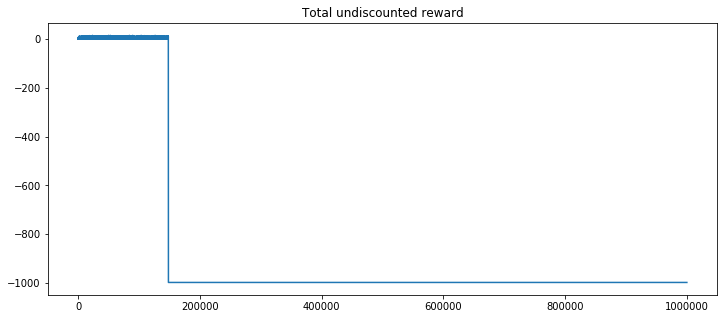

In [26]:
plt.figure(3,figsize=[12,5])
plt.title("Total undiscounted reward")
plt.plot(reward_total)
plt.show()

In [27]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: -673.610181


In [ ]:
print("Average total undiscounted reward: {}". format(np.average(reward_total)))
print("Average total undiscounted reward in last 100 episodes: {}". format(np.average(reward_total[-100:])))



plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

In [ ]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()